# TabNet

In [85]:
import os
from datetime import datetime
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchsummary as summary
import pandas as pd
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
import optuna
import mlflow
import mlflow.pytorch

In [77]:
import preprocess_for_all_models as my_preprocess
import word2vec_for_categorical_col as my_word2vec
import preprocess_for_nn as my_nn_preprocess
import cross_val as my_cross_validation

## 各種定数

In [3]:
RANDOM_STATE = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
TARGET_COLUMN = "ProdTaken"
DROP_COLUMNS = ["id", "MonthlyIncome", "customer_info"]

In [4]:
# 今日の日付を取得し、YYYYMMDD形式にフォーマットする
today_str: str = datetime.now().strftime("%Y%m%d")

# 今日の日付をディレクトリ名として設定
data_directory_name: str = "../data/" + today_str
model_directory_name: str = "../models/" + today_str

# ディレクトリが存在しない場合、作成する
if not os.path.exists(data_directory_name):
    os.makedirs(data_directory_name)
if not os.path.exists(model_directory_name):
    os.makedirs(model_directory_name)


## 前処理

In [110]:
# ローカルファイルを読み込む
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")
# google colaboratory で実行する場合は以下を有効にする
# from google.colab import drive
# drive.mount('/content/drive')
# train_df = pd.read_csv("/content/drive/mydrive/signate_cup_2024_data/train.csv")
# test_df = pd.read_csv("/content/drive/mydrive/signate_cup_2024_data/test.csv")

In [111]:
# すべてのモデルに共通する前処理を実施
train_df, test_df = my_preprocess.preprocess_total(train_df, test_df)

In [112]:
train_df, test_df = my_nn_preprocess.preprocess_data(train_df, test_df)

"['customer_info_concat'] not found in axis"


## 学習用データの設定

In [113]:
X_train = train_df.drop(columns=[TARGET_COLUMN, "id"]).values  # 入力データ
y_train = train_df[TARGET_COLUMN].values  # ターゲット変数

In [114]:
# 検証用データの作成
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

In [115]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2791, 23), (698, 23), (2791,), (698,))

In [94]:
type(X_train)

torch.Tensor

## 事前学習

In [10]:
unsupervised_model = TabNetPretrainer(
    optimizer_fn=optim.AdamW,
    optimizer_params=dict(lr=LEARNING_RATE),
    device_name=DEVICE,
    mask_type="entmax",
)
unsupervised_model.fit(
    X_train,
    eval_set=[X_val],
    batch_size=BATCH_SIZE,
    pretraining_ratio=0.8,
)

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 52.70321| val_0_unsup_loss_numpy: 5.806270122528076|  0:00:00s
epoch 1  | loss: 30.36718| val_0_unsup_loss_numpy: 7.40818977355957|  0:00:01s
epoch 2  | loss: 23.04346| val_0_unsup_loss_numpy: 8.389399528503418|  0:00:02s
epoch 3  | loss: 16.16974| val_0_unsup_loss_numpy: 9.339030265808105|  0:00:02s
epoch 4  | loss: 12.38733| val_0_unsup_loss_numpy: 13.002019882202148|  0:00:03s
epoch 5  | loss: 8.78985 | val_0_unsup_loss_numpy: 13.41748046875|  0:00:04s
epoch 6  | loss: 6.51449 | val_0_unsup_loss_numpy: 10.21448040008545|  0:00:05s
epoch 7  | loss: 5.15442 | val_0_unsup_loss_numpy: 10.526260375976562|  0:00:05s
epoch 8  | loss: 3.93568 | val_0_unsup_loss_numpy: 8.645090103149414|  0:00:06s
epoch 9  | loss: 3.11917 | val_0_unsup_loss_numpy: 7.757229804992676|  0:00:06s
epoch 10 | loss: 2.32742 | val_0_unsup_loss_numpy: 5.454629898071289|  0:00:07s
epoch 11 | loss: 1.91669 | val_0_unsup_loss_numpy: 4.436709880828857|  0:00:08s
epoch 12 | loss: 1.56815 | val_0_unsup_los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [20]:
print(unsupervised_model)

TabNetPretrainer(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adamw.AdamW'>, optimizer_params={'lr': 0.001}, scheduler_fn=None, scheduler_params={}, mask_type='entmax', input_dim=23, output_dim=None, device_name=device(type='cpu'), n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])


In [71]:
best_model = None

# Optunaの目的関数
def objective(trial):
    global best_model
    # ハイパーパラメータのサンプリング
    n_d = trial.suggest_int("n_d", 8, 64)
    n_a = trial.suggest_int("n_a", 8, 64)
    n_steps = trial.suggest_int("n_steps", 3, 10)
    gamma = trial.suggest_float("gamma", 1.0, 2.0)
    lambda_sparse = trial.suggest_float("lambda_sparse", 0.0, 1e-3)
    momentum = trial.suggest_float("momentum", 0.01, 0.4)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
    clip_value = trial.suggest_float("clip_value", 1.0, 2.0)
    
    # TabNetモデルの定義
    model = TabNetClassifier(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=learning_rate),
        clip_value=clip_value,
        momentum=momentum
    )

    # モデルの学習
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_name=["valid"],
        eval_metric=["auc"],
        max_epochs=NUM_EPOCHS,
        patience=10,
        batch_size=BATCH_SIZE,
        virtual_batch_size=16,
        num_workers=0,
        drop_last=False
    )
    
    # 検証データでの予測（確率）
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # ROC AUCスコアの計算
    auc = roc_auc_score(y_val, y_pred_proba)
    
    # ベストモデルを保存
    if best_model is None or auc > study.best_value:
        best_model = model
    
    return auc

# Optunaのスタディを作成して最適化を実行
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# 最適なハイパーパラメータの表示
print("Best trial:")
trial = study.best_trial
print(f"  AUC: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# ベストモデルの保存
if best_model is not None:
    joblib.dump(best_model, model_directory_name + "best_tabnet_model.pkl")
    print("Best model saved as 'best_tabnet_model.pkl'")

[I 2024-08-12 18:00:40,351] A new study created in memory with name: no-name-a9bb1161-b339-4544-a3ab-a06dc10ea1ab
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81124 | valid_auc: 0.58198 |  0:00:02s
epoch 1  | loss: 0.86991 | valid_auc: 0.67339 |  0:00:04s
epoch 2  | loss: 0.97726 | valid_auc: 0.60134 |  0:00:06s
epoch 3  | loss: 0.48802 | valid_auc: 0.63709 |  0:00:08s
epoch 4  | loss: 0.41747 | valid_auc: 0.65304 |  0:00:10s
epoch 5  | loss: 0.40687 | valid_auc: 0.65916 |  0:00:12s
epoch 6  | loss: 0.39958 | valid_auc: 0.71691 |  0:00:15s
epoch 7  | loss: 0.4053  | valid_auc: 0.76195 |  0:00:17s
epoch 8  | loss: 0.39724 | valid_auc: 0.76326 |  0:00:19s
epoch 9  | loss: 0.35951 | valid_auc: 0.79595 |  0:00:21s
epoch 10 | loss: 0.37201 | valid_auc: 0.74997 |  0:00:23s
epoch 11 | loss: 0.37174 | valid_auc: 0.76997 |  0:00:25s
epoch 12 | loss: 0.35421 | valid_auc: 0.76599 |  0:00:27s
epoch 13 | loss: 0.36544 | valid_auc: 0.81958 |  0:00:30s
epoch 14 | loss: 0.36736 | valid_auc: 0.78681 |  0:00:32s
epoch 15 | loss: 0.35807 | valid_auc: 0.82231 |  0:00:34s
epoch 16 | loss: 0.36385 | valid_auc: 0.81662 |  0:00:36s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:02:01,082] Trial 0 finished with value: 0.8385140395025074 and parameters: {'n_d': 50, 'n_a': 21, 'n_steps': 8, 'gamma': 1.7963311604273184, 'lambda_sparse': 0.0009903798384418062, 'momentum': 0.10871380963779083, 'learning_rate': 0.013385823010815775, 'clip_value': 1.1842429520470616}. Best is trial 0 with value: 0.8385140395025074.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.6543  | valid_auc: 0.61689 |  0:00:02s
epoch 1  | loss: 0.52109 | valid_auc: 0.5872  |  0:00:04s
epoch 2  | loss: 0.50746 | valid_auc: 0.65932 |  0:00:06s
epoch 3  | loss: 0.45201 | valid_auc: 0.67527 |  0:00:08s
epoch 4  | loss: 0.42764 | valid_auc: 0.65711 |  0:00:10s
epoch 5  | loss: 0.42026 | valid_auc: 0.73319 |  0:00:13s
epoch 6  | loss: 0.41937 | valid_auc: 0.69341 |  0:00:15s
epoch 7  | loss: 0.39327 | valid_auc: 0.74311 |  0:00:17s
epoch 8  | loss: 0.38486 | valid_auc: 0.71099 |  0:00:19s
epoch 9  | loss: 0.37949 | valid_auc: 0.7171  |  0:00:21s
epoch 10 | loss: 0.37521 | valid_auc: 0.73739 |  0:00:23s
epoch 11 | loss: 0.39464 | valid_auc: 0.72794 |  0:00:26s
epoch 12 | loss: 0.36928 | valid_auc: 0.7533  |  0:00:28s
epoch 13 | loss: 0.3849  | valid_auc: 0.70983 |  0:00:30s
epoch 14 | loss: 0.38149 | valid_auc: 0.74689 |  0:00:32s
epoch 15 | loss: 0.38342 | valid_auc: 0.73114 |  0:00:33s
epoch 16 | loss: 0.37775 | valid_auc: 0.78254 |  0:00:35s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:03:03,101] Trial 1 finished with value: 0.8044426742944041 and parameters: {'n_d': 47, 'n_a': 39, 'n_steps': 7, 'gamma': 1.3649638114681482, 'lambda_sparse': 0.00011054678461962542, 'momentum': 0.19853083110649658, 'learning_rate': 0.004489383887058194, 'clip_value': 1.1150544469025792}. Best is trial 0 with value: 0.8385140395025074.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.73824 | valid_auc: 0.42481 |  0:00:00s
epoch 1  | loss: 0.58295 | valid_auc: 0.45969 |  0:00:01s
epoch 2  | loss: 0.52063 | valid_auc: 0.48833 |  0:00:02s
epoch 3  | loss: 0.48753 | valid_auc: 0.49939 |  0:00:02s
epoch 4  | loss: 0.46534 | valid_auc: 0.5035  |  0:00:03s
epoch 5  | loss: 0.46433 | valid_auc: 0.54148 |  0:00:04s
epoch 6  | loss: 0.45345 | valid_auc: 0.51847 |  0:00:04s
epoch 7  | loss: 0.45477 | valid_auc: 0.53996 |  0:00:05s
epoch 8  | loss: 0.42939 | valid_auc: 0.60177 |  0:00:06s
epoch 9  | loss: 0.44499 | valid_auc: 0.57729 |  0:00:07s
epoch 10 | loss: 0.4318  | valid_auc: 0.56821 |  0:00:08s
epoch 11 | loss: 0.43122 | valid_auc: 0.56279 |  0:00:09s
epoch 12 | loss: 0.42075 | valid_auc: 0.59391 |  0:00:10s
epoch 13 | loss: 0.42249 | valid_auc: 0.51855 |  0:00:10s
epoch 14 | loss: 0.42268 | valid_auc: 0.63515 |  0:00:11s
epoch 15 | loss: 0.42415 | valid_auc: 0.61426 |  0:00:12s
epoch 16 | loss: 0.42095 | valid_auc: 0.61611 |  0:00:13s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:03:35,427] Trial 2 finished with value: 0.7156253960207831 and parameters: {'n_d': 17, 'n_a': 21, 'n_steps': 3, 'gamma': 1.9148819241550117, 'lambda_sparse': 0.00023510773924353045, 'momentum': 0.2679966718189768, 'learning_rate': 0.0003973573468291745, 'clip_value': 1.6585175464250377}. Best is trial 0 with value: 0.8385140395025074.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.69743 | valid_auc: 0.43246 |  0:00:02s
epoch 1  | loss: 0.51492 | valid_auc: 0.66465 |  0:00:04s
epoch 2  | loss: 0.44477 | valid_auc: 0.64641 |  0:00:06s
epoch 3  | loss: 0.43179 | valid_auc: 0.72491 |  0:00:08s
epoch 4  | loss: 0.39687 | valid_auc: 0.74019 |  0:00:10s
epoch 5  | loss: 0.40628 | valid_auc: 0.70388 |  0:00:12s
epoch 6  | loss: 0.39874 | valid_auc: 0.74227 |  0:00:15s
epoch 7  | loss: 0.39066 | valid_auc: 0.77866 |  0:00:17s
epoch 8  | loss: 0.37817 | valid_auc: 0.75862 |  0:00:19s
epoch 9  | loss: 0.38534 | valid_auc: 0.74117 |  0:00:21s
epoch 10 | loss: 0.38185 | valid_auc: 0.76963 |  0:00:23s
epoch 11 | loss: 0.38448 | valid_auc: 0.74807 |  0:00:25s
epoch 12 | loss: 0.37122 | valid_auc: 0.76617 |  0:00:27s
epoch 13 | loss: 0.37075 | valid_auc: 0.75838 |  0:00:29s
epoch 14 | loss: 0.38777 | valid_auc: 0.75582 |  0:00:31s
epoch 15 | loss: 0.36256 | valid_auc: 0.74767 |  0:00:33s
epoch 16 | loss: 0.36609 | valid_auc: 0.75504 |  0:00:35s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:05:32,389] Trial 3 finished with value: 0.825651284465123 and parameters: {'n_d': 48, 'n_a': 60, 'n_steps': 7, 'gamma': 1.1841897903238496, 'lambda_sparse': 0.000519088686980057, 'momentum': 0.130313917956109, 'learning_rate': 0.006082103615548687, 'clip_value': 1.0680476833428545}. Best is trial 0 with value: 0.8385140395025074.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorc

epoch 0  | loss: 0.75462 | valid_auc: 0.55693 |  0:00:01s
epoch 1  | loss: 0.72824 | valid_auc: 0.4526  |  0:00:03s
epoch 2  | loss: 0.64626 | valid_auc: 0.51666 |  0:00:04s
epoch 3  | loss: 0.6167  | valid_auc: 0.50857 |  0:00:05s
epoch 4  | loss: 0.6032  | valid_auc: 0.48831 |  0:00:07s
epoch 5  | loss: 0.61069 | valid_auc: 0.5465  |  0:00:08s
epoch 6  | loss: 0.55425 | valid_auc: 0.56487 |  0:00:09s
epoch 7  | loss: 0.5507  | valid_auc: 0.64544 |  0:00:11s
epoch 8  | loss: 0.53726 | valid_auc: 0.6154  |  0:00:12s
epoch 9  | loss: 0.51752 | valid_auc: 0.55124 |  0:00:13s
epoch 10 | loss: 0.49726 | valid_auc: 0.61176 |  0:00:15s
epoch 11 | loss: 0.47594 | valid_auc: 0.62078 |  0:00:16s
epoch 12 | loss: 0.49711 | valid_auc: 0.64612 |  0:00:18s
epoch 13 | loss: 0.49458 | valid_auc: 0.65235 |  0:00:19s
epoch 14 | loss: 0.48252 | valid_auc: 0.64573 |  0:00:20s
epoch 15 | loss: 0.46707 | valid_auc: 0.64124 |  0:00:21s
epoch 16 | loss: 0.48784 | valid_auc: 0.63877 |  0:00:23s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:06:56,531] Trial 4 finished with value: 0.7825370675453047 and parameters: {'n_d': 63, 'n_a': 50, 'n_steps': 4, 'gamma': 1.0073248725326995, 'lambda_sparse': 0.0005804810652699714, 'momentum': 0.227650396151412, 'learning_rate': 0.00019969731665819878, 'clip_value': 1.061036516418603}. Best is trial 0 with value: 0.8385140395025074.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyt

epoch 0  | loss: 1.71763 | valid_auc: 0.45875 |  0:00:02s
epoch 1  | loss: 1.72806 | valid_auc: 0.4799  |  0:00:04s
epoch 2  | loss: 1.68404 | valid_auc: 0.39417 |  0:00:06s
epoch 3  | loss: 1.70597 | valid_auc: 0.46404 |  0:00:08s
epoch 4  | loss: 1.68008 | valid_auc: 0.51313 |  0:00:10s
epoch 5  | loss: 1.63121 | valid_auc: 0.4346  |  0:00:12s
epoch 6  | loss: 1.59278 | valid_auc: 0.49516 |  0:00:14s
epoch 7  | loss: 1.58998 | valid_auc: 0.49959 |  0:00:16s
epoch 8  | loss: 1.56966 | valid_auc: 0.49152 |  0:00:18s
epoch 9  | loss: 1.60766 | valid_auc: 0.5381  |  0:00:20s
epoch 10 | loss: 1.55702 | valid_auc: 0.52382 |  0:00:21s
epoch 11 | loss: 1.54405 | valid_auc: 0.48272 |  0:00:24s
epoch 12 | loss: 1.50382 | valid_auc: 0.54514 |  0:00:26s
epoch 13 | loss: 1.5155  | valid_auc: 0.52117 |  0:00:28s
epoch 14 | loss: 1.5242  | valid_auc: 0.57264 |  0:00:30s
epoch 15 | loss: 1.49127 | valid_auc: 0.54183 |  0:00:32s
epoch 16 | loss: 1.46883 | valid_auc: 0.4589  |  0:00:34s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:07:47,667] Trial 5 finished with value: 0.5726415265130257 and parameters: {'n_d': 12, 'n_a': 39, 'n_steps': 9, 'gamma': 1.9340148810562119, 'lambda_sparse': 6.612257058067661e-05, 'momentum': 0.18939376137826117, 'learning_rate': 2.299279846099208e-05, 'clip_value': 1.3156008212944466}. Best is trial 0 with value: 0.8385140395025074.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.61665 | valid_auc: 0.60812 |  0:00:01s
epoch 1  | loss: 0.41916 | valid_auc: 0.69032 |  0:00:02s
epoch 2  | loss: 0.393   | valid_auc: 0.78514 |  0:00:03s
epoch 3  | loss: 0.37719 | valid_auc: 0.77741 |  0:00:05s
epoch 4  | loss: 0.36796 | valid_auc: 0.77475 |  0:00:06s
epoch 5  | loss: 0.3727  | valid_auc: 0.78411 |  0:00:07s
epoch 6  | loss: 0.36597 | valid_auc: 0.80595 |  0:00:08s
epoch 7  | loss: 0.3639  | valid_auc: 0.79261 |  0:00:09s
epoch 8  | loss: 0.3597  | valid_auc: 0.80167 |  0:00:11s
epoch 9  | loss: 0.35523 | valid_auc: 0.80101 |  0:00:12s
epoch 10 | loss: 0.35346 | valid_auc: 0.81082 |  0:00:13s
epoch 11 | loss: 0.35177 | valid_auc: 0.81315 |  0:00:14s
epoch 12 | loss: 0.34391 | valid_auc: 0.8141  |  0:00:15s
epoch 13 | loss: 0.34568 | valid_auc: 0.82197 |  0:00:16s
epoch 14 | loss: 0.35447 | valid_auc: 0.80994 |  0:00:18s
epoch 15 | loss: 0.34933 | valid_auc: 0.78198 |  0:00:19s
epoch 16 | loss: 0.35138 | valid_auc: 0.79105 |  0:00:20s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:08:16,397] Trial 6 finished with value: 0.8219671596936837 and parameters: {'n_d': 45, 'n_a': 24, 'n_steps': 4, 'gamma': 1.2136521592612488, 'lambda_sparse': 0.0004567365308932737, 'momentum': 0.2408337408923993, 'learning_rate': 0.009570641444555007, 'clip_value': 1.830168627732406}. Best is trial 0 with value: 0.8385140395025074.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyto

epoch 0  | loss: 0.7292  | valid_auc: 0.63707 |  0:00:01s
epoch 1  | loss: 0.41589 | valid_auc: 0.68052 |  0:00:03s
epoch 2  | loss: 0.38651 | valid_auc: 0.74648 |  0:00:05s
epoch 3  | loss: 0.38694 | valid_auc: 0.74188 |  0:00:06s
epoch 4  | loss: 0.37821 | valid_auc: 0.76179 |  0:00:08s
epoch 5  | loss: 0.37781 | valid_auc: 0.76918 |  0:00:10s
epoch 6  | loss: 0.37026 | valid_auc: 0.78373 |  0:00:11s
epoch 7  | loss: 0.37211 | valid_auc: 0.77654 |  0:00:13s
epoch 8  | loss: 0.36194 | valid_auc: 0.79226 |  0:00:14s
epoch 9  | loss: 0.35947 | valid_auc: 0.78314 |  0:00:16s
epoch 10 | loss: 0.35946 | valid_auc: 0.80839 |  0:00:18s
epoch 11 | loss: 0.34929 | valid_auc: 0.78418 |  0:00:19s
epoch 12 | loss: 0.35067 | valid_auc: 0.80585 |  0:00:21s
epoch 13 | loss: 0.34766 | valid_auc: 0.80373 |  0:00:23s
epoch 14 | loss: 0.34765 | valid_auc: 0.81022 |  0:00:24s
epoch 15 | loss: 0.34405 | valid_auc: 0.81126 |  0:00:26s
epoch 16 | loss: 0.35178 | valid_auc: 0.81786 |  0:00:27s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:09:13,699] Trial 7 finished with value: 0.846561181816536 and parameters: {'n_d': 25, 'n_a': 55, 'n_steps': 6, 'gamma': 1.109337355181537, 'lambda_sparse': 0.0004928245976462285, 'momentum': 0.18045948480639623, 'learning_rate': 0.02228011525480276, 'clip_value': 1.684181403795229}. Best is trial 7 with value: 0.846561181816536.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch

epoch 0  | loss: 1.33372 | valid_auc: 0.56803 |  0:00:01s
epoch 1  | loss: 0.94104 | valid_auc: 0.54871 |  0:00:02s
epoch 2  | loss: 0.70896 | valid_auc: 0.58081 |  0:00:04s
epoch 3  | loss: 0.68008 | valid_auc: 0.59447 |  0:00:06s
epoch 4  | loss: 0.61879 | valid_auc: 0.60769 |  0:00:07s
epoch 5  | loss: 0.60905 | valid_auc: 0.53486 |  0:00:09s
epoch 6  | loss: 0.58753 | valid_auc: 0.56493 |  0:00:11s
epoch 7  | loss: 0.56876 | valid_auc: 0.54952 |  0:00:12s
epoch 8  | loss: 0.56786 | valid_auc: 0.52954 |  0:00:14s
epoch 9  | loss: 0.5526  | valid_auc: 0.52874 |  0:00:15s
epoch 10 | loss: 0.53714 | valid_auc: 0.55939 |  0:00:16s
epoch 11 | loss: 0.52586 | valid_auc: 0.51178 |  0:00:18s
epoch 12 | loss: 0.51773 | valid_auc: 0.5394  |  0:00:19s
epoch 13 | loss: 0.5122  | valid_auc: 0.53365 |  0:00:21s
epoch 14 | loss: 0.50286 | valid_auc: 0.54225 |  0:00:22s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_valid_auc = 0.60769


/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:09:37,106] Trial 8 finished with value: 0.6076904973115846 and parameters: {'n_d': 14, 'n_a': 13, 'n_steps': 6, 'gamma': 1.8589283160498202, 'lambda_sparse': 0.0005785739752113665, 'momentum': 0.09202597919599476, 'learning_rate': 0.0006716391339750197, 'clip_value': 1.0259656297341102}. Best is trial 7 with value: 0.846561181816536.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.65845 | valid_auc: 0.42745 |  0:00:01s
epoch 1  | loss: 0.65494 | valid_auc: 0.41087 |  0:00:02s
epoch 2  | loss: 0.64682 | valid_auc: 0.4808  |  0:00:03s
epoch 3  | loss: 0.62251 | valid_auc: 0.44371 |  0:00:04s
epoch 4  | loss: 0.62024 | valid_auc: 0.46539 |  0:00:05s
epoch 5  | loss: 0.58373 | valid_auc: 0.48717 |  0:00:06s
epoch 6  | loss: 0.58182 | valid_auc: 0.50852 |  0:00:07s
epoch 7  | loss: 0.56769 | valid_auc: 0.46449 |  0:00:08s
epoch 8  | loss: 0.55626 | valid_auc: 0.47017 |  0:00:09s
epoch 9  | loss: 0.55406 | valid_auc: 0.49805 |  0:00:11s
epoch 10 | loss: 0.55526 | valid_auc: 0.49664 |  0:00:12s
epoch 11 | loss: 0.54559 | valid_auc: 0.53341 |  0:00:12s
epoch 12 | loss: 0.53072 | valid_auc: 0.48891 |  0:00:13s
epoch 13 | loss: 0.52239 | valid_auc: 0.45678 |  0:00:14s
epoch 14 | loss: 0.532   | valid_auc: 0.50303 |  0:00:15s
epoch 15 | loss: 0.5104  | valid_auc: 0.50476 |  0:00:16s
epoch 16 | loss: 0.53331 | valid_auc: 0.47832 |  0:00:18s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:10:10,311] Trial 9 finished with value: 0.5817658453572786 and parameters: {'n_d': 20, 'n_a': 26, 'n_steps': 4, 'gamma': 1.239883196219664, 'lambda_sparse': 0.00011499378347856093, 'momentum': 0.12242594534644544, 'learning_rate': 6.0692222943350014e-05, 'clip_value': 1.9142118250875013}. Best is trial 7 with value: 0.846561181816536.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.87933 | valid_auc: 0.65241 |  0:00:02s
epoch 1  | loss: 0.39877 | valid_auc: 0.76249 |  0:00:05s
epoch 2  | loss: 0.37035 | valid_auc: 0.80096 |  0:00:08s
epoch 3  | loss: 0.37378 | valid_auc: 0.727   |  0:00:10s
epoch 4  | loss: 0.35861 | valid_auc: 0.79394 |  0:00:13s
epoch 5  | loss: 0.36723 | valid_auc: 0.80939 |  0:00:15s
epoch 6  | loss: 0.36032 | valid_auc: 0.79315 |  0:00:18s
epoch 7  | loss: 0.36183 | valid_auc: 0.81053 |  0:00:20s
epoch 8  | loss: 0.36046 | valid_auc: 0.828   |  0:00:22s
epoch 9  | loss: 0.35399 | valid_auc: 0.80655 |  0:00:25s
epoch 10 | loss: 0.36743 | valid_auc: 0.8025  |  0:00:28s
epoch 11 | loss: 0.35553 | valid_auc: 0.79729 |  0:00:30s
epoch 12 | loss: 0.36024 | valid_auc: 0.81866 |  0:00:33s
epoch 13 | loss: 0.34831 | valid_auc: 0.82825 |  0:00:35s
epoch 14 | loss: 0.34353 | valid_auc: 0.83459 |  0:00:38s
epoch 15 | loss: 0.35003 | valid_auc: 0.81634 |  0:00:40s
epoch 16 | loss: 0.34909 | valid_auc: 0.82772 |  0:00:43s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:11:24,550] Trial 10 finished with value: 0.8410576244184153 and parameters: {'n_d': 29, 'n_a': 64, 'n_steps': 10, 'gamma': 1.608229167548626, 'lambda_sparse': 0.0008257824140415416, 'momentum': 0.3951976148883764, 'learning_rate': 0.09387624902419023, 'clip_value': 1.5660272998420957}. Best is trial 7 with value: 0.846561181816536.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyto

epoch 0  | loss: 1.29109 | valid_auc: 0.67231 |  0:00:02s
epoch 1  | loss: 0.43403 | valid_auc: 0.71063 |  0:00:04s
epoch 2  | loss: 0.4151  | valid_auc: 0.58432 |  0:00:07s
epoch 3  | loss: 0.38671 | valid_auc: 0.67618 |  0:00:09s
epoch 4  | loss: 0.3995  | valid_auc: 0.71599 |  0:00:11s
epoch 5  | loss: 0.39094 | valid_auc: 0.79387 |  0:00:14s
epoch 6  | loss: 0.36868 | valid_auc: 0.75284 |  0:00:16s
epoch 7  | loss: 0.37057 | valid_auc: 0.76423 |  0:00:19s
epoch 8  | loss: 0.3745  | valid_auc: 0.79587 |  0:00:22s
epoch 9  | loss: 0.36174 | valid_auc: 0.79813 |  0:00:24s
epoch 10 | loss: 0.35569 | valid_auc: 0.82324 |  0:00:27s
epoch 11 | loss: 0.35023 | valid_auc: 0.83287 |  0:00:29s
epoch 12 | loss: 0.35958 | valid_auc: 0.83119 |  0:00:32s
epoch 13 | loss: 0.3605  | valid_auc: 0.76986 |  0:00:34s
epoch 14 | loss: 0.35967 | valid_auc: 0.7824  |  0:00:37s
epoch 15 | loss: 0.34678 | valid_auc: 0.82133 |  0:00:39s
epoch 16 | loss: 0.36041 | valid_auc: 0.80478 |  0:00:42s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:13:15,446] Trial 11 finished with value: 0.8495664138168257 and parameters: {'n_d': 30, 'n_a': 64, 'n_steps': 10, 'gamma': 1.59593221480212, 'lambda_sparse': 0.0008697807603748395, 'momentum': 0.3910000322964704, 'learning_rate': 0.06492988393658031, 'clip_value': 1.5273129341034393}. Best is trial 11 with value: 0.8495664138168257.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyt

epoch 0  | loss: 0.61103 | valid_auc: 0.63238 |  0:00:01s
epoch 1  | loss: 0.41996 | valid_auc: 0.7363  |  0:00:02s
epoch 2  | loss: 0.40331 | valid_auc: 0.65341 |  0:00:04s
epoch 3  | loss: 0.38395 | valid_auc: 0.70944 |  0:00:06s
epoch 4  | loss: 0.37053 | valid_auc: 0.73676 |  0:00:07s
epoch 5  | loss: 0.36615 | valid_auc: 0.80004 |  0:00:09s
epoch 6  | loss: 0.36379 | valid_auc: 0.78331 |  0:00:10s
epoch 7  | loss: 0.36034 | valid_auc: 0.81007 |  0:00:11s
epoch 8  | loss: 0.36123 | valid_auc: 0.7928  |  0:00:13s
epoch 9  | loss: 0.35414 | valid_auc: 0.80688 |  0:00:15s
epoch 10 | loss: 0.36286 | valid_auc: 0.82732 |  0:00:16s
epoch 11 | loss: 0.3609  | valid_auc: 0.83518 |  0:00:18s
epoch 12 | loss: 0.36869 | valid_auc: 0.80105 |  0:00:19s
epoch 13 | loss: 0.3656  | valid_auc: 0.82733 |  0:00:21s
epoch 14 | loss: 0.3567  | valid_auc: 0.8029  |  0:00:22s
epoch 15 | loss: 0.35045 | valid_auc: 0.81569 |  0:00:24s
epoch 16 | loss: 0.36136 | valid_auc: 0.8196  |  0:00:26s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:14:09,105] Trial 12 finished with value: 0.841600738635335 and parameters: {'n_d': 30, 'n_a': 53, 'n_steps': 6, 'gamma': 1.5935486203030051, 'lambda_sparse': 0.0007705093912355081, 'momentum': 0.3726386553471932, 'learning_rate': 0.08079364941771949, 'clip_value': 1.42716403004224}. Best is trial 11 with value: 0.8495664138168257.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytor

epoch 0  | loss: 0.80089 | valid_auc: 0.57478 |  0:00:02s
epoch 1  | loss: 0.65909 | valid_auc: 0.63479 |  0:00:04s
epoch 2  | loss: 0.46534 | valid_auc: 0.68787 |  0:00:06s
epoch 3  | loss: 0.41301 | valid_auc: 0.63939 |  0:00:09s
epoch 4  | loss: 0.38789 | valid_auc: 0.63858 |  0:00:11s
epoch 5  | loss: 0.39127 | valid_auc: 0.73052 |  0:00:14s
epoch 6  | loss: 0.39738 | valid_auc: 0.75658 |  0:00:16s
epoch 7  | loss: 0.37122 | valid_auc: 0.78935 |  0:00:19s
epoch 8  | loss: 0.36692 | valid_auc: 0.8045  |  0:00:21s
epoch 9  | loss: 0.36658 | valid_auc: 0.80964 |  0:00:24s
epoch 10 | loss: 0.3552  | valid_auc: 0.7701  |  0:00:27s
epoch 11 | loss: 0.36637 | valid_auc: 0.79013 |  0:00:29s
epoch 12 | loss: 0.35692 | valid_auc: 0.78151 |  0:00:31s
epoch 13 | loss: 0.37422 | valid_auc: 0.76782 |  0:00:34s
epoch 14 | loss: 0.3666  | valid_auc: 0.7565  |  0:00:36s
epoch 15 | loss: 0.36833 | valid_auc: 0.77902 |  0:00:39s
epoch 16 | loss: 0.36058 | valid_auc: 0.78301 |  0:00:41s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:16:31,431] Trial 13 finished with value: 0.8551695421547151 and parameters: {'n_d': 27, 'n_a': 49, 'n_steps': 10, 'gamma': 1.4903382575872917, 'lambda_sparse': 0.0003536001612119159, 'momentum': 0.31389496745249734, 'learning_rate': 0.028925749909539177, 'clip_value': 1.710458929552378}. Best is trial 13 with value: 0.8551695421547151.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 2.15147 | valid_auc: 0.55097 |  0:00:02s
epoch 1  | loss: 0.93529 | valid_auc: 0.62903 |  0:00:05s
epoch 2  | loss: 0.80541 | valid_auc: 0.62154 |  0:00:07s
epoch 3  | loss: 0.76468 | valid_auc: 0.66055 |  0:00:09s
epoch 4  | loss: 0.6896  | valid_auc: 0.61557 |  0:00:12s
epoch 5  | loss: 0.65926 | valid_auc: 0.63602 |  0:00:14s
epoch 6  | loss: 0.59618 | valid_auc: 0.62674 |  0:00:17s
epoch 7  | loss: 0.70907 | valid_auc: 0.67554 |  0:00:19s
epoch 8  | loss: 0.56159 | valid_auc: 0.67372 |  0:00:21s
epoch 9  | loss: 0.53353 | valid_auc: 0.63273 |  0:00:24s
epoch 10 | loss: 0.53772 | valid_auc: 0.67844 |  0:00:26s
epoch 11 | loss: 0.66043 | valid_auc: 0.67471 |  0:00:28s
epoch 12 | loss: 0.52514 | valid_auc: 0.72151 |  0:00:31s
epoch 13 | loss: 0.46968 | valid_auc: 0.62313 |  0:00:33s
epoch 14 | loss: 0.52428 | valid_auc: 0.61696 |  0:00:35s
epoch 15 | loss: 0.50867 | valid_auc: 0.74068 |  0:00:38s
epoch 16 | loss: 0.51827 | valid_auc: 0.65501 |  0:00:40s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:17:35,370] Trial 14 finished with value: 0.7406810652280172 and parameters: {'n_d': 37, 'n_a': 45, 'n_steps': 10, 'gamma': 1.4542203342834834, 'lambda_sparse': 0.0003460153278643764, 'momentum': 0.32299970142651147, 'learning_rate': 0.002046808266271461, 'clip_value': 1.4343965404412935}. Best is trial 13 with value: 0.8551695421547151.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages

epoch 0  | loss: 1.2656  | valid_auc: 0.55074 |  0:00:02s
epoch 1  | loss: 0.69959 | valid_auc: 0.56082 |  0:00:04s
epoch 2  | loss: 0.46921 | valid_auc: 0.67243 |  0:00:06s
epoch 3  | loss: 0.39694 | valid_auc: 0.70933 |  0:00:08s
epoch 4  | loss: 0.39658 | valid_auc: 0.76622 |  0:00:10s
epoch 5  | loss: 0.37028 | valid_auc: 0.7934  |  0:00:13s
epoch 6  | loss: 0.37265 | valid_auc: 0.80267 |  0:00:15s
epoch 7  | loss: 0.37028 | valid_auc: 0.77203 |  0:00:17s
epoch 8  | loss: 0.36724 | valid_auc: 0.78902 |  0:00:19s
epoch 9  | loss: 0.36673 | valid_auc: 0.76024 |  0:00:21s
epoch 10 | loss: 0.35526 | valid_auc: 0.78565 |  0:00:23s
epoch 11 | loss: 0.36604 | valid_auc: 0.80901 |  0:00:26s
epoch 12 | loss: 0.36343 | valid_auc: 0.75071 |  0:00:28s
epoch 13 | loss: 0.36234 | valid_auc: 0.78232 |  0:00:31s
epoch 14 | loss: 0.34863 | valid_auc: 0.81084 |  0:00:33s
epoch 15 | loss: 0.35521 | valid_auc: 0.82387 |  0:00:35s
epoch 16 | loss: 0.35451 | valid_auc: 0.7749  |  0:00:38s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:19:10,375] Trial 15 finished with value: 0.8320328765139309 and parameters: {'n_d': 36, 'n_a': 46, 'n_steps': 9, 'gamma': 1.6876742887455423, 'lambda_sparse': 0.0007436272241520638, 'momentum': 0.013572308063290545, 'learning_rate': 0.03338230708670106, 'clip_value': 1.7112820282477594}. Best is trial 13 with value: 0.8551695421547151.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 1.26878 | valid_auc: 0.56479 |  0:00:02s
epoch 1  | loss: 0.50919 | valid_auc: 0.66845 |  0:00:04s
epoch 2  | loss: 0.41787 | valid_auc: 0.7354  |  0:00:07s
epoch 3  | loss: 0.38494 | valid_auc: 0.73129 |  0:00:09s
epoch 4  | loss: 0.37429 | valid_auc: 0.75828 |  0:00:11s
epoch 5  | loss: 0.37754 | valid_auc: 0.7669  |  0:00:14s
epoch 6  | loss: 0.36543 | valid_auc: 0.78372 |  0:00:17s
epoch 7  | loss: 0.36605 | valid_auc: 0.78538 |  0:00:19s
epoch 8  | loss: 0.36755 | valid_auc: 0.7749  |  0:00:21s
epoch 9  | loss: 0.36416 | valid_auc: 0.78321 |  0:00:24s
epoch 10 | loss: 0.35901 | valid_auc: 0.77816 |  0:00:26s
epoch 11 | loss: 0.36025 | valid_auc: 0.79257 |  0:00:29s
epoch 12 | loss: 0.35659 | valid_auc: 0.78117 |  0:00:31s
epoch 13 | loss: 0.36789 | valid_auc: 0.77797 |  0:00:33s
epoch 14 | loss: 0.35696 | valid_auc: 0.78318 |  0:00:36s
epoch 15 | loss: 0.36101 | valid_auc: 0.80213 |  0:00:38s
epoch 16 | loss: 0.36273 | valid_auc: 0.78456 |  0:00:40s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:20:28,459] Trial 16 finished with value: 0.8381429114542788 and parameters: {'n_d': 37, 'n_a': 59, 'n_steps': 9, 'gamma': 1.3844866800904687, 'lambda_sparse': 0.0009926081814228228, 'momentum': 0.32217439052300495, 'learning_rate': 0.04709334862577013, 'clip_value': 1.9902277212755233}. Best is trial 13 with value: 0.8551695421547151.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.77504 | valid_auc: 0.63327 |  0:00:03s
epoch 1  | loss: 0.68043 | valid_auc: 0.66745 |  0:00:06s
epoch 2  | loss: 0.59101 | valid_auc: 0.65161 |  0:00:08s
epoch 3  | loss: 0.58888 | valid_auc: 0.67759 |  0:00:10s
epoch 4  | loss: 0.61774 | valid_auc: 0.68331 |  0:00:12s
epoch 5  | loss: 0.53299 | valid_auc: 0.6777  |  0:00:14s
epoch 6  | loss: 0.50796 | valid_auc: 0.59921 |  0:00:16s
epoch 7  | loss: 0.5239  | valid_auc: 0.65943 |  0:00:18s
epoch 8  | loss: 0.48333 | valid_auc: 0.69881 |  0:00:20s
epoch 9  | loss: 0.4761  | valid_auc: 0.70293 |  0:00:23s
epoch 10 | loss: 0.45009 | valid_auc: 0.7168  |  0:00:25s
epoch 11 | loss: 0.4436  | valid_auc: 0.76012 |  0:00:27s
epoch 12 | loss: 0.42314 | valid_auc: 0.74964 |  0:00:29s
epoch 13 | loss: 0.42329 | valid_auc: 0.6847  |  0:00:31s
epoch 14 | loss: 0.4358  | valid_auc: 0.74521 |  0:00:34s
epoch 15 | loss: 0.42637 | valid_auc: 0.74814 |  0:00:36s
epoch 16 | loss: 0.41021 | valid_auc: 0.70312 |  0:00:38s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:21:17,144] Trial 17 finished with value: 0.7601245541937469 and parameters: {'n_d': 23, 'n_a': 64, 'n_steps': 10, 'gamma': 1.7461935364773982, 'lambda_sparse': 0.0003193477701835073, 'momentum': 0.3298475008603392, 'learning_rate': 0.0027371621579729334, 'clip_value': 1.797955797971439}. Best is trial 13 with value: 0.8551695421547151.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.72528 | valid_auc: 0.55307 |  0:00:02s
epoch 1  | loss: 0.47855 | valid_auc: 0.61164 |  0:00:04s
epoch 2  | loss: 0.50143 | valid_auc: 0.59408 |  0:00:06s
epoch 3  | loss: 0.40194 | valid_auc: 0.6605  |  0:00:08s
epoch 4  | loss: 0.41944 | valid_auc: 0.64867 |  0:00:10s
epoch 5  | loss: 0.43953 | valid_auc: 0.69122 |  0:00:12s
epoch 6  | loss: 0.39174 | valid_auc: 0.7045  |  0:00:14s
epoch 7  | loss: 0.38283 | valid_auc: 0.76165 |  0:00:16s
epoch 8  | loss: 0.38046 | valid_auc: 0.75687 |  0:00:18s
epoch 9  | loss: 0.37281 | valid_auc: 0.7733  |  0:00:19s
epoch 10 | loss: 0.37069 | valid_auc: 0.78385 |  0:00:21s
epoch 11 | loss: 0.35796 | valid_auc: 0.78019 |  0:00:22s
epoch 12 | loss: 0.36053 | valid_auc: 0.76896 |  0:00:23s
epoch 13 | loss: 0.36392 | valid_auc: 0.77683 |  0:00:25s
epoch 14 | loss: 0.36469 | valid_auc: 0.77836 |  0:00:26s
epoch 15 | loss: 0.34938 | valid_auc: 0.78602 |  0:00:28s
epoch 16 | loss: 0.36325 | valid_auc: 0.79236 |  0:00:30s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:22:11,661] Trial 18 finished with value: 0.7973097742455237 and parameters: {'n_d': 31, 'n_a': 32, 'n_steps': 8, 'gamma': 1.5493567117810998, 'lambda_sparse': 0.0008546837446360328, 'momentum': 0.28955309137525986, 'learning_rate': 0.020976847604096925, 'clip_value': 1.5594672056195937}. Best is trial 13 with value: 0.8551695421547151.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.81699 | valid_auc: 0.47952 |  0:00:02s
epoch 1  | loss: 0.68937 | valid_auc: 0.4069  |  0:00:03s
epoch 2  | loss: 0.64838 | valid_auc: 0.46967 |  0:00:04s
epoch 3  | loss: 0.60207 | valid_auc: 0.57194 |  0:00:06s
epoch 4  | loss: 0.54098 | valid_auc: 0.56821 |  0:00:07s
epoch 5  | loss: 0.49598 | valid_auc: 0.56824 |  0:00:08s
epoch 6  | loss: 0.47663 | valid_auc: 0.65382 |  0:00:10s
epoch 7  | loss: 0.47896 | valid_auc: 0.63758 |  0:00:12s
epoch 8  | loss: 0.46588 | valid_auc: 0.62444 |  0:00:14s
epoch 9  | loss: 0.43262 | valid_auc: 0.61537 |  0:00:16s
epoch 10 | loss: 0.44013 | valid_auc: 0.67156 |  0:00:17s
epoch 11 | loss: 0.4367  | valid_auc: 0.62493 |  0:00:19s
epoch 12 | loss: 0.44057 | valid_auc: 0.63208 |  0:00:20s
epoch 13 | loss: 0.43427 | valid_auc: 0.65051 |  0:00:21s
epoch 14 | loss: 0.41498 | valid_auc: 0.67518 |  0:00:22s
epoch 15 | loss: 0.41386 | valid_auc: 0.69798 |  0:00:24s
epoch 16 | loss: 0.40251 | valid_auc: 0.69783 |  0:00:25s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:23:06,459] Trial 19 finished with value: 0.7746800152071981 and parameters: {'n_d': 8, 'n_a': 45, 'n_steps': 8, 'gamma': 1.4591353657783968, 'lambda_sparse': 0.000653196374018524, 'momentum': 0.35960191615481496, 'learning_rate': 0.001753272305773356, 'clip_value': 1.2903974611501194}. Best is trial 13 with value: 0.8551695421547151.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 1.01694 | valid_auc: 0.61551 |  0:00:02s
epoch 1  | loss: 0.80071 | valid_auc: 0.61484 |  0:00:04s
epoch 2  | loss: 0.452   | valid_auc: 0.701   |  0:00:06s
epoch 3  | loss: 0.42067 | valid_auc: 0.73992 |  0:00:08s
epoch 4  | loss: 0.38753 | valid_auc: 0.75507 |  0:00:10s
epoch 5  | loss: 0.38047 | valid_auc: 0.77195 |  0:00:12s
epoch 6  | loss: 0.38893 | valid_auc: 0.7842  |  0:00:14s
epoch 7  | loss: 0.36638 | valid_auc: 0.80795 |  0:00:17s
epoch 8  | loss: 0.36806 | valid_auc: 0.79496 |  0:00:19s
epoch 9  | loss: 0.35451 | valid_auc: 0.74551 |  0:00:22s
epoch 10 | loss: 0.35977 | valid_auc: 0.84309 |  0:00:24s
epoch 11 | loss: 0.35935 | valid_auc: 0.81454 |  0:00:26s
epoch 12 | loss: 0.35464 | valid_auc: 0.80256 |  0:00:28s
epoch 13 | loss: 0.35816 | valid_auc: 0.81028 |  0:00:30s
epoch 14 | loss: 0.35915 | valid_auc: 0.79792 |  0:00:32s
epoch 15 | loss: 0.34947 | valid_auc: 0.7973  |  0:00:34s
epoch 16 | loss: 0.35389 | valid_auc: 0.80566 |  0:00:36s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:23:50,587] Trial 20 finished with value: 0.8430943027318644 and parameters: {'n_d': 42, 'n_a': 56, 'n_steps': 10, 'gamma': 1.3273310480517446, 'lambda_sparse': 0.0003733402288117571, 'momentum': 0.3986943935548687, 'learning_rate': 0.04085786343100304, 'clip_value': 1.5488456585512291}. Best is trial 13 with value: 0.8551695421547151.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.5266  | valid_auc: 0.61276 |  0:00:01s
epoch 1  | loss: 0.40251 | valid_auc: 0.79255 |  0:00:02s
epoch 2  | loss: 0.38785 | valid_auc: 0.78509 |  0:00:03s
epoch 3  | loss: 0.37153 | valid_auc: 0.69707 |  0:00:04s
epoch 4  | loss: 0.37651 | valid_auc: 0.80104 |  0:00:05s
epoch 5  | loss: 0.36431 | valid_auc: 0.78217 |  0:00:06s
epoch 6  | loss: 0.37003 | valid_auc: 0.80098 |  0:00:07s
epoch 7  | loss: 0.35252 | valid_auc: 0.80535 |  0:00:08s
epoch 8  | loss: 0.36815 | valid_auc: 0.81036 |  0:00:09s
epoch 9  | loss: 0.35641 | valid_auc: 0.8211  |  0:00:10s
epoch 10 | loss: 0.35564 | valid_auc: 0.83335 |  0:00:11s
epoch 11 | loss: 0.35746 | valid_auc: 0.78808 |  0:00:12s
epoch 12 | loss: 0.36492 | valid_auc: 0.7907  |  0:00:13s
epoch 13 | loss: 0.35697 | valid_auc: 0.78979 |  0:00:14s
epoch 14 | loss: 0.35156 | valid_auc: 0.8119  |  0:00:15s
epoch 15 | loss: 0.34462 | valid_auc: 0.82259 |  0:00:16s
epoch 16 | loss: 0.35661 | valid_auc: 0.81931 |  0:00:17s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:24:12,502] Trial 21 finished with value: 0.8333454025381539 and parameters: {'n_d': 25, 'n_a': 53, 'n_steps': 5, 'gamma': 1.0278533642028505, 'lambda_sparse': 0.00044403212642775256, 'momentum': 0.17949717606804397, 'learning_rate': 0.016861562136597306, 'clip_value': 1.6843169602832626}. Best is trial 13 with value: 0.8551695421547151.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages

epoch 0  | loss: 0.65611 | valid_auc: 0.60349 |  0:00:01s
epoch 1  | loss: 0.41815 | valid_auc: 0.52632 |  0:00:02s
epoch 2  | loss: 0.41241 | valid_auc: 0.5739  |  0:00:03s
epoch 3  | loss: 0.39939 | valid_auc: 0.70302 |  0:00:04s
epoch 4  | loss: 0.37778 | valid_auc: 0.73055 |  0:00:05s
epoch 5  | loss: 0.38468 | valid_auc: 0.7572  |  0:00:06s
epoch 6  | loss: 0.38224 | valid_auc: 0.76984 |  0:00:07s
epoch 7  | loss: 0.3786  | valid_auc: 0.80714 |  0:00:08s
epoch 8  | loss: 0.36542 | valid_auc: 0.75014 |  0:00:09s
epoch 9  | loss: 0.38095 | valid_auc: 0.75245 |  0:00:10s
epoch 10 | loss: 0.3688  | valid_auc: 0.77941 |  0:00:12s
epoch 11 | loss: 0.37081 | valid_auc: 0.76789 |  0:00:13s
epoch 12 | loss: 0.35931 | valid_auc: 0.79598 |  0:00:14s
epoch 13 | loss: 0.37183 | valid_auc: 0.77279 |  0:00:15s
epoch 14 | loss: 0.36    | valid_auc: 0.79296 |  0:00:16s
epoch 15 | loss: 0.36268 | valid_auc: 0.77893 |  0:00:17s
epoch 16 | loss: 0.35753 | valid_auc: 0.79507 |  0:00:18s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:24:42,557] Trial 22 finished with value: 0.8260767239350435 and parameters: {'n_d': 24, 'n_a': 59, 'n_steps': 5, 'gamma': 1.664142333372773, 'lambda_sparse': 0.00022157823572811633, 'momentum': 0.2844080609461876, 'learning_rate': 0.08660944955273847, 'clip_value': 1.8004726423927429}. Best is trial 13 with value: 0.8551695421547151.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.69861 | valid_auc: 0.53303 |  0:00:01s
epoch 1  | loss: 0.66386 | valid_auc: 0.74115 |  0:00:03s
epoch 2  | loss: 0.42637 | valid_auc: 0.70717 |  0:00:05s
epoch 3  | loss: 0.38424 | valid_auc: 0.7566  |  0:00:06s
epoch 4  | loss: 0.39807 | valid_auc: 0.75553 |  0:00:08s
epoch 5  | loss: 0.37946 | valid_auc: 0.7651  |  0:00:09s
epoch 6  | loss: 0.36102 | valid_auc: 0.78111 |  0:00:11s
epoch 7  | loss: 0.36068 | valid_auc: 0.81423 |  0:00:13s
epoch 8  | loss: 0.36699 | valid_auc: 0.79831 |  0:00:15s
epoch 9  | loss: 0.36348 | valid_auc: 0.79152 |  0:00:17s
epoch 10 | loss: 0.36285 | valid_auc: 0.78249 |  0:00:19s
epoch 11 | loss: 0.36251 | valid_auc: 0.78721 |  0:00:20s
epoch 12 | loss: 0.36399 | valid_auc: 0.77844 |  0:00:22s
epoch 13 | loss: 0.3604  | valid_auc: 0.80075 |  0:00:24s
epoch 14 | loss: 0.34994 | valid_auc: 0.82231 |  0:00:25s
epoch 15 | loss: 0.3588  | valid_auc: 0.82002 |  0:00:27s
epoch 16 | loss: 0.35085 | valid_auc: 0.81716 |  0:00:29s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:26:04,507] Trial 23 finished with value: 0.8576226080344697 and parameters: {'n_d': 33, 'n_a': 49, 'n_steps': 9, 'gamma': 1.1569214593650814, 'lambda_sparse': 0.000653451237982697, 'momentum': 0.3494906916023886, 'learning_rate': 0.023302866491546226, 'clip_value': 1.6243037083784635}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.89416 | valid_auc: 0.44474 |  0:00:01s
epoch 1  | loss: 0.72417 | valid_auc: 0.53526 |  0:00:03s
epoch 2  | loss: 0.68854 | valid_auc: 0.55282 |  0:00:05s
epoch 3  | loss: 0.76869 | valid_auc: 0.55854 |  0:00:06s
epoch 4  | loss: 0.7033  | valid_auc: 0.65011 |  0:00:08s
epoch 5  | loss: 0.72404 | valid_auc: 0.63785 |  0:00:09s
epoch 6  | loss: 0.4363  | valid_auc: 0.69951 |  0:00:11s
epoch 7  | loss: 0.45151 | valid_auc: 0.65681 |  0:00:13s
epoch 8  | loss: 0.44974 | valid_auc: 0.64978 |  0:00:15s
epoch 9  | loss: 0.43446 | valid_auc: 0.61285 |  0:00:16s
epoch 10 | loss: 0.40794 | valid_auc: 0.68487 |  0:00:18s
epoch 11 | loss: 0.433   | valid_auc: 0.69654 |  0:00:20s
epoch 12 | loss: 0.42958 | valid_auc: 0.73116 |  0:00:21s
epoch 13 | loss: 0.41443 | valid_auc: 0.77852 |  0:00:23s
epoch 14 | loss: 0.40056 | valid_auc: 0.72992 |  0:00:24s
epoch 15 | loss: 0.38201 | valid_auc: 0.76869 |  0:00:26s
epoch 16 | loss: 0.3801  | valid_auc: 0.73234 |  0:00:28s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:26:59,948] Trial 24 finished with value: 0.7937433242210836 and parameters: {'n_d': 54, 'n_a': 35, 'n_steps': 9, 'gamma': 1.5311071910298373, 'lambda_sparse': 0.0006852207395445363, 'momentum': 0.344568088872055, 'learning_rate': 0.006058447599890384, 'clip_value': 1.4883563512616913}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 1.08514 | valid_auc: 0.63287 |  0:00:01s
epoch 1  | loss: 0.64155 | valid_auc: 0.61643 |  0:00:03s
epoch 2  | loss: 0.40585 | valid_auc: 0.72524 |  0:00:05s
epoch 3  | loss: 0.39764 | valid_auc: 0.73529 |  0:00:07s
epoch 4  | loss: 0.38765 | valid_auc: 0.73268 |  0:00:08s
epoch 5  | loss: 0.39534 | valid_auc: 0.79148 |  0:00:10s
epoch 6  | loss: 0.38203 | valid_auc: 0.73954 |  0:00:12s
epoch 7  | loss: 0.37382 | valid_auc: 0.75802 |  0:00:14s
epoch 8  | loss: 0.37397 | valid_auc: 0.7636  |  0:00:15s
epoch 9  | loss: 0.36803 | valid_auc: 0.75962 |  0:00:17s
epoch 10 | loss: 0.38445 | valid_auc: 0.74566 |  0:00:19s
epoch 11 | loss: 0.37318 | valid_auc: 0.79136 |  0:00:21s
epoch 12 | loss: 0.37011 | valid_auc: 0.77578 |  0:00:23s
epoch 13 | loss: 0.36076 | valid_auc: 0.78895 |  0:00:25s
epoch 14 | loss: 0.3533  | valid_auc: 0.77676 |  0:00:26s
epoch 15 | loss: 0.36382 | valid_auc: 0.7675  |  0:00:28s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_valid_

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:27:29,174] Trial 25 finished with value: 0.7914803483172512 and parameters: {'n_d': 34, 'n_a': 48, 'n_steps': 10, 'gamma': 1.2702332162004681, 'lambda_sparse': 0.0008804136945273167, 'momentum': 0.3054811524398945, 'learning_rate': 0.0336156416505166, 'clip_value': 1.6098060109064294}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.75552 | valid_auc: 0.59728 |  0:00:01s
epoch 1  | loss: 0.57445 | valid_auc: 0.50444 |  0:00:03s
epoch 2  | loss: 0.56458 | valid_auc: 0.55331 |  0:00:04s
epoch 3  | loss: 0.56983 | valid_auc: 0.60253 |  0:00:07s
epoch 4  | loss: 0.4151  | valid_auc: 0.66419 |  0:00:09s
epoch 5  | loss: 0.42649 | valid_auc: 0.61497 |  0:00:10s
epoch 6  | loss: 0.40491 | valid_auc: 0.69363 |  0:00:12s
epoch 7  | loss: 0.38967 | valid_auc: 0.68749 |  0:00:14s
epoch 8  | loss: 0.39484 | valid_auc: 0.73536 |  0:00:15s
epoch 9  | loss: 0.4173  | valid_auc: 0.71545 |  0:00:17s
epoch 10 | loss: 0.42399 | valid_auc: 0.73456 |  0:00:18s
epoch 11 | loss: 0.38583 | valid_auc: 0.74957 |  0:00:20s
epoch 12 | loss: 0.37722 | valid_auc: 0.714   |  0:00:21s
epoch 13 | loss: 0.38899 | valid_auc: 0.76022 |  0:00:23s
epoch 14 | loss: 0.38632 | valid_auc: 0.68945 |  0:00:24s
epoch 15 | loss: 0.40248 | valid_auc: 0.75132 |  0:00:26s
epoch 16 | loss: 0.36766 | valid_auc: 0.70806 |  0:00:28s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:28:32,783] Trial 26 finished with value: 0.8041349095714828 and parameters: {'n_d': 29, 'n_a': 42, 'n_steps': 9, 'gamma': 1.4703288063634472, 'lambda_sparse': 0.0006358745876525157, 'momentum': 0.3660391789679188, 'learning_rate': 0.01026181684922125, 'clip_value': 1.365438811780698}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyt

epoch 0  | loss: 0.63192 | valid_auc: 0.56605 |  0:00:01s
epoch 1  | loss: 0.46781 | valid_auc: 0.63054 |  0:00:03s
epoch 2  | loss: 0.42993 | valid_auc: 0.717   |  0:00:04s
epoch 3  | loss: 0.37488 | valid_auc: 0.78154 |  0:00:05s
epoch 4  | loss: 0.38158 | valid_auc: 0.75411 |  0:00:07s
epoch 5  | loss: 0.37605 | valid_auc: 0.7562  |  0:00:08s
epoch 6  | loss: 0.37909 | valid_auc: 0.76227 |  0:00:10s
epoch 7  | loss: 0.38597 | valid_auc: 0.75983 |  0:00:12s
epoch 8  | loss: 0.36067 | valid_auc: 0.80953 |  0:00:14s
epoch 9  | loss: 0.36081 | valid_auc: 0.76549 |  0:00:16s
epoch 10 | loss: 0.36248 | valid_auc: 0.80933 |  0:00:18s
epoch 11 | loss: 0.36492 | valid_auc: 0.82462 |  0:00:19s
epoch 12 | loss: 0.35924 | valid_auc: 0.80518 |  0:00:21s
epoch 13 | loss: 0.36225 | valid_auc: 0.79842 |  0:00:22s
epoch 14 | loss: 0.35643 | valid_auc: 0.78421 |  0:00:24s
epoch 15 | loss: 0.36135 | valid_auc: 0.80254 |  0:00:25s
epoch 16 | loss: 0.35757 | valid_auc: 0.75649 |  0:00:27s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:29:07,792] Trial 27 finished with value: 0.8246193674529754 and parameters: {'n_d': 41, 'n_a': 50, 'n_steps': 8, 'gamma': 1.118162828838797, 'lambda_sparse': 0.0008894491870461899, 'momentum': 0.2562392617856168, 'learning_rate': 0.04623983159273132, 'clip_value': 1.7298183558113978}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyt

epoch 0  | loss: 2.46136 | valid_auc: 0.55915 |  0:00:01s
epoch 1  | loss: 1.00316 | valid_auc: 0.60769 |  0:00:03s
epoch 2  | loss: 0.76442 | valid_auc: 0.62377 |  0:00:04s
epoch 3  | loss: 0.78004 | valid_auc: 0.59114 |  0:00:06s
epoch 4  | loss: 0.71894 | valid_auc: 0.59464 |  0:00:08s
epoch 5  | loss: 0.66675 | valid_auc: 0.63733 |  0:00:09s
epoch 6  | loss: 0.69658 | valid_auc: 0.5887  |  0:00:11s
epoch 7  | loss: 0.63464 | valid_auc: 0.66401 |  0:00:12s
epoch 8  | loss: 0.66017 | valid_auc: 0.58158 |  0:00:14s
epoch 9  | loss: 0.60382 | valid_auc: 0.61823 |  0:00:16s
epoch 10 | loss: 0.58482 | valid_auc: 0.63899 |  0:00:17s
epoch 11 | loss: 0.58807 | valid_auc: 0.62583 |  0:00:19s
epoch 12 | loss: 0.58441 | valid_auc: 0.71671 |  0:00:21s
epoch 13 | loss: 0.55275 | valid_auc: 0.64832 |  0:00:22s
epoch 14 | loss: 0.51804 | valid_auc: 0.60018 |  0:00:24s
epoch 15 | loss: 0.51804 | valid_auc: 0.61041 |  0:00:25s
epoch 16 | loss: 0.52104 | valid_auc: 0.6412  |  0:00:27s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:29:44,999] Trial 28 finished with value: 0.7167116244546228 and parameters: {'n_d': 20, 'n_a': 31, 'n_steps': 10, 'gamma': 1.7304372868919444, 'lambda_sparse': 0.0007719065448184561, 'momentum': 0.37583717776729497, 'learning_rate': 0.0011836633791783607, 'clip_value': 1.4885844018696928}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-package

epoch 0  | loss: 0.87126 | valid_auc: 0.63008 |  0:00:01s
epoch 1  | loss: 0.78858 | valid_auc: 0.60988 |  0:00:03s
epoch 2  | loss: 0.6962  | valid_auc: 0.64868 |  0:00:05s
epoch 3  | loss: 0.71661 | valid_auc: 0.5707  |  0:00:06s
epoch 4  | loss: 0.56605 | valid_auc: 0.69861 |  0:00:08s
epoch 5  | loss: 0.4566  | valid_auc: 0.62366 |  0:00:09s
epoch 6  | loss: 0.45621 | valid_auc: 0.70348 |  0:00:11s
epoch 7  | loss: 0.42178 | valid_auc: 0.72909 |  0:00:12s
epoch 8  | loss: 0.39969 | valid_auc: 0.7602  |  0:00:14s
epoch 9  | loss: 0.39926 | valid_auc: 0.76372 |  0:00:15s
epoch 10 | loss: 0.38549 | valid_auc: 0.78262 |  0:00:17s
epoch 11 | loss: 0.39133 | valid_auc: 0.76811 |  0:00:18s
epoch 12 | loss: 0.39445 | valid_auc: 0.74067 |  0:00:20s
epoch 13 | loss: 0.39178 | valid_auc: 0.7735  |  0:00:21s
epoch 14 | loss: 0.37855 | valid_auc: 0.79322 |  0:00:23s
epoch 15 | loss: 0.3716  | valid_auc: 0.77081 |  0:00:24s
epoch 16 | loss: 0.37673 | valid_auc: 0.80462 |  0:00:26s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:30:40,186] Trial 29 finished with value: 0.8239857341999023 and parameters: {'n_d': 53, 'n_a': 9, 'n_steps': 9, 'gamma': 1.8180813356668741, 'lambda_sparse': 0.0009410803855783179, 'momentum': 0.3413800523198903, 'learning_rate': 0.011902532604189513, 'clip_value': 1.6192118876132497}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.85259 | valid_auc: 0.53891 |  0:00:01s
epoch 1  | loss: 0.50629 | valid_auc: 0.62009 |  0:00:03s
epoch 2  | loss: 0.47943 | valid_auc: 0.55729 |  0:00:04s
epoch 3  | loss: 0.44877 | valid_auc: 0.61634 |  0:00:06s
epoch 4  | loss: 0.4124  | valid_auc: 0.6611  |  0:00:07s
epoch 5  | loss: 0.4092  | valid_auc: 0.63763 |  0:00:08s
epoch 6  | loss: 0.41688 | valid_auc: 0.68494 |  0:00:09s
epoch 7  | loss: 0.39674 | valid_auc: 0.70493 |  0:00:11s
epoch 8  | loss: 0.39592 | valid_auc: 0.70083 |  0:00:12s
epoch 9  | loss: 0.38719 | valid_auc: 0.73478 |  0:00:13s
epoch 10 | loss: 0.39949 | valid_auc: 0.71298 |  0:00:14s
epoch 11 | loss: 0.38138 | valid_auc: 0.72884 |  0:00:16s
epoch 12 | loss: 0.37585 | valid_auc: 0.67935 |  0:00:17s
epoch 13 | loss: 0.39842 | valid_auc: 0.76111 |  0:00:18s
epoch 14 | loss: 0.36228 | valid_auc: 0.76548 |  0:00:19s
epoch 15 | loss: 0.38448 | valid_auc: 0.75109 |  0:00:20s
epoch 16 | loss: 0.37822 | valid_auc: 0.75844 |  0:00:22s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:31:33,515] Trial 30 finished with value: 0.7959700925104549 and parameters: {'n_d': 33, 'n_a': 41, 'n_steps': 7, 'gamma': 1.3230700218340776, 'lambda_sparse': 0.0007090906115095539, 'momentum': 0.29770292685196165, 'learning_rate': 0.003885488415433716, 'clip_value': 1.222032571900031}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.55886 | valid_auc: 0.62976 |  0:00:01s
epoch 1  | loss: 0.40586 | valid_auc: 0.73139 |  0:00:02s
epoch 2  | loss: 0.39178 | valid_auc: 0.7565  |  0:00:03s
epoch 3  | loss: 0.39702 | valid_auc: 0.76871 |  0:00:04s
epoch 4  | loss: 0.38579 | valid_auc: 0.7807  |  0:00:05s
epoch 5  | loss: 0.35867 | valid_auc: 0.76481 |  0:00:06s
epoch 6  | loss: 0.37535 | valid_auc: 0.78965 |  0:00:07s
epoch 7  | loss: 0.37316 | valid_auc: 0.77066 |  0:00:08s
epoch 8  | loss: 0.3696  | valid_auc: 0.75229 |  0:00:09s
epoch 9  | loss: 0.37415 | valid_auc: 0.75458 |  0:00:11s
epoch 10 | loss: 0.35287 | valid_auc: 0.79168 |  0:00:12s
epoch 11 | loss: 0.36255 | valid_auc: 0.81091 |  0:00:13s
epoch 12 | loss: 0.35293 | valid_auc: 0.79857 |  0:00:14s
epoch 13 | loss: 0.35251 | valid_auc: 0.79124 |  0:00:15s
epoch 14 | loss: 0.36481 | valid_auc: 0.79317 |  0:00:16s
epoch 15 | loss: 0.34912 | valid_auc: 0.80078 |  0:00:17s
epoch 16 | loss: 0.34826 | valid_auc: 0.78893 |  0:00:18s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:32:07,981] Trial 31 finished with value: 0.845900392852617 and parameters: {'n_d': 26, 'n_a': 53, 'n_steps': 6, 'gamma': 1.1309103181593518, 'lambda_sparse': 0.0005213667676021474, 'momentum': 0.22890773909453968, 'learning_rate': 0.021866663514964375, 'clip_value': 1.7527322929509648}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.59992 | valid_auc: 0.67746 |  0:00:01s
epoch 1  | loss: 0.45442 | valid_auc: 0.66863 |  0:00:02s
epoch 2  | loss: 0.39802 | valid_auc: 0.78949 |  0:00:04s
epoch 3  | loss: 0.38645 | valid_auc: 0.77358 |  0:00:05s
epoch 4  | loss: 0.37563 | valid_auc: 0.77708 |  0:00:07s
epoch 5  | loss: 0.37589 | valid_auc: 0.79475 |  0:00:08s
epoch 6  | loss: 0.36697 | valid_auc: 0.79266 |  0:00:10s
epoch 7  | loss: 0.36421 | valid_auc: 0.81208 |  0:00:12s
epoch 8  | loss: 0.35503 | valid_auc: 0.80702 |  0:00:13s
epoch 9  | loss: 0.36164 | valid_auc: 0.80135 |  0:00:15s
epoch 10 | loss: 0.35015 | valid_auc: 0.81337 |  0:00:16s
epoch 11 | loss: 0.35317 | valid_auc: 0.82383 |  0:00:18s
epoch 12 | loss: 0.35046 | valid_auc: 0.81664 |  0:00:19s
epoch 13 | loss: 0.35489 | valid_auc: 0.81612 |  0:00:21s
epoch 14 | loss: 0.35368 | valid_auc: 0.82324 |  0:00:22s
epoch 15 | loss: 0.3535  | valid_auc: 0.81023 |  0:00:23s
epoch 16 | loss: 0.34654 | valid_auc: 0.8003  |  0:00:25s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:33:08,113] Trial 32 finished with value: 0.8424154099607147 and parameters: {'n_d': 27, 'n_a': 56, 'n_steps': 8, 'gamma': 1.110436518491632, 'lambda_sparse': 0.0004197923841108652, 'momentum': 0.14816694453470874, 'learning_rate': 0.023292877690501746, 'clip_value': 1.6236682303049448}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.50971 | valid_auc: 0.52153 |  0:00:00s
epoch 1  | loss: 0.39226 | valid_auc: 0.67329 |  0:00:01s
epoch 2  | loss: 0.38191 | valid_auc: 0.75808 |  0:00:02s
epoch 3  | loss: 0.37955 | valid_auc: 0.74966 |  0:00:03s
epoch 4  | loss: 0.37377 | valid_auc: 0.80299 |  0:00:04s
epoch 5  | loss: 0.37522 | valid_auc: 0.79174 |  0:00:05s
epoch 6  | loss: 0.36816 | valid_auc: 0.78656 |  0:00:06s
epoch 7  | loss: 0.3647  | valid_auc: 0.79348 |  0:00:07s
epoch 8  | loss: 0.36423 | valid_auc: 0.79718 |  0:00:08s
epoch 9  | loss: 0.37086 | valid_auc: 0.81218 |  0:00:09s
epoch 10 | loss: 0.36964 | valid_auc: 0.80212 |  0:00:10s
epoch 11 | loss: 0.36455 | valid_auc: 0.7925  |  0:00:11s
epoch 12 | loss: 0.35883 | valid_auc: 0.79637 |  0:00:12s
epoch 13 | loss: 0.35956 | valid_auc: 0.82797 |  0:00:13s
epoch 14 | loss: 0.35807 | valid_auc: 0.81962 |  0:00:14s
epoch 15 | loss: 0.35649 | valid_auc: 0.82436 |  0:00:15s
epoch 16 | loss: 0.35087 | valid_auc: 0.82663 |  0:00:16s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:33:36,098] Trial 33 finished with value: 0.8288556583449498 and parameters: {'n_d': 21, 'n_a': 62, 'n_steps': 5, 'gamma': 1.0566126839145045, 'lambda_sparse': 0.00021948821285666274, 'momentum': 0.0754052103805167, 'learning_rate': 0.06124520864528664, 'clip_value': 1.8777208271127095}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.7529  | valid_auc: 0.50953 |  0:00:01s
epoch 1  | loss: 0.5668  | valid_auc: 0.66008 |  0:00:02s
epoch 2  | loss: 0.50681 | valid_auc: 0.59496 |  0:00:03s
epoch 3  | loss: 0.4588  | valid_auc: 0.64269 |  0:00:05s
epoch 4  | loss: 0.42484 | valid_auc: 0.74421 |  0:00:06s
epoch 5  | loss: 0.45692 | valid_auc: 0.7076  |  0:00:07s
epoch 6  | loss: 0.42489 | valid_auc: 0.73226 |  0:00:09s
epoch 7  | loss: 0.39333 | valid_auc: 0.80952 |  0:00:10s
epoch 8  | loss: 0.3855  | valid_auc: 0.72093 |  0:00:13s
epoch 9  | loss: 0.37243 | valid_auc: 0.75826 |  0:00:14s
epoch 10 | loss: 0.37904 | valid_auc: 0.7784  |  0:00:16s
epoch 11 | loss: 0.36883 | valid_auc: 0.79419 |  0:00:17s
epoch 12 | loss: 0.37766 | valid_auc: 0.78587 |  0:00:18s
epoch 13 | loss: 0.37631 | valid_auc: 0.7613  |  0:00:20s
epoch 14 | loss: 0.36424 | valid_auc: 0.78331 |  0:00:21s
epoch 15 | loss: 0.36034 | valid_auc: 0.7978  |  0:00:22s
epoch 16 | loss: 0.36142 | valid_auc: 0.79602 |  0:00:24s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:34:02,221] Trial 34 finished with value: 0.8095207922226045 and parameters: {'n_d': 41, 'n_a': 56, 'n_steps': 7, 'gamma': 1.99461750605266, 'lambda_sparse': 0.0005795314552700743, 'momentum': 0.2137893604168657, 'learning_rate': 0.007093315066559839, 'clip_value': 1.6601032770270265}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyt

epoch 0  | loss: 0.85228 | valid_auc: 0.61542 |  0:00:01s
epoch 1  | loss: 0.63026 | valid_auc: 0.69857 |  0:00:03s
epoch 2  | loss: 0.50121 | valid_auc: 0.66852 |  0:00:05s
epoch 3  | loss: 0.50029 | valid_auc: 0.75226 |  0:00:07s
epoch 4  | loss: 0.42988 | valid_auc: 0.67516 |  0:00:08s
epoch 5  | loss: 0.40754 | valid_auc: 0.75898 |  0:00:10s
epoch 6  | loss: 0.38102 | valid_auc: 0.71193 |  0:00:12s
epoch 7  | loss: 0.40272 | valid_auc: 0.68768 |  0:00:14s
epoch 8  | loss: 0.38643 | valid_auc: 0.74946 |  0:00:16s
epoch 9  | loss: 0.36621 | valid_auc: 0.73294 |  0:00:18s
epoch 10 | loss: 0.36787 | valid_auc: 0.79306 |  0:00:20s
epoch 11 | loss: 0.36275 | valid_auc: 0.76977 |  0:00:22s
epoch 12 | loss: 0.3713  | valid_auc: 0.79633 |  0:00:24s
epoch 13 | loss: 0.35627 | valid_auc: 0.78844 |  0:00:26s
epoch 14 | loss: 0.35854 | valid_auc: 0.79436 |  0:00:28s
epoch 15 | loss: 0.35525 | valid_auc: 0.76911 |  0:00:30s
epoch 16 | loss: 0.35744 | valid_auc: 0.77979 |  0:00:32s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:34:58,167] Trial 35 finished with value: 0.8184912287053968 and parameters: {'n_d': 17, 'n_a': 60, 'n_steps': 10, 'gamma': 1.4031673469566839, 'lambda_sparse': 0.00029133027071126224, 'momentum': 0.16623421042526104, 'learning_rate': 0.013751681210288347, 'clip_value': 1.4312977725884188}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-package

epoch 0  | loss: 5.56959 | valid_auc: 0.52269 |  0:00:01s
epoch 1  | loss: 4.30423 | valid_auc: 0.56524 |  0:00:02s
epoch 2  | loss: 3.16526 | valid_auc: 0.52253 |  0:00:04s
epoch 3  | loss: 2.37759 | valid_auc: 0.56618 |  0:00:05s
epoch 4  | loss: 1.71879 | valid_auc: 0.5511  |  0:00:07s
epoch 5  | loss: 1.36356 | valid_auc: 0.59116 |  0:00:08s
epoch 6  | loss: 1.10601 | valid_auc: 0.55638 |  0:00:10s
epoch 7  | loss: 0.89062 | valid_auc: 0.50041 |  0:00:11s
epoch 8  | loss: 0.80874 | valid_auc: 0.53569 |  0:00:13s
epoch 9  | loss: 0.74533 | valid_auc: 0.5253  |  0:00:14s
epoch 10 | loss: 0.72262 | valid_auc: 0.57548 |  0:00:15s
epoch 11 | loss: 0.69697 | valid_auc: 0.62351 |  0:00:17s
epoch 12 | loss: 0.66116 | valid_auc: 0.55309 |  0:00:19s
epoch 13 | loss: 0.65301 | valid_auc: 0.57624 |  0:00:20s
epoch 14 | loss: 0.67866 | valid_auc: 0.55774 |  0:00:22s
epoch 15 | loss: 0.67209 | valid_auc: 0.63584 |  0:00:23s
epoch 16 | loss: 0.64345 | valid_auc: 0.5807  |  0:00:25s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:36:15,806] Trial 36 finished with value: 0.763745315639879 and parameters: {'n_d': 32, 'n_a': 50, 'n_steps': 8, 'gamma': 1.1618282021072917, 'lambda_sparse': 0.0005170384239362498, 'momentum': 0.2775600605789551, 'learning_rate': 0.0001816711976713322, 'clip_value': 1.7493169013262966}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.59574 | valid_auc: 0.58218 |  0:00:01s
epoch 1  | loss: 0.42598 | valid_auc: 0.60521 |  0:00:02s
epoch 2  | loss: 0.405   | valid_auc: 0.71635 |  0:00:03s
epoch 3  | loss: 0.39402 | valid_auc: 0.69383 |  0:00:05s
epoch 4  | loss: 0.3924  | valid_auc: 0.79256 |  0:00:06s
epoch 5  | loss: 0.37652 | valid_auc: 0.80604 |  0:00:08s
epoch 6  | loss: 0.36831 | valid_auc: 0.75105 |  0:00:09s
epoch 7  | loss: 0.36735 | valid_auc: 0.7637  |  0:00:10s
epoch 8  | loss: 0.36151 | valid_auc: 0.77805 |  0:00:12s
epoch 9  | loss: 0.36568 | valid_auc: 0.78652 |  0:00:13s
epoch 10 | loss: 0.35705 | valid_auc: 0.79558 |  0:00:14s
epoch 11 | loss: 0.35782 | valid_auc: 0.80242 |  0:00:15s
epoch 12 | loss: 0.35672 | valid_auc: 0.8024  |  0:00:17s
epoch 13 | loss: 0.35195 | valid_auc: 0.81293 |  0:00:19s
epoch 14 | loss: 0.35241 | valid_auc: 0.81842 |  0:00:20s
epoch 15 | loss: 0.34568 | valid_auc: 0.79492 |  0:00:21s
epoch 16 | loss: 0.35415 | valid_auc: 0.78326 |  0:00:22s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:37:00,374] Trial 37 finished with value: 0.836368738345674 and parameters: {'n_d': 17, 'n_a': 57, 'n_steps': 7, 'gamma': 1.2735388632015197, 'lambda_sparse': 0.0002650198938270558, 'momentum': 0.26451499412253915, 'learning_rate': 0.027253955656256646, 'clip_value': 1.5667172673345868}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.70498 | valid_auc: 0.45513 |  0:00:01s
epoch 1  | loss: 0.54823 | valid_auc: 0.63459 |  0:00:03s
epoch 2  | loss: 0.48535 | valid_auc: 0.69855 |  0:00:04s
epoch 3  | loss: 0.46673 | valid_auc: 0.71452 |  0:00:06s
epoch 4  | loss: 0.41336 | valid_auc: 0.76686 |  0:00:08s
epoch 5  | loss: 0.40422 | valid_auc: 0.77783 |  0:00:10s
epoch 6  | loss: 0.40256 | valid_auc: 0.70904 |  0:00:11s
epoch 7  | loss: 0.37977 | valid_auc: 0.75118 |  0:00:13s
epoch 8  | loss: 0.38467 | valid_auc: 0.78739 |  0:00:15s
epoch 9  | loss: 0.37212 | valid_auc: 0.77086 |  0:00:17s
epoch 10 | loss: 0.37049 | valid_auc: 0.74895 |  0:00:19s
epoch 11 | loss: 0.38067 | valid_auc: 0.78418 |  0:00:21s
epoch 12 | loss: 0.39621 | valid_auc: 0.75538 |  0:00:23s
epoch 13 | loss: 0.37213 | valid_auc: 0.75319 |  0:00:24s
epoch 14 | loss: 0.36255 | valid_auc: 0.811   |  0:00:27s
epoch 15 | loss: 0.36194 | valid_auc: 0.77428 |  0:00:28s
epoch 16 | loss: 0.36346 | valid_auc: 0.80832 |  0:00:30s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:38:19,613] Trial 38 finished with value: 0.8346307728515306 and parameters: {'n_d': 27, 'n_a': 52, 'n_steps': 9, 'gamma': 1.0756697903880637, 'lambda_sparse': 0.00047941164708280206, 'momentum': 0.38552546117192676, 'learning_rate': 0.004852155295014542, 'clip_value': 1.5050967056508806}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages

epoch 0  | loss: 0.5874  | valid_auc: 0.57411 |  0:00:00s
epoch 1  | loss: 0.39885 | valid_auc: 0.61341 |  0:00:01s
epoch 2  | loss: 0.39804 | valid_auc: 0.68045 |  0:00:02s
epoch 3  | loss: 0.38098 | valid_auc: 0.65826 |  0:00:03s
epoch 4  | loss: 0.38959 | valid_auc: 0.72331 |  0:00:04s
epoch 5  | loss: 0.38184 | valid_auc: 0.74291 |  0:00:05s
epoch 6  | loss: 0.37762 | valid_auc: 0.71296 |  0:00:05s
epoch 7  | loss: 0.37511 | valid_auc: 0.74828 |  0:00:06s
epoch 8  | loss: 0.37112 | valid_auc: 0.75754 |  0:00:07s
epoch 9  | loss: 0.35419 | valid_auc: 0.79179 |  0:00:08s
epoch 10 | loss: 0.35496 | valid_auc: 0.80241 |  0:00:09s
epoch 11 | loss: 0.34725 | valid_auc: 0.77857 |  0:00:10s
epoch 12 | loss: 0.35563 | valid_auc: 0.80141 |  0:00:11s
epoch 13 | loss: 0.35895 | valid_auc: 0.79    |  0:00:11s
epoch 14 | loss: 0.35566 | valid_auc: 0.80461 |  0:00:12s
epoch 15 | loss: 0.35606 | valid_auc: 0.72111 |  0:00:13s
epoch 16 | loss: 0.38197 | valid_auc: 0.74725 |  0:00:14s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:38:40,617] Trial 39 finished with value: 0.8046146604630954 and parameters: {'n_d': 39, 'n_a': 43, 'n_steps': 3, 'gamma': 1.1776234195646456, 'lambda_sparse': 0.0001529587680200458, 'momentum': 0.3500973432938922, 'learning_rate': 0.060633258264981234, 'clip_value': 1.8846713501276326}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.7751  | valid_auc: 0.56781 |  0:00:01s
epoch 1  | loss: 0.74772 | valid_auc: 0.56134 |  0:00:02s
epoch 2  | loss: 0.66727 | valid_auc: 0.58589 |  0:00:03s
epoch 3  | loss: 0.66231 | valid_auc: 0.55153 |  0:00:05s
epoch 4  | loss: 0.60459 | valid_auc: 0.58901 |  0:00:06s
epoch 5  | loss: 0.59451 | valid_auc: 0.55857 |  0:00:07s
epoch 6  | loss: 0.56724 | valid_auc: 0.55999 |  0:00:08s
epoch 7  | loss: 0.56267 | valid_auc: 0.63037 |  0:00:09s
epoch 8  | loss: 0.54532 | valid_auc: 0.59078 |  0:00:11s
epoch 9  | loss: 0.53124 | valid_auc: 0.61586 |  0:00:13s
epoch 10 | loss: 0.53128 | valid_auc: 0.62692 |  0:00:14s
epoch 11 | loss: 0.51659 | valid_auc: 0.66803 |  0:00:15s
epoch 12 | loss: 0.50034 | valid_auc: 0.62388 |  0:00:17s
epoch 13 | loss: 0.49122 | valid_auc: 0.63095 |  0:00:18s
epoch 14 | loss: 0.48978 | valid_auc: 0.65172 |  0:00:20s
epoch 15 | loss: 0.50074 | valid_auc: 0.62755 |  0:00:21s
epoch 16 | loss: 0.46992 | valid_auc: 0.6557  |  0:00:23s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:40:14,310] Trial 40 finished with value: 0.7311403588174593 and parameters: {'n_d': 34, 'n_a': 62, 'n_steps': 6, 'gamma': 1.6222283972505391, 'lambda_sparse': 6.517326376394815e-06, 'momentum': 0.20896282704209074, 'learning_rate': 0.00038254804445185715, 'clip_value': 1.6826850083689715}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-package

epoch 0  | loss: 0.64937 | valid_auc: 0.62042 |  0:00:01s
epoch 1  | loss: 0.44109 | valid_auc: 0.75006 |  0:00:02s
epoch 2  | loss: 0.4076  | valid_auc: 0.74314 |  0:00:03s
epoch 3  | loss: 0.38746 | valid_auc: 0.73355 |  0:00:05s
epoch 4  | loss: 0.39119 | valid_auc: 0.68664 |  0:00:06s
epoch 5  | loss: 0.38257 | valid_auc: 0.73757 |  0:00:08s
epoch 6  | loss: 0.37287 | valid_auc: 0.7127  |  0:00:09s
epoch 7  | loss: 0.38281 | valid_auc: 0.68983 |  0:00:11s
epoch 8  | loss: 0.37824 | valid_auc: 0.76739 |  0:00:13s
epoch 9  | loss: 0.37576 | valid_auc: 0.7618  |  0:00:14s
epoch 10 | loss: 0.36347 | valid_auc: 0.78682 |  0:00:15s
epoch 11 | loss: 0.3593  | valid_auc: 0.80421 |  0:00:16s
epoch 12 | loss: 0.35919 | valid_auc: 0.78011 |  0:00:18s
epoch 13 | loss: 0.35408 | valid_auc: 0.78151 |  0:00:19s
epoch 14 | loss: 0.35797 | valid_auc: 0.79846 |  0:00:20s
epoch 15 | loss: 0.35375 | valid_auc: 0.79763 |  0:00:21s
epoch 16 | loss: 0.35579 | valid_auc: 0.79712 |  0:00:23s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:41:05,829] Trial 41 finished with value: 0.8150605572351867 and parameters: {'n_d': 27, 'n_a': 54, 'n_steps': 6, 'gamma': 1.132047258048919, 'lambda_sparse': 0.000533001344192512, 'momentum': 0.2429749295545754, 'learning_rate': 0.01876192392371265, 'clip_value': 1.7495838906614811}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyto

epoch 0  | loss: 0.85396 | valid_auc: 0.61309 |  0:00:01s
epoch 1  | loss: 0.42833 | valid_auc: 0.63362 |  0:00:02s
epoch 2  | loss: 0.39923 | valid_auc: 0.7478  |  0:00:03s
epoch 3  | loss: 0.40294 | valid_auc: 0.79898 |  0:00:05s
epoch 4  | loss: 0.38804 | valid_auc: 0.80835 |  0:00:06s
epoch 5  | loss: 0.36344 | valid_auc: 0.77635 |  0:00:07s
epoch 6  | loss: 0.36298 | valid_auc: 0.76805 |  0:00:08s
epoch 7  | loss: 0.35746 | valid_auc: 0.78849 |  0:00:09s
epoch 8  | loss: 0.35847 | valid_auc: 0.82675 |  0:00:11s
epoch 9  | loss: 0.35035 | valid_auc: 0.82366 |  0:00:12s
epoch 10 | loss: 0.35393 | valid_auc: 0.83889 |  0:00:13s
epoch 11 | loss: 0.35202 | valid_auc: 0.82975 |  0:00:14s
epoch 12 | loss: 0.34077 | valid_auc: 0.82477 |  0:00:15s
epoch 13 | loss: 0.35175 | valid_auc: 0.8289  |  0:00:16s
epoch 14 | loss: 0.35791 | valid_auc: 0.80687 |  0:00:17s
epoch 15 | loss: 0.35036 | valid_auc: 0.80886 |  0:00:19s
epoch 16 | loss: 0.34499 | valid_auc: 0.81736 |  0:00:20s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:41:31,612] Trial 42 finished with value: 0.8388851675507359 and parameters: {'n_d': 23, 'n_a': 48, 'n_steps': 6, 'gamma': 1.0079190607015958, 'lambda_sparse': 0.0003931990168936055, 'momentum': 0.15294855146542152, 'learning_rate': 0.008381528627832452, 'clip_value': 1.7827627612418346}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.4933  | valid_auc: 0.64864 |  0:00:00s
epoch 1  | loss: 0.39181 | valid_auc: 0.734   |  0:00:01s
epoch 2  | loss: 0.38076 | valid_auc: 0.7644  |  0:00:02s
epoch 3  | loss: 0.37532 | valid_auc: 0.77498 |  0:00:03s
epoch 4  | loss: 0.38075 | valid_auc: 0.7575  |  0:00:04s
epoch 5  | loss: 0.36884 | valid_auc: 0.7745  |  0:00:05s
epoch 6  | loss: 0.36619 | valid_auc: 0.73816 |  0:00:06s
epoch 7  | loss: 0.36288 | valid_auc: 0.79242 |  0:00:07s
epoch 8  | loss: 0.35029 | valid_auc: 0.77017 |  0:00:08s
epoch 9  | loss: 0.35949 | valid_auc: 0.80668 |  0:00:09s
epoch 10 | loss: 0.35845 | valid_auc: 0.78824 |  0:00:10s
epoch 11 | loss: 0.35754 | valid_auc: 0.84215 |  0:00:11s
epoch 12 | loss: 0.35421 | valid_auc: 0.84364 |  0:00:12s
epoch 13 | loss: 0.34989 | valid_auc: 0.84017 |  0:00:14s
epoch 14 | loss: 0.34744 | valid_auc: 0.82164 |  0:00:14s
epoch 15 | loss: 0.34723 | valid_auc: 0.83074 |  0:00:15s
epoch 16 | loss: 0.34887 | valid_auc: 0.84813 |  0:00:16s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:41:58,553] Trial 43 finished with value: 0.8481271611419882 and parameters: {'n_d': 27, 'n_a': 39, 'n_steps': 5, 'gamma': 1.205921230288887, 'lambda_sparse': 0.000614186799426731, 'momentum': 0.23001134309169025, 'learning_rate': 0.02856468134640435, 'clip_value': 1.8425740406341373}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyt

epoch 0  | loss: 0.55243 | valid_auc: 0.69682 |  0:00:01s
epoch 1  | loss: 0.38775 | valid_auc: 0.72604 |  0:00:02s
epoch 2  | loss: 0.37817 | valid_auc: 0.7756  |  0:00:03s
epoch 3  | loss: 0.37075 | valid_auc: 0.78927 |  0:00:04s
epoch 4  | loss: 0.35329 | valid_auc: 0.81465 |  0:00:04s
epoch 5  | loss: 0.35069 | valid_auc: 0.79548 |  0:00:06s
epoch 6  | loss: 0.35208 | valid_auc: 0.81122 |  0:00:07s
epoch 7  | loss: 0.35082 | valid_auc: 0.83044 |  0:00:07s
epoch 8  | loss: 0.36244 | valid_auc: 0.78599 |  0:00:08s
epoch 9  | loss: 0.36208 | valid_auc: 0.83325 |  0:00:09s
epoch 10 | loss: 0.35585 | valid_auc: 0.79545 |  0:00:10s
epoch 11 | loss: 0.35054 | valid_auc: 0.81719 |  0:00:12s
epoch 12 | loss: 0.35318 | valid_auc: 0.80996 |  0:00:12s
epoch 13 | loss: 0.35548 | valid_auc: 0.81748 |  0:00:13s
epoch 14 | loss: 0.36107 | valid_auc: 0.80461 |  0:00:15s
epoch 15 | loss: 0.34582 | valid_auc: 0.83259 |  0:00:16s
epoch 16 | loss: 0.35736 | valid_auc: 0.82251 |  0:00:17s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:42:42,736] Trial 44 finished with value: 0.8437460397921684 and parameters: {'n_d': 30, 'n_a': 35, 'n_steps': 5, 'gamma': 1.2105074427675744, 'lambda_sparse': 0.0005872762874948581, 'momentum': 0.3131735326782788, 'learning_rate': 0.05407087485732676, 'clip_value': 1.9536622956037606}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.53805 | valid_auc: 0.55227 |  0:00:00s
epoch 1  | loss: 0.39638 | valid_auc: 0.76041 |  0:00:01s
epoch 2  | loss: 0.38969 | valid_auc: 0.73322 |  0:00:02s
epoch 3  | loss: 0.39093 | valid_auc: 0.7132  |  0:00:03s
epoch 4  | loss: 0.37815 | valid_auc: 0.78533 |  0:00:04s
epoch 5  | loss: 0.37476 | valid_auc: 0.77776 |  0:00:04s
epoch 6  | loss: 0.36792 | valid_auc: 0.81416 |  0:00:05s
epoch 7  | loss: 0.35669 | valid_auc: 0.79242 |  0:00:06s
epoch 8  | loss: 0.36285 | valid_auc: 0.80522 |  0:00:06s
epoch 9  | loss: 0.36447 | valid_auc: 0.7843  |  0:00:07s
epoch 10 | loss: 0.3617  | valid_auc: 0.77836 |  0:00:08s
epoch 11 | loss: 0.37112 | valid_auc: 0.80901 |  0:00:09s
epoch 12 | loss: 0.35265 | valid_auc: 0.79381 |  0:00:09s
epoch 13 | loss: 0.35727 | valid_auc: 0.79072 |  0:00:10s
epoch 14 | loss: 0.36399 | valid_auc: 0.78126 |  0:00:11s
epoch 15 | loss: 0.35497 | valid_auc: 0.77311 |  0:00:12s
epoch 16 | loss: 0.35427 | valid_auc: 0.80623 |  0:00:12s

Early stoppin

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:42:55,997] Trial 45 finished with value: 0.814164418777269 and parameters: {'n_d': 17, 'n_a': 39, 'n_steps': 4, 'gamma': 1.3218638746074922, 'lambda_sparse': 0.0005901774760349802, 'momentum': 0.1972571267437679, 'learning_rate': 0.030280779727961084, 'clip_value': 1.8713526812517307}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.8248  | valid_auc: 0.58326 |  0:00:01s
epoch 1  | loss: 0.44849 | valid_auc: 0.69718 |  0:00:03s
epoch 2  | loss: 0.42235 | valid_auc: 0.80161 |  0:00:05s
epoch 3  | loss: 0.37403 | valid_auc: 0.72098 |  0:00:07s
epoch 4  | loss: 0.37689 | valid_auc: 0.73197 |  0:00:09s
epoch 5  | loss: 0.37041 | valid_auc: 0.7735  |  0:00:11s
epoch 6  | loss: 0.38004 | valid_auc: 0.78829 |  0:00:13s
epoch 7  | loss: 0.37573 | valid_auc: 0.84936 |  0:00:15s
epoch 8  | loss: 0.35449 | valid_auc: 0.82181 |  0:00:17s
epoch 9  | loss: 0.35665 | valid_auc: 0.81224 |  0:00:18s
epoch 10 | loss: 0.34665 | valid_auc: 0.80642 |  0:00:20s
epoch 11 | loss: 0.35449 | valid_auc: 0.79804 |  0:00:22s
epoch 12 | loss: 0.35104 | valid_auc: 0.82526 |  0:00:24s
epoch 13 | loss: 0.35264 | valid_auc: 0.8141  |  0:00:26s
epoch 14 | loss: 0.34301 | valid_auc: 0.8103  |  0:00:28s
epoch 15 | loss: 0.34141 | valid_auc: 0.81679 |  0:00:30s
epoch 16 | loss: 0.34302 | valid_auc: 0.82342 |  0:00:31s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:43:30,594] Trial 46 finished with value: 0.8493582200336731 and parameters: {'n_d': 21, 'n_a': 47, 'n_steps': 10, 'gamma': 1.237564568103196, 'lambda_sparse': 0.0009410312206211824, 'momentum': 0.09194672464758856, 'learning_rate': 0.09831289858447986, 'clip_value': 1.8375572367596165}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.95618 | valid_auc: 0.5917  |  0:00:01s
epoch 1  | loss: 0.98988 | valid_auc: 0.54789 |  0:00:03s
epoch 2  | loss: 0.98771 | valid_auc: 0.52974 |  0:00:04s
epoch 3  | loss: 0.93226 | valid_auc: 0.49094 |  0:00:06s
epoch 4  | loss: 0.91153 | valid_auc: 0.48286 |  0:00:07s
epoch 5  | loss: 0.94446 | valid_auc: 0.49222 |  0:00:09s
epoch 6  | loss: 0.90894 | valid_auc: 0.42566 |  0:00:11s
epoch 7  | loss: 0.93514 | valid_auc: 0.46561 |  0:00:12s
epoch 8  | loss: 0.91673 | valid_auc: 0.41452 |  0:00:14s
epoch 9  | loss: 0.9457  | valid_auc: 0.49175 |  0:00:16s
epoch 10 | loss: 0.92817 | valid_auc: 0.45613 |  0:00:17s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_valid_auc = 0.5917


/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:43:49,182] Trial 47 finished with value: 0.5917048355269113 and parameters: {'n_d': 14, 'n_a': 38, 'n_steps': 10, 'gamma': 1.2614540837742407, 'lambda_sparse': 0.0008081269406329311, 'momentum': 0.08169913913540083, 'learning_rate': 1.0655719720805716e-05, 'clip_value': 1.841542081450106}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-package

epoch 0  | loss: 1.42697 | valid_auc: 0.57344 |  0:00:02s
epoch 1  | loss: 0.41699 | valid_auc: 0.59582 |  0:00:03s
epoch 2  | loss: 0.41017 | valid_auc: 0.57223 |  0:00:05s
epoch 3  | loss: 0.38349 | valid_auc: 0.58709 |  0:00:07s
epoch 4  | loss: 0.36831 | valid_auc: 0.75827 |  0:00:08s
epoch 5  | loss: 0.35919 | valid_auc: 0.78049 |  0:00:10s
epoch 6  | loss: 0.36297 | valid_auc: 0.7843  |  0:00:12s
epoch 7  | loss: 0.36043 | valid_auc: 0.79239 |  0:00:13s
epoch 8  | loss: 0.35443 | valid_auc: 0.77929 |  0:00:16s
epoch 9  | loss: 0.36561 | valid_auc: 0.7733  |  0:00:17s
epoch 10 | loss: 0.3647  | valid_auc: 0.80669 |  0:00:19s
epoch 11 | loss: 0.36552 | valid_auc: 0.81497 |  0:00:21s
epoch 12 | loss: 0.35491 | valid_auc: 0.8128  |  0:00:22s
epoch 13 | loss: 0.36474 | valid_auc: 0.79146 |  0:00:24s
epoch 14 | loss: 0.37801 | valid_auc: 0.75895 |  0:00:26s
epoch 15 | loss: 0.36397 | valid_auc: 0.79128 |  0:00:28s
epoch 16 | loss: 0.36515 | valid_auc: 0.78534 |  0:00:30s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:44:43,193] Trial 48 finished with value: 0.8244383293806687 and parameters: {'n_d': 21, 'n_a': 30, 'n_steps': 10, 'gamma': 1.5100713024489203, 'lambda_sparse': 0.0009360905965423959, 'momentum': 0.03434944845360846, 'learning_rate': 0.09251751544095757, 'clip_value': 1.918801978698424}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 1.61797 | valid_auc: 0.56143 |  0:00:01s
epoch 1  | loss: 0.43119 | valid_auc: 0.73373 |  0:00:03s
epoch 2  | loss: 0.41611 | valid_auc: 0.72826 |  0:00:04s
epoch 3  | loss: 0.40207 | valid_auc: 0.79373 |  0:00:05s
epoch 4  | loss: 0.38153 | valid_auc: 0.75076 |  0:00:07s
epoch 5  | loss: 0.38396 | valid_auc: 0.76985 |  0:00:08s
epoch 6  | loss: 0.37752 | valid_auc: 0.78145 |  0:00:10s
epoch 7  | loss: 0.36492 | valid_auc: 0.82179 |  0:00:12s
epoch 8  | loss: 0.37148 | valid_auc: 0.80905 |  0:00:13s
epoch 9  | loss: 0.36939 | valid_auc: 0.79149 |  0:00:15s
epoch 10 | loss: 0.36681 | valid_auc: 0.79351 |  0:00:16s
epoch 11 | loss: 0.34821 | valid_auc: 0.82285 |  0:00:18s
epoch 12 | loss: 0.35683 | valid_auc: 0.82136 |  0:00:19s
epoch 13 | loss: 0.3514  | valid_auc: 0.81778 |  0:00:21s
epoch 14 | loss: 0.34696 | valid_auc: 0.83446 |  0:00:22s
epoch 15 | loss: 0.34967 | valid_auc: 0.80099 |  0:00:24s
epoch 16 | loss: 0.34879 | valid_auc: 0.81152 |  0:00:26s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:45:57,539] Trial 49 finished with value: 0.8432481850933251 and parameters: {'n_d': 47, 'n_a': 19, 'n_steps': 9, 'gamma': 1.5652041610512912, 'lambda_sparse': 0.0009179262876103202, 'momentum': 0.05777924041091864, 'learning_rate': 0.06448362934233444, 'clip_value': 1.8358625553318495}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 1.11588 | valid_auc: 0.4163  |  0:00:01s
epoch 1  | loss: 0.44675 | valid_auc: 0.69324 |  0:00:03s
epoch 2  | loss: 0.42494 | valid_auc: 0.7733  |  0:00:05s
epoch 3  | loss: 0.39646 | valid_auc: 0.76208 |  0:00:07s
epoch 4  | loss: 0.39674 | valid_auc: 0.74885 |  0:00:08s
epoch 5  | loss: 0.38569 | valid_auc: 0.76788 |  0:00:10s
epoch 6  | loss: 0.38648 | valid_auc: 0.76828 |  0:00:12s
epoch 7  | loss: 0.3846  | valid_auc: 0.76601 |  0:00:14s
epoch 8  | loss: 0.37657 | valid_auc: 0.76978 |  0:00:15s
epoch 9  | loss: 0.37497 | valid_auc: 0.80163 |  0:00:17s
epoch 10 | loss: 0.36897 | valid_auc: 0.77367 |  0:00:19s
epoch 11 | loss: 0.36656 | valid_auc: 0.79315 |  0:00:21s
epoch 12 | loss: 0.37884 | valid_auc: 0.79736 |  0:00:23s
epoch 13 | loss: 0.35976 | valid_auc: 0.81362 |  0:00:25s
epoch 14 | loss: 0.36029 | valid_auc: 0.81306 |  0:00:26s
epoch 15 | loss: 0.35513 | valid_auc: 0.80505 |  0:00:28s
epoch 16 | loss: 0.36203 | valid_auc: 0.8091  |  0:00:30s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:46:48,814] Trial 50 finished with value: 0.8238499556456723 and parameters: {'n_d': 28, 'n_a': 47, 'n_steps': 10, 'gamma': 1.2218023025211782, 'lambda_sparse': 0.000985883966386392, 'momentum': 0.3298163125928875, 'learning_rate': 0.09534403043519822, 'clip_value': 1.9795468617119416}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.55334 | valid_auc: 0.6352  |  0:00:00s
epoch 1  | loss: 0.40763 | valid_auc: 0.54204 |  0:00:01s
epoch 2  | loss: 0.38529 | valid_auc: 0.67717 |  0:00:02s
epoch 3  | loss: 0.36383 | valid_auc: 0.78824 |  0:00:03s
epoch 4  | loss: 0.37868 | valid_auc: 0.78329 |  0:00:04s
epoch 5  | loss: 0.35428 | valid_auc: 0.79271 |  0:00:05s
epoch 6  | loss: 0.35559 | valid_auc: 0.8009  |  0:00:06s
epoch 7  | loss: 0.36293 | valid_auc: 0.76988 |  0:00:07s
epoch 8  | loss: 0.36778 | valid_auc: 0.72562 |  0:00:08s
epoch 9  | loss: 0.3638  | valid_auc: 0.76922 |  0:00:09s
epoch 10 | loss: 0.35853 | valid_auc: 0.8148  |  0:00:10s
epoch 11 | loss: 0.35983 | valid_auc: 0.76361 |  0:00:11s
epoch 12 | loss: 0.35449 | valid_auc: 0.80381 |  0:00:11s
epoch 13 | loss: 0.34868 | valid_auc: 0.76346 |  0:00:12s
epoch 14 | loss: 0.36463 | valid_auc: 0.77272 |  0:00:13s
epoch 15 | loss: 0.3388  | valid_auc: 0.78017 |  0:00:14s
epoch 16 | loss: 0.35259 | valid_auc: 0.80683 |  0:00:15s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:47:08,030] Trial 51 finished with value: 0.8147980520303421 and parameters: {'n_d': 24, 'n_a': 44, 'n_steps': 5, 'gamma': 1.4194942337119283, 'lambda_sparse': 0.0006402912452818691, 'momentum': 0.1331244412132785, 'learning_rate': 0.03784366535261062, 'clip_value': 1.7027413168390542}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 1.10427 | valid_auc: 0.59341 |  0:00:01s
epoch 1  | loss: 0.41755 | valid_auc: 0.6685  |  0:00:03s
epoch 2  | loss: 0.39863 | valid_auc: 0.79782 |  0:00:04s
epoch 3  | loss: 0.38567 | valid_auc: 0.80059 |  0:00:06s
epoch 4  | loss: 0.36387 | valid_auc: 0.82852 |  0:00:09s
epoch 5  | loss: 0.35788 | valid_auc: 0.81947 |  0:00:10s
epoch 6  | loss: 0.36139 | valid_auc: 0.80862 |  0:00:12s
epoch 7  | loss: 0.34546 | valid_auc: 0.81773 |  0:00:13s
epoch 8  | loss: 0.3426  | valid_auc: 0.81813 |  0:00:15s
epoch 9  | loss: 0.35273 | valid_auc: 0.82176 |  0:00:17s
epoch 10 | loss: 0.34374 | valid_auc: 0.8232  |  0:00:19s
epoch 11 | loss: 0.33968 | valid_auc: 0.82617 |  0:00:20s
epoch 12 | loss: 0.36217 | valid_auc: 0.80068 |  0:00:22s
epoch 13 | loss: 0.35134 | valid_auc: 0.82535 |  0:00:24s
epoch 14 | loss: 0.34142 | valid_auc: 0.83832 |  0:00:25s
epoch 15 | loss: 0.33549 | valid_auc: 0.82081 |  0:00:27s
epoch 16 | loss: 0.34845 | valid_auc: 0.81812 |  0:00:29s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:47:57,890] Trial 52 finished with value: 0.8389304270688125 and parameters: {'n_d': 35, 'n_a': 49, 'n_steps': 9, 'gamma': 1.0629704518265868, 'lambda_sparse': 0.000742700152797582, 'momentum': 0.38578861973761575, 'learning_rate': 0.04250091695315333, 'clip_value': 1.6585991084624636}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.79692 | valid_auc: 0.63925 |  0:00:01s
epoch 1  | loss: 0.49349 | valid_auc: 0.54371 |  0:00:04s
epoch 2  | loss: 0.47826 | valid_auc: 0.60307 |  0:00:05s
epoch 3  | loss: 0.47686 | valid_auc: 0.66749 |  0:00:07s
epoch 4  | loss: 0.4673  | valid_auc: 0.7966  |  0:00:09s
epoch 5  | loss: 0.42683 | valid_auc: 0.70192 |  0:00:11s
epoch 6  | loss: 0.40525 | valid_auc: 0.70098 |  0:00:12s
epoch 7  | loss: 0.41656 | valid_auc: 0.70507 |  0:00:14s
epoch 8  | loss: 0.38428 | valid_auc: 0.69584 |  0:00:16s
epoch 9  | loss: 0.3912  | valid_auc: 0.78695 |  0:00:18s
epoch 10 | loss: 0.39386 | valid_auc: 0.77032 |  0:00:20s
epoch 11 | loss: 0.3863  | valid_auc: 0.77258 |  0:00:22s
epoch 12 | loss: 0.36597 | valid_auc: 0.82141 |  0:00:24s
epoch 13 | loss: 0.36606 | valid_auc: 0.82032 |  0:00:25s
epoch 14 | loss: 0.36431 | valid_auc: 0.80714 |  0:00:27s
epoch 15 | loss: 0.36527 | valid_auc: 0.7867  |  0:00:29s
epoch 16 | loss: 0.36858 | valid_auc: 0.8134  |  0:00:32s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:48:53,114] Trial 53 finished with value: 0.8349294856708366 and parameters: {'n_d': 30, 'n_a': 41, 'n_steps': 10, 'gamma': 1.1702260940191196, 'lambda_sparse': 0.0008229974932871693, 'momentum': 0.1100246489564952, 'learning_rate': 0.014750948776763192, 'clip_value': 1.6040736131266844}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.77426 | valid_auc: 0.58569 |  0:00:01s
epoch 1  | loss: 0.56765 | valid_auc: 0.64845 |  0:00:03s
epoch 2  | loss: 0.45363 | valid_auc: 0.73471 |  0:00:05s
epoch 3  | loss: 0.40113 | valid_auc: 0.72223 |  0:00:07s
epoch 4  | loss: 0.38242 | valid_auc: 0.68734 |  0:00:09s
epoch 5  | loss: 0.3889  | valid_auc: 0.7536  |  0:00:10s
epoch 6  | loss: 0.38162 | valid_auc: 0.74574 |  0:00:12s
epoch 7  | loss: 0.36273 | valid_auc: 0.76155 |  0:00:14s
epoch 8  | loss: 0.36286 | valid_auc: 0.82063 |  0:00:16s
epoch 9  | loss: 0.36065 | valid_auc: 0.80471 |  0:00:17s
epoch 10 | loss: 0.35824 | valid_auc: 0.77868 |  0:00:19s
epoch 11 | loss: 0.36488 | valid_auc: 0.77282 |  0:00:21s
epoch 12 | loss: 0.36185 | valid_auc: 0.75527 |  0:00:23s
epoch 13 | loss: 0.3568  | valid_auc: 0.77595 |  0:00:25s
epoch 14 | loss: 0.37359 | valid_auc: 0.78188 |  0:00:26s
epoch 15 | loss: 0.37626 | valid_auc: 0.79263 |  0:00:28s
epoch 16 | loss: 0.3634  | valid_auc: 0.77883 |  0:00:30s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:49:27,539] Trial 54 finished with value: 0.8206274779586148 and parameters: {'n_d': 20, 'n_a': 51, 'n_steps': 10, 'gamma': 1.367946507177267, 'lambda_sparse': 0.0004624868788679466, 'momentum': 0.1772118630571675, 'learning_rate': 0.026822740677227862, 'clip_value': 1.520734610572601}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.61992 | valid_auc: 0.63941 |  0:00:00s
epoch 1  | loss: 0.38963 | valid_auc: 0.78735 |  0:00:01s
epoch 2  | loss: 0.39158 | valid_auc: 0.76116 |  0:00:02s
epoch 3  | loss: 0.39729 | valid_auc: 0.742   |  0:00:03s
epoch 4  | loss: 0.38345 | valid_auc: 0.77343 |  0:00:04s
epoch 5  | loss: 0.38117 | valid_auc: 0.81795 |  0:00:05s
epoch 6  | loss: 0.36026 | valid_auc: 0.83037 |  0:00:06s
epoch 7  | loss: 0.3549  | valid_auc: 0.82443 |  0:00:07s
epoch 8  | loss: 0.35359 | valid_auc: 0.81381 |  0:00:08s
epoch 9  | loss: 0.3554  | valid_auc: 0.81757 |  0:00:09s
epoch 10 | loss: 0.34869 | valid_auc: 0.82233 |  0:00:10s
epoch 11 | loss: 0.3517  | valid_auc: 0.82859 |  0:00:11s
epoch 12 | loss: 0.3536  | valid_auc: 0.83665 |  0:00:12s
epoch 13 | loss: 0.34966 | valid_auc: 0.82001 |  0:00:13s
epoch 14 | loss: 0.34769 | valid_auc: 0.82857 |  0:00:14s
epoch 15 | loss: 0.34393 | valid_auc: 0.83439 |  0:00:15s
epoch 16 | loss: 0.3516  | valid_auc: 0.82377 |  0:00:15s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:49:49,719] Trial 55 finished with value: 0.8366493473577493 and parameters: {'n_d': 32, 'n_a': 46, 'n_steps': 5, 'gamma': 1.660455072101547, 'lambda_sparse': 0.0003464953638775899, 'momentum': 0.10718315084618212, 'learning_rate': 0.06754912109418673, 'clip_value': 1.7850590016065717}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.53445 | valid_auc: 0.55886 |  0:00:00s
epoch 1  | loss: 0.42817 | valid_auc: 0.63732 |  0:00:01s
epoch 2  | loss: 0.40705 | valid_auc: 0.69312 |  0:00:02s
epoch 3  | loss: 0.37733 | valid_auc: 0.78878 |  0:00:03s
epoch 4  | loss: 0.37871 | valid_auc: 0.77683 |  0:00:04s
epoch 5  | loss: 0.3685  | valid_auc: 0.76097 |  0:00:04s
epoch 6  | loss: 0.36737 | valid_auc: 0.79667 |  0:00:05s
epoch 7  | loss: 0.37095 | valid_auc: 0.80521 |  0:00:06s
epoch 8  | loss: 0.36335 | valid_auc: 0.8152  |  0:00:07s
epoch 9  | loss: 0.36267 | valid_auc: 0.81916 |  0:00:08s
epoch 10 | loss: 0.36057 | valid_auc: 0.83507 |  0:00:08s
epoch 11 | loss: 0.35305 | valid_auc: 0.81769 |  0:00:09s
epoch 12 | loss: 0.35296 | valid_auc: 0.8127  |  0:00:10s
epoch 13 | loss: 0.34949 | valid_auc: 0.82434 |  0:00:11s
epoch 14 | loss: 0.34839 | valid_auc: 0.80157 |  0:00:12s
epoch 15 | loss: 0.34454 | valid_auc: 0.81559 |  0:00:12s
epoch 16 | loss: 0.3498  | valid_auc: 0.80612 |  0:00:13s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:50:13,342] Trial 56 finished with value: 0.8507069536723574 and parameters: {'n_d': 38, 'n_a': 37, 'n_steps': 4, 'gamma': 1.3064659876780464, 'lambda_sparse': 0.0006721476075976143, 'momentum': 0.3531327065742084, 'learning_rate': 0.015553774027983983, 'clip_value': 1.390537119647236}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.60118 | valid_auc: 0.59581 |  0:00:00s
epoch 1  | loss: 0.43452 | valid_auc: 0.61334 |  0:00:01s
epoch 2  | loss: 0.4203  | valid_auc: 0.73554 |  0:00:02s
epoch 3  | loss: 0.39439 | valid_auc: 0.7597  |  0:00:03s
epoch 4  | loss: 0.38276 | valid_auc: 0.77005 |  0:00:04s
epoch 5  | loss: 0.37879 | valid_auc: 0.79147 |  0:00:05s
epoch 6  | loss: 0.36394 | valid_auc: 0.81169 |  0:00:05s
epoch 7  | loss: 0.36428 | valid_auc: 0.78312 |  0:00:06s
epoch 8  | loss: 0.36082 | valid_auc: 0.80708 |  0:00:07s
epoch 9  | loss: 0.36016 | valid_auc: 0.77142 |  0:00:08s
epoch 10 | loss: 0.34559 | valid_auc: 0.82027 |  0:00:09s
epoch 11 | loss: 0.35605 | valid_auc: 0.84398 |  0:00:10s
epoch 12 | loss: 0.3559  | valid_auc: 0.79376 |  0:00:11s
epoch 13 | loss: 0.35011 | valid_auc: 0.78399 |  0:00:11s
epoch 14 | loss: 0.35071 | valid_auc: 0.81617 |  0:00:12s
epoch 15 | loss: 0.33984 | valid_auc: 0.78306 |  0:00:13s
epoch 16 | loss: 0.34752 | valid_auc: 0.82141 |  0:00:14s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:50:33,005] Trial 57 finished with value: 0.8439813892861668 and parameters: {'n_d': 44, 'n_a': 37, 'n_steps': 4, 'gamma': 1.3192100412621857, 'lambda_sparse': 0.0006887001666204358, 'momentum': 0.3566180609920534, 'learning_rate': 0.010583268563895881, 'clip_value': 1.3857092624870204}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.62753 | valid_auc: 0.5843  |  0:00:00s
epoch 1  | loss: 0.46503 | valid_auc: 0.57528 |  0:00:01s
epoch 2  | loss: 0.41064 | valid_auc: 0.58774 |  0:00:01s
epoch 3  | loss: 0.41586 | valid_auc: 0.66522 |  0:00:02s
epoch 4  | loss: 0.42117 | valid_auc: 0.66715 |  0:00:02s
epoch 5  | loss: 0.39232 | valid_auc: 0.74293 |  0:00:03s
epoch 6  | loss: 0.38759 | valid_auc: 0.75124 |  0:00:04s
epoch 7  | loss: 0.3864  | valid_auc: 0.75209 |  0:00:04s
epoch 8  | loss: 0.37861 | valid_auc: 0.75983 |  0:00:05s
epoch 9  | loss: 0.37478 | valid_auc: 0.76175 |  0:00:05s
epoch 10 | loss: 0.37681 | valid_auc: 0.73396 |  0:00:06s
epoch 11 | loss: 0.37091 | valid_auc: 0.77253 |  0:00:07s
epoch 12 | loss: 0.36472 | valid_auc: 0.74171 |  0:00:08s
epoch 13 | loss: 0.35564 | valid_auc: 0.80538 |  0:00:08s
epoch 14 | loss: 0.36935 | valid_auc: 0.79304 |  0:00:09s
epoch 15 | loss: 0.36238 | valid_auc: 0.76989 |  0:00:09s
epoch 16 | loss: 0.35323 | valid_auc: 0.79477 |  0:00:10s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:50:47,721] Trial 58 finished with value: 0.8053750203667832 and parameters: {'n_d': 38, 'n_a': 26, 'n_steps': 3, 'gamma': 1.237759378699808, 'lambda_sparse': 0.0007835915192798678, 'momentum': 0.31154164880742746, 'learning_rate': 0.003230413097928575, 'clip_value': 1.275638424028161}. Best is trial 23 with value: 0.8576226080344697.


epoch 23 | loss: 0.34105 | valid_auc: 0.77806 |  0:00:14s

Early stopping occurred at epoch 23 with best_epoch = 13 and best_valid_auc = 0.80538


/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.45978 | valid_auc: 0.60638 |  0:00:00s
epoch 1  | loss: 0.41794 | valid_auc: 0.71317 |  0:00:01s
epoch 2  | loss: 0.39391 | valid_auc: 0.6567  |  0:00:02s
epoch 3  | loss: 0.38094 | valid_auc: 0.66352 |  0:00:02s
epoch 4  | loss: 0.38097 | valid_auc: 0.64978 |  0:00:03s
epoch 5  | loss: 0.3863  | valid_auc: 0.68269 |  0:00:04s
epoch 6  | loss: 0.37831 | valid_auc: 0.71755 |  0:00:04s
epoch 7  | loss: 0.3745  | valid_auc: 0.67891 |  0:00:05s
epoch 8  | loss: 0.3736  | valid_auc: 0.65095 |  0:00:06s
epoch 9  | loss: 0.37391 | valid_auc: 0.70605 |  0:00:07s
epoch 10 | loss: 0.36898 | valid_auc: 0.75598 |  0:00:07s
epoch 11 | loss: 0.37914 | valid_auc: 0.76262 |  0:00:08s
epoch 12 | loss: 0.37508 | valid_auc: 0.79975 |  0:00:09s
epoch 13 | loss: 0.36775 | valid_auc: 0.79617 |  0:00:09s
epoch 14 | loss: 0.35871 | valid_auc: 0.82207 |  0:00:10s
epoch 15 | loss: 0.35494 | valid_auc: 0.83181 |  0:00:11s
epoch 16 | loss: 0.35699 | valid_auc: 0.81006 |  0:00:12s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:51:14,444] Trial 59 finished with value: 0.8439994930933975 and parameters: {'n_d': 10, 'n_a': 33, 'n_steps': 4, 'gamma': 1.2955305522135203, 'lambda_sparse': 0.0007185047943628801, 'momentum': 0.3712334476801802, 'learning_rate': 0.03675452041755845, 'clip_value': 1.3735452355178013}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.56891 | valid_auc: 0.62588 |  0:00:00s
epoch 1  | loss: 0.41743 | valid_auc: 0.64555 |  0:00:01s
epoch 2  | loss: 0.40137 | valid_auc: 0.68881 |  0:00:02s
epoch 3  | loss: 0.38034 | valid_auc: 0.66173 |  0:00:03s
epoch 4  | loss: 0.36613 | valid_auc: 0.7416  |  0:00:04s
epoch 5  | loss: 0.36018 | valid_auc: 0.7963  |  0:00:04s
epoch 6  | loss: 0.36709 | valid_auc: 0.78317 |  0:00:05s
epoch 7  | loss: 0.35199 | valid_auc: 0.79575 |  0:00:06s
epoch 8  | loss: 0.36074 | valid_auc: 0.80981 |  0:00:07s
epoch 9  | loss: 0.35245 | valid_auc: 0.8254  |  0:00:08s
epoch 10 | loss: 0.3523  | valid_auc: 0.82225 |  0:00:09s
epoch 11 | loss: 0.34685 | valid_auc: 0.81677 |  0:00:09s
epoch 12 | loss: 0.34417 | valid_auc: 0.81673 |  0:00:10s
epoch 13 | loss: 0.3449  | valid_auc: 0.7776  |  0:00:11s
epoch 14 | loss: 0.34655 | valid_auc: 0.80746 |  0:00:12s
epoch 15 | loss: 0.34254 | valid_auc: 0.77829 |  0:00:13s
epoch 16 | loss: 0.33978 | valid_auc: 0.80033 |  0:00:14s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:51:49,136] Trial 60 finished with value: 0.8359523507793689 and parameters: {'n_d': 36, 'n_a': 40, 'n_steps': 4, 'gamma': 1.4306792358217724, 'lambda_sparse': 0.0006335447812154225, 'momentum': 0.3439743158935168, 'learning_rate': 0.01907167999518806, 'clip_value': 1.1254925391303308}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.64847 | valid_auc: 0.59386 |  0:00:01s
epoch 1  | loss: 0.45191 | valid_auc: 0.72801 |  0:00:03s
epoch 2  | loss: 0.51886 | valid_auc: 0.65793 |  0:00:05s
epoch 3  | loss: 0.40205 | valid_auc: 0.72803 |  0:00:07s
epoch 4  | loss: 0.39252 | valid_auc: 0.75936 |  0:00:09s
epoch 5  | loss: 0.41098 | valid_auc: 0.67496 |  0:00:11s
epoch 6  | loss: 0.40139 | valid_auc: 0.77006 |  0:00:13s
epoch 7  | loss: 0.42968 | valid_auc: 0.74349 |  0:00:15s
epoch 8  | loss: 0.39239 | valid_auc: 0.78326 |  0:00:16s
epoch 9  | loss: 0.3721  | valid_auc: 0.78735 |  0:00:18s
epoch 10 | loss: 0.37689 | valid_auc: 0.76467 |  0:00:20s
epoch 11 | loss: 0.3614  | valid_auc: 0.7829  |  0:00:22s
epoch 12 | loss: 0.35989 | valid_auc: 0.7728  |  0:00:24s
epoch 13 | loss: 0.36028 | valid_auc: 0.78876 |  0:00:26s
epoch 14 | loss: 0.35512 | valid_auc: 0.79704 |  0:00:27s
epoch 15 | loss: 0.3534  | valid_auc: 0.82441 |  0:00:29s
epoch 16 | loss: 0.35111 | valid_auc: 0.77716 |  0:00:31s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:53:07,545] Trial 61 finished with value: 0.8409942610931078 and parameters: {'n_d': 25, 'n_a': 44, 'n_steps': 10, 'gamma': 1.204660950950927, 'lambda_sparse': 0.0005476085870764787, 'momentum': 0.33409622965914876, 'learning_rate': 0.0145033874372191, 'clip_value': 1.4464108464572758}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.62601 | valid_auc: 0.46201 |  0:00:01s
epoch 1  | loss: 0.43383 | valid_auc: 0.65902 |  0:00:03s
epoch 2  | loss: 0.39713 | valid_auc: 0.64236 |  0:00:05s
epoch 3  | loss: 0.38483 | valid_auc: 0.74433 |  0:00:06s
epoch 4  | loss: 0.38345 | valid_auc: 0.72584 |  0:00:08s
epoch 5  | loss: 0.3641  | valid_auc: 0.79502 |  0:00:10s
epoch 6  | loss: 0.3575  | valid_auc: 0.77129 |  0:00:12s
epoch 7  | loss: 0.36499 | valid_auc: 0.78331 |  0:00:14s
epoch 8  | loss: 0.3601  | valid_auc: 0.78749 |  0:00:16s
epoch 9  | loss: 0.35251 | valid_auc: 0.773   |  0:00:18s
epoch 10 | loss: 0.35674 | valid_auc: 0.8084  |  0:00:19s
epoch 11 | loss: 0.34549 | valid_auc: 0.80088 |  0:00:21s
epoch 12 | loss: 0.35392 | valid_auc: 0.82112 |  0:00:23s
epoch 13 | loss: 0.35888 | valid_auc: 0.79461 |  0:00:24s
epoch 14 | loss: 0.35116 | valid_auc: 0.83546 |  0:00:26s
epoch 15 | loss: 0.35246 | valid_auc: 0.80417 |  0:00:28s
epoch 16 | loss: 0.34591 | valid_auc: 0.81648 |  0:00:29s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:54:21,475] Trial 62 finished with value: 0.8459728080815396 and parameters: {'n_d': 22, 'n_a': 64, 'n_steps': 9, 'gamma': 1.1048808997403843, 'lambda_sparse': 0.0006690685422301826, 'momentum': 0.3795809702473127, 'learning_rate': 0.046703437987196124, 'clip_value': 1.5797285344654453}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.72932 | valid_auc: 0.62368 |  0:00:01s
epoch 1  | loss: 0.40882 | valid_auc: 0.75335 |  0:00:02s
epoch 2  | loss: 0.39895 | valid_auc: 0.76072 |  0:00:03s
epoch 3  | loss: 0.39244 | valid_auc: 0.78265 |  0:00:05s
epoch 4  | loss: 0.37823 | valid_auc: 0.77966 |  0:00:06s
epoch 5  | loss: 0.37016 | valid_auc: 0.80466 |  0:00:07s
epoch 6  | loss: 0.36252 | valid_auc: 0.78459 |  0:00:08s
epoch 7  | loss: 0.36604 | valid_auc: 0.76642 |  0:00:09s
epoch 8  | loss: 0.36973 | valid_auc: 0.8235  |  0:00:11s
epoch 9  | loss: 0.36762 | valid_auc: 0.79961 |  0:00:12s
epoch 10 | loss: 0.35742 | valid_auc: 0.77378 |  0:00:13s
epoch 11 | loss: 0.36832 | valid_auc: 0.807   |  0:00:14s
epoch 12 | loss: 0.35931 | valid_auc: 0.78792 |  0:00:15s
epoch 13 | loss: 0.35937 | valid_auc: 0.78644 |  0:00:16s
epoch 14 | loss: 0.35743 | valid_auc: 0.78991 |  0:00:17s
epoch 15 | loss: 0.36708 | valid_auc: 0.80378 |  0:00:18s
epoch 16 | loss: 0.37753 | valid_auc: 0.80637 |  0:00:19s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:54:55,068] Trial 63 finished with value: 0.8333816101526151 and parameters: {'n_d': 61, 'n_a': 58, 'n_steps': 5, 'gamma': 1.1586227967073977, 'lambda_sparse': 0.0008589902889904028, 'momentum': 0.35885111215623944, 'learning_rate': 0.02808002119914863, 'clip_value': 1.4619946186848543}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.49338 | valid_auc: 0.66263 |  0:00:00s
epoch 1  | loss: 0.40386 | valid_auc: 0.72023 |  0:00:01s
epoch 2  | loss: 0.38246 | valid_auc: 0.66106 |  0:00:01s
epoch 3  | loss: 0.38391 | valid_auc: 0.73715 |  0:00:02s
epoch 4  | loss: 0.36342 | valid_auc: 0.78056 |  0:00:03s
epoch 5  | loss: 0.36805 | valid_auc: 0.79416 |  0:00:03s
epoch 6  | loss: 0.3699  | valid_auc: 0.7726  |  0:00:04s
epoch 7  | loss: 0.35681 | valid_auc: 0.79085 |  0:00:05s
epoch 8  | loss: 0.3518  | valid_auc: 0.80299 |  0:00:05s
epoch 9  | loss: 0.35114 | valid_auc: 0.78292 |  0:00:06s
epoch 10 | loss: 0.3612  | valid_auc: 0.78996 |  0:00:07s
epoch 11 | loss: 0.35071 | valid_auc: 0.82402 |  0:00:07s
epoch 12 | loss: 0.35338 | valid_auc: 0.82426 |  0:00:08s
epoch 13 | loss: 0.34684 | valid_auc: 0.82477 |  0:00:09s
epoch 14 | loss: 0.35468 | valid_auc: 0.81282 |  0:00:09s
epoch 15 | loss: 0.35299 | valid_auc: 0.8235  |  0:00:10s
epoch 16 | loss: 0.34568 | valid_auc: 0.82685 |  0:00:11s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:55:23,980] Trial 64 finished with value: 0.8374278110686678 and parameters: {'n_d': 29, 'n_a': 54, 'n_steps': 3, 'gamma': 1.3533861189068992, 'lambda_sparse': 0.0004282383088013379, 'momentum': 0.3957426911294794, 'learning_rate': 0.0728297910172478, 'clip_value': 1.541777071209681}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyto

epoch 0  | loss: 1.16915 | valid_auc: 0.59114 |  0:00:01s
epoch 1  | loss: 0.46005 | valid_auc: 0.5537  |  0:00:02s
epoch 2  | loss: 0.42452 | valid_auc: 0.68382 |  0:00:03s
epoch 3  | loss: 0.42357 | valid_auc: 0.6643  |  0:00:04s
epoch 4  | loss: 0.40086 | valid_auc: 0.7352  |  0:00:05s
epoch 5  | loss: 0.40306 | valid_auc: 0.71498 |  0:00:07s
epoch 6  | loss: 0.3829  | valid_auc: 0.69727 |  0:00:08s
epoch 7  | loss: 0.37883 | valid_auc: 0.76077 |  0:00:09s
epoch 8  | loss: 0.36589 | valid_auc: 0.76957 |  0:00:10s
epoch 9  | loss: 0.37314 | valid_auc: 0.7605  |  0:00:11s
epoch 10 | loss: 0.37763 | valid_auc: 0.74856 |  0:00:12s
epoch 11 | loss: 0.37725 | valid_auc: 0.76184 |  0:00:14s
epoch 12 | loss: 0.37246 | valid_auc: 0.7704  |  0:00:15s
epoch 13 | loss: 0.36596 | valid_auc: 0.77456 |  0:00:16s
epoch 14 | loss: 0.36089 | valid_auc: 0.7652  |  0:00:17s
epoch 15 | loss: 0.3647  | valid_auc: 0.74831 |  0:00:18s
epoch 16 | loss: 0.36475 | valid_auc: 0.71957 |  0:00:19s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:56:27,946] Trial 65 finished with value: 0.8369028006589786 and parameters: {'n_d': 31, 'n_a': 46, 'n_steps': 6, 'gamma': 1.476037351805597, 'lambda_sparse': 0.0009655999405205995, 'momentum': 0.29768986845596235, 'learning_rate': 0.008253411606586743, 'clip_value': 1.3318625885801718}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 1.7011  | valid_auc: 0.52123 |  0:00:01s
epoch 1  | loss: 1.61898 | valid_auc: 0.49458 |  0:00:03s
epoch 2  | loss: 1.53888 | valid_auc: 0.47716 |  0:00:05s
epoch 3  | loss: 1.49382 | valid_auc: 0.49688 |  0:00:07s
epoch 4  | loss: 1.44485 | valid_auc: 0.42452 |  0:00:09s
epoch 5  | loss: 1.42664 | valid_auc: 0.44099 |  0:00:11s
epoch 6  | loss: 1.34525 | valid_auc: 0.43688 |  0:00:13s
epoch 7  | loss: 1.33314 | valid_auc: 0.50653 |  0:00:14s
epoch 8  | loss: 1.32782 | valid_auc: 0.47914 |  0:00:16s
epoch 9  | loss: 1.25046 | valid_auc: 0.42137 |  0:00:18s
epoch 10 | loss: 1.23435 | valid_auc: 0.45327 |  0:00:20s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_valid_auc = 0.52123


/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:56:48,900] Trial 66 finished with value: 0.5212267139779496 and parameters: {'n_d': 18, 'n_a': 62, 'n_steps': 10, 'gamma': 1.5771045603166653, 'lambda_sparse': 0.0006287746983663523, 'momentum': 0.2520131104613861, 'learning_rate': 6.327251431684249e-05, 'clip_value': 1.6382656306392873}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages

epoch 0  | loss: 0.69493 | valid_auc: 0.57554 |  0:00:01s
epoch 1  | loss: 0.62088 | valid_auc: 0.50258 |  0:00:02s
epoch 2  | loss: 0.54471 | valid_auc: 0.56055 |  0:00:04s
epoch 3  | loss: 0.49514 | valid_auc: 0.70587 |  0:00:05s
epoch 4  | loss: 0.48662 | valid_auc: 0.70797 |  0:00:07s
epoch 5  | loss: 0.48476 | valid_auc: 0.61783 |  0:00:08s
epoch 6  | loss: 0.4195  | valid_auc: 0.65476 |  0:00:09s
epoch 7  | loss: 0.44072 | valid_auc: 0.65816 |  0:00:10s
epoch 8  | loss: 0.43673 | valid_auc: 0.67252 |  0:00:12s
epoch 9  | loss: 0.41686 | valid_auc: 0.68427 |  0:00:13s
epoch 10 | loss: 0.40665 | valid_auc: 0.70775 |  0:00:14s
epoch 11 | loss: 0.4466  | valid_auc: 0.71893 |  0:00:15s
epoch 12 | loss: 0.4059  | valid_auc: 0.67983 |  0:00:17s
epoch 13 | loss: 0.39972 | valid_auc: 0.72352 |  0:00:18s
epoch 14 | loss: 0.38382 | valid_auc: 0.75319 |  0:00:19s
epoch 15 | loss: 0.38884 | valid_auc: 0.73965 |  0:00:20s
epoch 16 | loss: 0.38872 | valid_auc: 0.73697 |  0:00:22s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:57:35,713] Trial 67 finished with value: 0.7690949906765392 and parameters: {'n_d': 39, 'n_a': 35, 'n_steps': 7, 'gamma': 1.6234635333384502, 'lambda_sparse': 0.0005500112839002473, 'momentum': 0.2248293710054523, 'learning_rate': 0.005411911876810768, 'clip_value': 1.7229106701836585}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.6652  | valid_auc: 0.62737 |  0:00:01s
epoch 1  | loss: 0.415   | valid_auc: 0.7212  |  0:00:02s
epoch 2  | loss: 0.37982 | valid_auc: 0.72512 |  0:00:03s
epoch 3  | loss: 0.38829 | valid_auc: 0.77132 |  0:00:05s
epoch 4  | loss: 0.38547 | valid_auc: 0.76355 |  0:00:06s
epoch 5  | loss: 0.3722  | valid_auc: 0.81755 |  0:00:07s
epoch 6  | loss: 0.35527 | valid_auc: 0.81486 |  0:00:08s
epoch 7  | loss: 0.3542  | valid_auc: 0.82971 |  0:00:10s
epoch 8  | loss: 0.35079 | valid_auc: 0.80109 |  0:00:11s
epoch 9  | loss: 0.34872 | valid_auc: 0.79155 |  0:00:12s
epoch 10 | loss: 0.35328 | valid_auc: 0.81421 |  0:00:13s
epoch 11 | loss: 0.35928 | valid_auc: 0.81451 |  0:00:15s
epoch 12 | loss: 0.35214 | valid_auc: 0.81965 |  0:00:16s
epoch 13 | loss: 0.34201 | valid_auc: 0.81245 |  0:00:17s
epoch 14 | loss: 0.34825 | valid_auc: 0.53814 |  0:00:18s
epoch 15 | loss: 0.34332 | valid_auc: 0.78185 |  0:00:20s
epoch 16 | loss: 0.34634 | valid_auc: 0.80385 |  0:00:21s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:57:58,891] Trial 68 finished with value: 0.829706537284791 and parameters: {'n_d': 25, 'n_a': 29, 'n_steps': 8, 'gamma': 1.0830991470294893, 'lambda_sparse': 0.0004886158284108861, 'momentum': 0.3204545013170057, 'learning_rate': 0.09941866196617552, 'clip_value': 1.595831814450902}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyto

epoch 0  | loss: 0.83983 | valid_auc: 0.63667 |  0:00:01s
epoch 1  | loss: 0.50746 | valid_auc: 0.5347  |  0:00:03s
epoch 2  | loss: 0.51105 | valid_auc: 0.70051 |  0:00:05s
epoch 3  | loss: 0.43163 | valid_auc: 0.70487 |  0:00:07s
epoch 4  | loss: 0.39806 | valid_auc: 0.68266 |  0:00:08s
epoch 5  | loss: 0.39625 | valid_auc: 0.74164 |  0:00:10s
epoch 6  | loss: 0.37877 | valid_auc: 0.75371 |  0:00:11s
epoch 7  | loss: 0.37904 | valid_auc: 0.74687 |  0:00:13s
epoch 8  | loss: 0.37118 | valid_auc: 0.77501 |  0:00:15s
epoch 9  | loss: 0.37272 | valid_auc: 0.74052 |  0:00:17s
epoch 10 | loss: 0.3765  | valid_auc: 0.74765 |  0:00:19s
epoch 11 | loss: 0.37416 | valid_auc: 0.72642 |  0:00:20s
epoch 12 | loss: 0.37193 | valid_auc: 0.74135 |  0:00:22s
epoch 13 | loss: 0.36591 | valid_auc: 0.74796 |  0:00:24s
epoch 14 | loss: 0.36653 | valid_auc: 0.76434 |  0:00:26s
epoch 15 | loss: 0.36593 | valid_auc: 0.74673 |  0:00:27s
epoch 16 | loss: 0.35837 | valid_auc: 0.76052 |  0:00:29s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:59:02,825] Trial 69 finished with value: 0.8363144269239821 and parameters: {'n_d': 33, 'n_a': 51, 'n_steps': 9, 'gamma': 1.2615095589506926, 'lambda_sparse': 0.0006042686472250978, 'momentum': 0.36263353742475574, 'learning_rate': 0.022085562242717963, 'clip_value': 1.8066129273465732}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.82868 | valid_auc: 0.47618 |  0:00:00s
epoch 1  | loss: 0.40077 | valid_auc: 0.59411 |  0:00:01s
epoch 2  | loss: 0.38643 | valid_auc: 0.68368 |  0:00:02s
epoch 3  | loss: 0.38118 | valid_auc: 0.72124 |  0:00:03s
epoch 4  | loss: 0.37505 | valid_auc: 0.66254 |  0:00:04s
epoch 5  | loss: 0.36949 | valid_auc: 0.75931 |  0:00:05s
epoch 6  | loss: 0.3796  | valid_auc: 0.80549 |  0:00:06s
epoch 7  | loss: 0.36116 | valid_auc: 0.80852 |  0:00:07s
epoch 8  | loss: 0.36822 | valid_auc: 0.77679 |  0:00:08s
epoch 9  | loss: 0.36475 | valid_auc: 0.81343 |  0:00:09s
epoch 10 | loss: 0.35951 | valid_auc: 0.81616 |  0:00:10s
epoch 11 | loss: 0.36087 | valid_auc: 0.77307 |  0:00:11s
epoch 12 | loss: 0.34565 | valid_auc: 0.75791 |  0:00:12s
epoch 13 | loss: 0.35929 | valid_auc: 0.76099 |  0:00:13s
epoch 14 | loss: 0.34509 | valid_auc: 0.80283 |  0:00:14s
epoch 15 | loss: 0.35466 | valid_auc: 0.82842 |  0:00:15s
epoch 16 | loss: 0.34263 | valid_auc: 0.78382 |  0:00:16s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 18:59:37,049] Trial 70 finished with value: 0.8372105653818998 and parameters: {'n_d': 28, 'n_a': 55, 'n_steps': 5, 'gamma': 1.730060732045683, 'lambda_sparse': 0.0007483238787183629, 'momentum': 0.27662427049508614, 'learning_rate': 0.052301431255626835, 'clip_value': 1.6802758080889153}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.66803 | valid_auc: 0.62181 |  0:00:01s
epoch 1  | loss: 0.4546  | valid_auc: 0.71144 |  0:00:03s
epoch 2  | loss: 0.39445 | valid_auc: 0.50446 |  0:00:04s
epoch 3  | loss: 0.39106 | valid_auc: 0.67907 |  0:00:07s
epoch 4  | loss: 0.37873 | valid_auc: 0.76221 |  0:00:08s
epoch 5  | loss: 0.37432 | valid_auc: 0.7759  |  0:00:10s
epoch 6  | loss: 0.36695 | valid_auc: 0.78082 |  0:00:11s
epoch 7  | loss: 0.36501 | valid_auc: 0.78314 |  0:00:13s
epoch 8  | loss: 0.36827 | valid_auc: 0.79674 |  0:00:15s
epoch 9  | loss: 0.36091 | valid_auc: 0.79886 |  0:00:17s
epoch 10 | loss: 0.35546 | valid_auc: 0.79134 |  0:00:18s
epoch 11 | loss: 0.35484 | valid_auc: 0.79001 |  0:00:20s
epoch 12 | loss: 0.35522 | valid_auc: 0.7646  |  0:00:22s
epoch 13 | loss: 0.38438 | valid_auc: 0.73042 |  0:00:23s
epoch 14 | loss: 0.37134 | valid_auc: 0.75399 |  0:00:25s
epoch 15 | loss: 0.3724  | valid_auc: 0.75416 |  0:00:27s
epoch 16 | loss: 0.37983 | valid_auc: 0.69579 |  0:00:29s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:00:11,653] Trial 71 finished with value: 0.7988576497637453 and parameters: {'n_d': 23, 'n_a': 60, 'n_steps': 9, 'gamma': 1.1085934429926043, 'lambda_sparse': 0.0006727376605085002, 'momentum': 0.3836815207589303, 'learning_rate': 0.04197171663811022, 'clip_value': 1.5951611196303481}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.80117 | valid_auc: 0.6578  |  0:00:01s
epoch 1  | loss: 0.47408 | valid_auc: 0.53595 |  0:00:03s
epoch 2  | loss: 0.40924 | valid_auc: 0.63592 |  0:00:05s
epoch 3  | loss: 0.40208 | valid_auc: 0.7621  |  0:00:07s
epoch 4  | loss: 0.38365 | valid_auc: 0.74995 |  0:00:09s
epoch 5  | loss: 0.38789 | valid_auc: 0.72212 |  0:00:10s
epoch 6  | loss: 0.3882  | valid_auc: 0.7692  |  0:00:12s
epoch 7  | loss: 0.37511 | valid_auc: 0.76418 |  0:00:14s
epoch 8  | loss: 0.36854 | valid_auc: 0.76079 |  0:00:16s
epoch 9  | loss: 0.36929 | valid_auc: 0.77485 |  0:00:18s
epoch 10 | loss: 0.3699  | valid_auc: 0.76262 |  0:00:20s
epoch 11 | loss: 0.37163 | valid_auc: 0.75061 |  0:00:21s
epoch 12 | loss: 0.36866 | valid_auc: 0.75845 |  0:00:23s
epoch 13 | loss: 0.36993 | valid_auc: 0.74664 |  0:00:26s
epoch 14 | loss: 0.37626 | valid_auc: 0.7414  |  0:00:27s
epoch 15 | loss: 0.37669 | valid_auc: 0.72399 |  0:00:30s
epoch 16 | loss: 0.38192 | valid_auc: 0.77666 |  0:00:31s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:01:20,460] Trial 72 finished with value: 0.8426326556474827 and parameters: {'n_d': 22, 'n_a': 62, 'n_steps': 10, 'gamma': 1.1438504331806767, 'lambda_sparse': 0.0006675610477252022, 'momentum': 0.3789294668188224, 'learning_rate': 0.05048158864762859, 'clip_value': 1.5765802125276265}. Best is trial 23 with value: 0.8576226080344697.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.61641 | valid_auc: 0.50607 |  0:00:01s
epoch 1  | loss: 0.43999 | valid_auc: 0.67989 |  0:00:04s
epoch 2  | loss: 0.40947 | valid_auc: 0.73085 |  0:00:05s
epoch 3  | loss: 0.40099 | valid_auc: 0.77382 |  0:00:07s
epoch 4  | loss: 0.38879 | valid_auc: 0.76248 |  0:00:09s
epoch 5  | loss: 0.36453 | valid_auc: 0.76508 |  0:00:10s
epoch 6  | loss: 0.36802 | valid_auc: 0.79526 |  0:00:12s
epoch 7  | loss: 0.35901 | valid_auc: 0.81758 |  0:00:14s
epoch 8  | loss: 0.36767 | valid_auc: 0.8093  |  0:00:15s
epoch 9  | loss: 0.37033 | valid_auc: 0.80266 |  0:00:17s
epoch 10 | loss: 0.36356 | valid_auc: 0.81821 |  0:00:19s
epoch 11 | loss: 0.35572 | valid_auc: 0.81089 |  0:00:20s
epoch 12 | loss: 0.35596 | valid_auc: 0.79451 |  0:00:22s
epoch 13 | loss: 0.34947 | valid_auc: 0.81504 |  0:00:24s
epoch 14 | loss: 0.35102 | valid_auc: 0.82378 |  0:00:25s
epoch 15 | loss: 0.35256 | valid_auc: 0.81997 |  0:00:27s
epoch 16 | loss: 0.36211 | valid_auc: 0.82054 |  0:00:29s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:02:20,551] Trial 73 finished with value: 0.8592881582996905 and parameters: {'n_d': 19, 'n_a': 58, 'n_steps': 9, 'gamma': 1.1997820618675963, 'lambda_sparse': 0.000610486358024661, 'momentum': 0.39913824998100667, 'learning_rate': 0.03303007156465704, 'clip_value': 1.4713835695337767}. Best is trial 73 with value: 0.8592881582996905.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.91177 | valid_auc: 0.5583  |  0:00:01s
epoch 1  | loss: 0.4156  | valid_auc: 0.59844 |  0:00:02s
epoch 2  | loss: 0.45989 | valid_auc: 0.63527 |  0:00:04s
epoch 3  | loss: 0.40456 | valid_auc: 0.69729 |  0:00:06s
epoch 4  | loss: 0.3779  | valid_auc: 0.73527 |  0:00:07s
epoch 5  | loss: 0.37989 | valid_auc: 0.76904 |  0:00:09s
epoch 6  | loss: 0.37611 | valid_auc: 0.79068 |  0:00:10s
epoch 7  | loss: 0.38269 | valid_auc: 0.8137  |  0:00:12s
epoch 8  | loss: 0.35597 | valid_auc: 0.7858  |  0:00:14s
epoch 9  | loss: 0.36242 | valid_auc: 0.79977 |  0:00:15s
epoch 10 | loss: 0.34641 | valid_auc: 0.80092 |  0:00:17s
epoch 11 | loss: 0.35331 | valid_auc: 0.82083 |  0:00:19s
epoch 12 | loss: 0.34917 | valid_auc: 0.82344 |  0:00:20s
epoch 13 | loss: 0.34416 | valid_auc: 0.8298  |  0:00:21s
epoch 14 | loss: 0.34921 | valid_auc: 0.82898 |  0:00:23s
epoch 15 | loss: 0.35232 | valid_auc: 0.78219 |  0:00:25s
epoch 16 | loss: 0.36767 | valid_auc: 0.80499 |  0:00:27s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:02:59,581] Trial 74 finished with value: 0.8297970563209442 and parameters: {'n_d': 15, 'n_a': 59, 'n_steps': 8, 'gamma': 1.1973209141769257, 'lambda_sparse': 0.0006098722028660452, 'momentum': 0.01079854557841639, 'learning_rate': 0.017310173177968333, 'clip_value': 1.4689655824394348}. Best is trial 73 with value: 0.8592881582996905.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.6587  | valid_auc: 0.64263 |  0:00:02s
epoch 1  | loss: 0.43632 | valid_auc: 0.55101 |  0:00:04s
epoch 2  | loss: 0.42496 | valid_auc: 0.69464 |  0:00:06s
epoch 3  | loss: 0.45287 | valid_auc: 0.71885 |  0:00:08s
epoch 4  | loss: 0.44538 | valid_auc: 0.75223 |  0:00:10s
epoch 5  | loss: 0.38563 | valid_auc: 0.69558 |  0:00:11s
epoch 6  | loss: 0.39662 | valid_auc: 0.73572 |  0:00:13s
epoch 7  | loss: 0.39164 | valid_auc: 0.74655 |  0:00:15s
epoch 8  | loss: 0.3993  | valid_auc: 0.75764 |  0:00:16s
epoch 9  | loss: 0.38315 | valid_auc: 0.78413 |  0:00:18s
epoch 10 | loss: 0.36912 | valid_auc: 0.74189 |  0:00:20s
epoch 11 | loss: 0.3892  | valid_auc: 0.78398 |  0:00:23s
epoch 12 | loss: 0.38221 | valid_auc: 0.75257 |  0:00:25s
epoch 13 | loss: 0.40494 | valid_auc: 0.69942 |  0:00:26s
epoch 14 | loss: 0.3769  | valid_auc: 0.76503 |  0:00:28s
epoch 15 | loss: 0.365   | valid_auc: 0.73541 |  0:00:30s
epoch 16 | loss: 0.38486 | valid_auc: 0.76548 |  0:00:32s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:03:37,863] Trial 75 finished with value: 0.7841302025816029 and parameters: {'n_d': 19, 'n_a': 49, 'n_steps': 10, 'gamma': 1.231218314563007, 'lambda_sparse': 0.0005607222200968933, 'momentum': 0.3957905819063852, 'learning_rate': 0.012290511869455487, 'clip_value': 1.4172779212405986}. Best is trial 73 with value: 0.8592881582996905.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.74803 | valid_auc: 0.47191 |  0:00:01s
epoch 1  | loss: 0.53032 | valid_auc: 0.67343 |  0:00:03s
epoch 2  | loss: 0.43959 | valid_auc: 0.63937 |  0:00:04s
epoch 3  | loss: 0.4163  | valid_auc: 0.62412 |  0:00:06s
epoch 4  | loss: 0.40013 | valid_auc: 0.67953 |  0:00:08s
epoch 5  | loss: 0.39051 | valid_auc: 0.67948 |  0:00:10s
epoch 6  | loss: 0.38017 | valid_auc: 0.69924 |  0:00:11s
epoch 7  | loss: 0.38672 | valid_auc: 0.72635 |  0:00:13s
epoch 8  | loss: 0.37341 | valid_auc: 0.71717 |  0:00:15s
epoch 9  | loss: 0.3658  | valid_auc: 0.76277 |  0:00:16s
epoch 10 | loss: 0.38159 | valid_auc: 0.76734 |  0:00:18s
epoch 11 | loss: 0.37648 | valid_auc: 0.75399 |  0:00:20s
epoch 12 | loss: 0.36702 | valid_auc: 0.78111 |  0:00:21s
epoch 13 | loss: 0.36486 | valid_auc: 0.79056 |  0:00:23s
epoch 14 | loss: 0.37321 | valid_auc: 0.7412  |  0:00:24s
epoch 15 | loss: 0.36696 | valid_auc: 0.7904  |  0:00:26s
epoch 16 | loss: 0.36277 | valid_auc: 0.79949 |  0:00:28s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:04:24,430] Trial 76 finished with value: 0.8013197675471152 and parameters: {'n_d': 26, 'n_a': 57, 'n_steps': 9, 'gamma': 1.285311684674351, 'lambda_sparse': 0.0009150527798758578, 'momentum': 0.35248283778777145, 'learning_rate': 0.03478730260508761, 'clip_value': 1.400926702984227}. Best is trial 73 with value: 0.8592881582996905.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyt

epoch 0  | loss: 0.7478  | valid_auc: 0.73366 |  0:00:01s
epoch 1  | loss: 0.4716  | valid_auc: 0.65094 |  0:00:03s
epoch 2  | loss: 0.45279 | valid_auc: 0.70245 |  0:00:05s
epoch 3  | loss: 0.41071 | valid_auc: 0.75783 |  0:00:07s
epoch 4  | loss: 0.40199 | valid_auc: 0.7248  |  0:00:08s
epoch 5  | loss: 0.38916 | valid_auc: 0.63041 |  0:00:10s
epoch 6  | loss: 0.38533 | valid_auc: 0.76597 |  0:00:12s
epoch 7  | loss: 0.37188 | valid_auc: 0.79785 |  0:00:14s
epoch 8  | loss: 0.37339 | valid_auc: 0.75728 |  0:00:16s
epoch 9  | loss: 0.3898  | valid_auc: 0.81239 |  0:00:18s
epoch 10 | loss: 0.36958 | valid_auc: 0.77123 |  0:00:19s
epoch 11 | loss: 0.36822 | valid_auc: 0.78114 |  0:00:21s
epoch 12 | loss: 0.36495 | valid_auc: 0.82124 |  0:00:23s
epoch 13 | loss: 0.36059 | valid_auc: 0.77367 |  0:00:25s
epoch 14 | loss: 0.36551 | valid_auc: 0.73038 |  0:00:26s
epoch 15 | loss: 0.37074 | valid_auc: 0.76824 |  0:00:28s
epoch 16 | loss: 0.35602 | valid_auc: 0.81622 |  0:00:30s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:05:17,566] Trial 77 finished with value: 0.8307022466824774 and parameters: {'n_d': 35, 'n_a': 42, 'n_steps': 10, 'gamma': 1.0343558418707828, 'lambda_sparse': 0.0007161471714062674, 'momentum': 0.3699474741124901, 'learning_rate': 0.024328146644733737, 'clip_value': 1.5235968804271258}. Best is trial 73 with value: 0.8592881582996905.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 2.13542 | valid_auc: 0.39474 |  0:00:01s
epoch 1  | loss: 0.43364 | valid_auc: 0.54913 |  0:00:03s
epoch 2  | loss: 0.40156 | valid_auc: 0.67267 |  0:00:05s
epoch 3  | loss: 0.39768 | valid_auc: 0.64717 |  0:00:07s
epoch 4  | loss: 0.38554 | valid_auc: 0.77126 |  0:00:08s
epoch 5  | loss: 0.37639 | valid_auc: 0.70433 |  0:00:10s
epoch 6  | loss: 0.36619 | valid_auc: 0.79467 |  0:00:12s
epoch 7  | loss: 0.36467 | valid_auc: 0.79231 |  0:00:14s
epoch 8  | loss: 0.37555 | valid_auc: 0.76921 |  0:00:15s
epoch 9  | loss: 0.37295 | valid_auc: 0.7647  |  0:00:17s
epoch 10 | loss: 0.37618 | valid_auc: 0.77198 |  0:00:19s
epoch 11 | loss: 0.36813 | valid_auc: 0.7574  |  0:00:20s
epoch 12 | loss: 0.37585 | valid_auc: 0.76337 |  0:00:22s
epoch 13 | loss: 0.3736  | valid_auc: 0.76843 |  0:00:23s
epoch 14 | loss: 0.37795 | valid_auc: 0.79155 |  0:00:25s
epoch 15 | loss: 0.37978 | valid_auc: 0.78231 |  0:00:27s
epoch 16 | loss: 0.38384 | valid_auc: 0.79481 |  0:00:28s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:06:46,501] Trial 78 finished with value: 0.8324311602730055 and parameters: {'n_d': 32, 'n_a': 53, 'n_steps': 9, 'gamma': 1.533765123603098, 'lambda_sparse': 0.0005117906762495661, 'momentum': 0.3393024104922654, 'learning_rate': 0.0777800268168699, 'clip_value': 1.6358799779261448}. Best is trial 73 with value: 0.8592881582996905.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyto

epoch 0  | loss: 0.69539 | valid_auc: 0.69352 |  0:00:01s
epoch 1  | loss: 0.4858  | valid_auc: 0.69441 |  0:00:02s
epoch 2  | loss: 0.38466 | valid_auc: 0.66249 |  0:00:03s
epoch 3  | loss: 0.37897 | valid_auc: 0.79314 |  0:00:04s
epoch 4  | loss: 0.36775 | valid_auc: 0.80587 |  0:00:05s
epoch 5  | loss: 0.36068 | valid_auc: 0.82803 |  0:00:06s
epoch 6  | loss: 0.34701 | valid_auc: 0.82653 |  0:00:08s
epoch 7  | loss: 0.3469  | valid_auc: 0.81898 |  0:00:09s
epoch 8  | loss: 0.3531  | valid_auc: 0.82502 |  0:00:10s
epoch 9  | loss: 0.34775 | valid_auc: 0.83556 |  0:00:11s
epoch 10 | loss: 0.34191 | valid_auc: 0.80674 |  0:00:12s
epoch 11 | loss: 0.34932 | valid_auc: 0.80769 |  0:00:14s
epoch 12 | loss: 0.34341 | valid_auc: 0.80396 |  0:00:15s
epoch 13 | loss: 0.35193 | valid_auc: 0.80706 |  0:00:16s
epoch 14 | loss: 0.35011 | valid_auc: 0.79919 |  0:00:17s
epoch 15 | loss: 0.34724 | valid_auc: 0.80862 |  0:00:18s
epoch 16 | loss: 0.34699 | valid_auc: 0.82909 |  0:00:19s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:07:50,041] Trial 79 finished with value: 0.8588898745406159 and parameters: {'n_d': 28, 'n_a': 33, 'n_steps': 7, 'gamma': 1.2508487508829673, 'lambda_sparse': 0.00086480132573546, 'momentum': 0.05485015825939915, 'learning_rate': 0.03036312016239949, 'clip_value': 1.9144506747096763}. Best is trial 73 with value: 0.8592881582996905.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyt

epoch 0  | loss: 1.08393 | valid_auc: 0.58618 |  0:00:01s
epoch 1  | loss: 0.51612 | valid_auc: 0.56893 |  0:00:02s
epoch 2  | loss: 0.45304 | valid_auc: 0.76128 |  0:00:04s
epoch 3  | loss: 0.39611 | valid_auc: 0.70176 |  0:00:06s
epoch 4  | loss: 0.39048 | valid_auc: 0.68776 |  0:00:08s
epoch 5  | loss: 0.39835 | valid_auc: 0.69284 |  0:00:09s
epoch 6  | loss: 0.40135 | valid_auc: 0.7649  |  0:00:11s
epoch 7  | loss: 0.36393 | valid_auc: 0.75682 |  0:00:13s
epoch 8  | loss: 0.36514 | valid_auc: 0.81731 |  0:00:15s
epoch 9  | loss: 0.35706 | valid_auc: 0.81219 |  0:00:16s
epoch 10 | loss: 0.35241 | valid_auc: 0.8049  |  0:00:18s
epoch 11 | loss: 0.35691 | valid_auc: 0.81476 |  0:00:20s
epoch 12 | loss: 0.35471 | valid_auc: 0.79917 |  0:00:22s
epoch 13 | loss: 0.35201 | valid_auc: 0.77915 |  0:00:23s
epoch 14 | loss: 0.36219 | valid_auc: 0.76427 |  0:00:24s
epoch 15 | loss: 0.37172 | valid_auc: 0.75452 |  0:00:26s
epoch 16 | loss: 0.36687 | valid_auc: 0.76949 |  0:00:27s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:08:21,144] Trial 80 finished with value: 0.8173054293317885 and parameters: {'n_d': 28, 'n_a': 34, 'n_steps': 8, 'gamma': 1.346475740662501, 'lambda_sparse': 0.0008482473924128525, 'momentum': 0.04093388108687982, 'learning_rate': 0.02758593180689943, 'clip_value': 1.856988876211449}. Best is trial 73 with value: 0.8592881582996905.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyt

epoch 0  | loss: 0.7204  | valid_auc: 0.5833  |  0:00:01s
epoch 1  | loss: 0.4246  | valid_auc: 0.66799 |  0:00:02s
epoch 2  | loss: 0.39165 | valid_auc: 0.77095 |  0:00:03s
epoch 3  | loss: 0.37903 | valid_auc: 0.79756 |  0:00:05s
epoch 4  | loss: 0.38553 | valid_auc: 0.78982 |  0:00:06s
epoch 5  | loss: 0.35933 | valid_auc: 0.78791 |  0:00:08s
epoch 6  | loss: 0.35826 | valid_auc: 0.80339 |  0:00:10s
epoch 7  | loss: 0.36197 | valid_auc: 0.8119  |  0:00:11s
epoch 8  | loss: 0.36072 | valid_auc: 0.79927 |  0:00:12s
epoch 9  | loss: 0.35467 | valid_auc: 0.7993  |  0:00:14s
epoch 10 | loss: 0.35206 | valid_auc: 0.81301 |  0:00:15s
epoch 11 | loss: 0.34706 | valid_auc: 0.79501 |  0:00:17s
epoch 12 | loss: 0.34519 | valid_auc: 0.82534 |  0:00:19s
epoch 13 | loss: 0.35064 | valid_auc: 0.80938 |  0:00:20s
epoch 14 | loss: 0.34698 | valid_auc: 0.83218 |  0:00:22s
epoch 15 | loss: 0.34263 | valid_auc: 0.82691 |  0:00:24s
epoch 16 | loss: 0.34553 | valid_auc: 0.83408 |  0:00:25s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:09:16,005] Trial 81 finished with value: 0.8612976809022937 and parameters: {'n_d': 26, 'n_a': 38, 'n_steps': 7, 'gamma': 1.1818436921656876, 'lambda_sparse': 0.000882800425019741, 'momentum': 0.0699082514135412, 'learning_rate': 0.0336921938663045, 'clip_value': 1.950463793787209}. Best is trial 81 with value: 0.8612976809022937.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytor

epoch 0  | loss: 0.5674  | valid_auc: 0.6376  |  0:00:01s
epoch 1  | loss: 0.42023 | valid_auc: 0.57443 |  0:00:02s
epoch 2  | loss: 0.38943 | valid_auc: 0.66366 |  0:00:03s
epoch 3  | loss: 0.38687 | valid_auc: 0.73415 |  0:00:05s
epoch 4  | loss: 0.37648 | valid_auc: 0.77202 |  0:00:06s
epoch 5  | loss: 0.37546 | valid_auc: 0.77925 |  0:00:07s
epoch 6  | loss: 0.38322 | valid_auc: 0.78483 |  0:00:08s
epoch 7  | loss: 0.36397 | valid_auc: 0.76995 |  0:00:09s
epoch 8  | loss: 0.37243 | valid_auc: 0.79614 |  0:00:11s
epoch 9  | loss: 0.36279 | valid_auc: 0.77979 |  0:00:12s
epoch 10 | loss: 0.38057 | valid_auc: 0.78323 |  0:00:14s
epoch 11 | loss: 0.36066 | valid_auc: 0.79595 |  0:00:16s
epoch 12 | loss: 0.36101 | valid_auc: 0.81006 |  0:00:18s
epoch 13 | loss: 0.35969 | valid_auc: 0.81974 |  0:00:19s
epoch 14 | loss: 0.35393 | valid_auc: 0.82437 |  0:00:21s
epoch 15 | loss: 0.36979 | valid_auc: 0.81588 |  0:00:22s
epoch 16 | loss: 0.35188 | valid_auc: 0.83379 |  0:00:23s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:09:53,341] Trial 82 finished with value: 0.8337889458153048 and parameters: {'n_d': 26, 'n_a': 37, 'n_steps': 7, 'gamma': 1.1848862473764974, 'lambda_sparse': 0.000802283893142363, 'momentum': 0.058790989320907254, 'learning_rate': 0.03512518332944497, 'clip_value': 1.9035983483293477}. Best is trial 81 with value: 0.8612976809022937.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.65428 | valid_auc: 0.73155 |  0:00:01s
epoch 1  | loss: 0.42453 | valid_auc: 0.73314 |  0:00:02s
epoch 2  | loss: 0.38941 | valid_auc: 0.76343 |  0:00:03s
epoch 3  | loss: 0.37101 | valid_auc: 0.77704 |  0:00:04s
epoch 4  | loss: 0.35878 | valid_auc: 0.79199 |  0:00:06s
epoch 5  | loss: 0.37477 | valid_auc: 0.78456 |  0:00:07s
epoch 6  | loss: 0.36464 | valid_auc: 0.79569 |  0:00:08s
epoch 7  | loss: 0.35715 | valid_auc: 0.80472 |  0:00:09s
epoch 8  | loss: 0.35125 | valid_auc: 0.79154 |  0:00:10s
epoch 9  | loss: 0.35348 | valid_auc: 0.78279 |  0:00:11s
epoch 10 | loss: 0.36361 | valid_auc: 0.81322 |  0:00:12s
epoch 11 | loss: 0.34538 | valid_auc: 0.8046  |  0:00:14s
epoch 12 | loss: 0.35511 | valid_auc: 0.81903 |  0:00:15s
epoch 13 | loss: 0.35178 | valid_auc: 0.80701 |  0:00:16s
epoch 14 | loss: 0.34054 | valid_auc: 0.82008 |  0:00:18s
epoch 15 | loss: 0.34112 | valid_auc: 0.79571 |  0:00:19s
epoch 16 | loss: 0.34515 | valid_auc: 0.81425 |  0:00:20s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:10:31,885] Trial 83 finished with value: 0.8464163513586908 and parameters: {'n_d': 30, 'n_a': 32, 'n_steps': 7, 'gamma': 1.2548109154320783, 'lambda_sparse': 0.0008899016711009683, 'momentum': 0.05501022740766234, 'learning_rate': 0.06559616889467337, 'clip_value': 1.9531214478898584}. Best is trial 81 with value: 0.8612976809022937.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.49626 | valid_auc: 0.52535 |  0:00:01s
epoch 1  | loss: 0.44198 | valid_auc: 0.6488  |  0:00:02s
epoch 2  | loss: 0.49448 | valid_auc: 0.69238 |  0:00:04s
epoch 3  | loss: 0.39914 | valid_auc: 0.69167 |  0:00:05s
epoch 4  | loss: 0.39293 | valid_auc: 0.70838 |  0:00:06s
epoch 5  | loss: 0.38951 | valid_auc: 0.71662 |  0:00:07s
epoch 6  | loss: 0.38076 | valid_auc: 0.71546 |  0:00:08s
epoch 7  | loss: 0.38702 | valid_auc: 0.77289 |  0:00:09s
epoch 8  | loss: 0.39237 | valid_auc: 0.72127 |  0:00:11s
epoch 9  | loss: 0.38527 | valid_auc: 0.74465 |  0:00:12s
epoch 10 | loss: 0.3862  | valid_auc: 0.76137 |  0:00:13s
epoch 11 | loss: 0.36968 | valid_auc: 0.75009 |  0:00:15s
epoch 12 | loss: 0.35713 | valid_auc: 0.74511 |  0:00:16s
epoch 13 | loss: 0.36093 | valid_auc: 0.71353 |  0:00:17s
epoch 14 | loss: 0.37342 | valid_auc: 0.75686 |  0:00:18s
epoch 15 | loss: 0.37115 | valid_auc: 0.73437 |  0:00:19s
epoch 16 | loss: 0.36604 | valid_auc: 0.74043 |  0:00:20s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:10:54,218] Trial 84 finished with value: 0.7728877382913627 and parameters: {'n_d': 31, 'n_a': 29, 'n_steps': 7, 'gamma': 1.2967345247239495, 'lambda_sparse': 0.0008619015797962717, 'momentum': 0.3997931083939639, 'learning_rate': 0.017287636909467764, 'clip_value': 1.9310746418009235}. Best is trial 81 with value: 0.8612976809022937.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.69126 | valid_auc: 0.6076  |  0:00:01s
epoch 1  | loss: 0.47112 | valid_auc: 0.60572 |  0:00:02s
epoch 2  | loss: 0.39401 | valid_auc: 0.62181 |  0:00:04s
epoch 3  | loss: 0.37605 | valid_auc: 0.6971  |  0:00:06s
epoch 4  | loss: 0.36924 | valid_auc: 0.68301 |  0:00:08s
epoch 5  | loss: 0.37844 | valid_auc: 0.73335 |  0:00:10s
epoch 6  | loss: 0.37664 | valid_auc: 0.75296 |  0:00:11s
epoch 7  | loss: 0.37055 | valid_auc: 0.81069 |  0:00:13s
epoch 8  | loss: 0.36746 | valid_auc: 0.78503 |  0:00:14s
epoch 9  | loss: 0.3934  | valid_auc: 0.69477 |  0:00:16s
epoch 10 | loss: 0.39187 | valid_auc: 0.65436 |  0:00:18s
epoch 11 | loss: 0.40574 | valid_auc: 0.62623 |  0:00:19s
epoch 12 | loss: 0.3922  | valid_auc: 0.7728  |  0:00:20s
epoch 13 | loss: 0.37529 | valid_auc: 0.60856 |  0:00:22s
epoch 14 | loss: 0.37794 | valid_auc: 0.79936 |  0:00:23s
epoch 15 | loss: 0.36115 | valid_auc: 0.74659 |  0:00:24s
epoch 16 | loss: 0.37487 | valid_auc: 0.69683 |  0:00:26s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:11:22,744] Trial 85 finished with value: 0.810688487788982 and parameters: {'n_d': 37, 'n_a': 39, 'n_steps': 8, 'gamma': 1.1516379727267396, 'lambda_sparse': 0.0009628642990229993, 'momentum': 0.023982416807732873, 'learning_rate': 0.049758041462425975, 'clip_value': 1.9907546427482434}. Best is trial 81 with value: 0.8612976809022937.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.50163 | valid_auc: 0.67136 |  0:00:00s
epoch 1  | loss: 0.40547 | valid_auc: 0.62395 |  0:00:01s
epoch 2  | loss: 0.38207 | valid_auc: 0.72237 |  0:00:02s
epoch 3  | loss: 0.36039 | valid_auc: 0.78431 |  0:00:02s
epoch 4  | loss: 0.36779 | valid_auc: 0.78917 |  0:00:03s
epoch 5  | loss: 0.3597  | valid_auc: 0.76363 |  0:00:04s
epoch 6  | loss: 0.35133 | valid_auc: 0.80757 |  0:00:05s
epoch 7  | loss: 0.3512  | valid_auc: 0.84853 |  0:00:05s
epoch 8  | loss: 0.34955 | valid_auc: 0.81944 |  0:00:06s
epoch 9  | loss: 0.34449 | valid_auc: 0.83986 |  0:00:07s
epoch 10 | loss: 0.3475  | valid_auc: 0.84279 |  0:00:07s
epoch 11 | loss: 0.34567 | valid_auc: 0.8308  |  0:00:08s
epoch 12 | loss: 0.34439 | valid_auc: 0.82643 |  0:00:09s
epoch 13 | loss: 0.35381 | valid_auc: 0.81846 |  0:00:10s
epoch 14 | loss: 0.34932 | valid_auc: 0.80865 |  0:00:10s
epoch 15 | loss: 0.34763 | valid_auc: 0.82931 |  0:00:11s
epoch 16 | loss: 0.3464  | valid_auc: 0.82294 |  0:00:12s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:11:35,896] Trial 86 finished with value: 0.848534496804678 and parameters: {'n_d': 24, 'n_a': 37, 'n_steps': 4, 'gamma': 1.2201221998562835, 'lambda_sparse': 0.0009028770595033268, 'momentum': 0.08463088207693947, 'learning_rate': 0.03066565000182145, 'clip_value': 1.9010905600811179}. Best is trial 81 with value: 0.8612976809022937.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.50343 | valid_auc: 0.44398 |  0:00:00s
epoch 1  | loss: 0.41095 | valid_auc: 0.61493 |  0:00:01s
epoch 2  | loss: 0.39323 | valid_auc: 0.73176 |  0:00:02s
epoch 3  | loss: 0.38339 | valid_auc: 0.766   |  0:00:02s
epoch 4  | loss: 0.38013 | valid_auc: 0.79602 |  0:00:03s
epoch 5  | loss: 0.36401 | valid_auc: 0.78751 |  0:00:04s
epoch 6  | loss: 0.36127 | valid_auc: 0.79814 |  0:00:04s
epoch 7  | loss: 0.35385 | valid_auc: 0.7881  |  0:00:05s
epoch 8  | loss: 0.3594  | valid_auc: 0.80872 |  0:00:06s
epoch 9  | loss: 0.3515  | valid_auc: 0.80691 |  0:00:07s
epoch 10 | loss: 0.35504 | valid_auc: 0.8245  |  0:00:07s
epoch 11 | loss: 0.35095 | valid_auc: 0.80653 |  0:00:08s
epoch 12 | loss: 0.35091 | valid_auc: 0.82139 |  0:00:09s
epoch 13 | loss: 0.35564 | valid_auc: 0.80456 |  0:00:09s
epoch 14 | loss: 0.3559  | valid_auc: 0.79697 |  0:00:10s
epoch 15 | loss: 0.35455 | valid_auc: 0.81721 |  0:00:11s
epoch 16 | loss: 0.35155 | valid_auc: 0.81307 |  0:00:12s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:12:32,248] Trial 87 finished with value: 0.857523037094701 and parameters: {'n_d': 24, 'n_a': 37, 'n_steps': 4, 'gamma': 1.3869178546262775, 'lambda_sparse': 0.0008867102693265016, 'momentum': 0.10364077131532179, 'learning_rate': 0.02123049863210248, 'clip_value': 1.964466731256152}. Best is trial 81 with value: 0.8612976809022937.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyt

epoch 0  | loss: 0.51078 | valid_auc: 0.6498  |  0:00:00s
epoch 1  | loss: 0.42897 | valid_auc: 0.62451 |  0:00:01s
epoch 2  | loss: 0.39927 | valid_auc: 0.71226 |  0:00:01s
epoch 3  | loss: 0.39164 | valid_auc: 0.66953 |  0:00:02s
epoch 4  | loss: 0.37255 | valid_auc: 0.70292 |  0:00:02s
epoch 5  | loss: 0.37277 | valid_auc: 0.72556 |  0:00:03s
epoch 6  | loss: 0.36678 | valid_auc: 0.74694 |  0:00:04s
epoch 7  | loss: 0.35367 | valid_auc: 0.79638 |  0:00:04s
epoch 8  | loss: 0.35051 | valid_auc: 0.76223 |  0:00:05s
epoch 9  | loss: 0.34436 | valid_auc: 0.8101  |  0:00:06s
epoch 10 | loss: 0.34662 | valid_auc: 0.7793  |  0:00:06s
epoch 11 | loss: 0.34461 | valid_auc: 0.79106 |  0:00:07s
epoch 12 | loss: 0.34558 | valid_auc: 0.76395 |  0:00:07s
epoch 13 | loss: 0.34504 | valid_auc: 0.81005 |  0:00:08s
epoch 14 | loss: 0.34165 | valid_auc: 0.77685 |  0:00:08s
epoch 15 | loss: 0.35005 | valid_auc: 0.79319 |  0:00:09s
epoch 16 | loss: 0.3378  | valid_auc: 0.81388 |  0:00:09s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:12:53,833] Trial 88 finished with value: 0.8422072161775621 and parameters: {'n_d': 19, 'n_a': 33, 'n_steps': 3, 'gamma': 1.3888471932610613, 'lambda_sparse': 0.0008418876298346946, 'momentum': 0.09899833677067124, 'learning_rate': 0.007096076873737358, 'clip_value': 1.923109328281927}. Best is trial 81 with value: 0.8612976809022937.


epoch 31 | loss: 0.32815 | valid_auc: 0.82686 |  0:00:21s

Early stopping occurred at epoch 31 with best_epoch = 21 and best_valid_auc = 0.84221


/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72135 | valid_auc: 0.57065 |  0:00:01s
epoch 1  | loss: 0.66418 | valid_auc: 0.62123 |  0:00:03s
epoch 2  | loss: 0.63521 | valid_auc: 0.58638 |  0:00:04s
epoch 3  | loss: 0.60473 | valid_auc: 0.6288  |  0:00:06s
epoch 4  | loss: 0.57999 | valid_auc: 0.60108 |  0:00:09s
epoch 5  | loss: 0.54054 | valid_auc: 0.63467 |  0:00:11s
epoch 6  | loss: 0.57467 | valid_auc: 0.64106 |  0:00:12s
epoch 7  | loss: 0.52336 | valid_auc: 0.61171 |  0:00:15s
epoch 8  | loss: 0.52908 | valid_auc: 0.65319 |  0:00:16s
epoch 9  | loss: 0.49767 | valid_auc: 0.64154 |  0:00:18s
epoch 10 | loss: 0.50837 | valid_auc: 0.66854 |  0:00:20s
epoch 11 | loss: 0.49865 | valid_auc: 0.66035 |  0:00:22s
epoch 12 | loss: 0.47673 | valid_auc: 0.67343 |  0:00:23s
epoch 13 | loss: 0.45646 | valid_auc: 0.68246 |  0:00:25s
epoch 14 | loss: 0.44869 | valid_auc: 0.70141 |  0:00:26s
epoch 15 | loss: 0.46188 | valid_auc: 0.67022 |  0:00:28s
epoch 16 | loss: 0.45628 | valid_auc: 0.729   |  0:00:30s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:13:52,040] Trial 89 finished with value: 0.7554537719282365 and parameters: {'n_d': 21, 'n_a': 41, 'n_steps': 10, 'gamma': 1.4288091059960153, 'lambda_sparse': 0.0008761906818285224, 'momentum': 0.06671797638837174, 'learning_rate': 0.0009960606057256198, 'clip_value': 1.9522717014486948}. Best is trial 81 with value: 0.8612976809022937.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-package

epoch 0  | loss: 0.62808 | valid_auc: 0.57786 |  0:00:01s
epoch 1  | loss: 0.47604 | valid_auc: 0.55235 |  0:00:03s
epoch 2  | loss: 0.51323 | valid_auc: 0.66696 |  0:00:04s
epoch 3  | loss: 0.43821 | valid_auc: 0.69749 |  0:00:06s
epoch 4  | loss: 0.41014 | valid_auc: 0.72573 |  0:00:07s
epoch 5  | loss: 0.39504 | valid_auc: 0.72377 |  0:00:09s
epoch 6  | loss: 0.39163 | valid_auc: 0.71853 |  0:00:10s
epoch 7  | loss: 0.41399 | valid_auc: 0.68023 |  0:00:12s
epoch 8  | loss: 0.4068  | valid_auc: 0.76957 |  0:00:13s
epoch 9  | loss: 0.37765 | valid_auc: 0.77484 |  0:00:15s
epoch 10 | loss: 0.38446 | valid_auc: 0.71642 |  0:00:16s
epoch 11 | loss: 0.37464 | valid_auc: 0.76168 |  0:00:18s
epoch 12 | loss: 0.37036 | valid_auc: 0.76097 |  0:00:20s
epoch 13 | loss: 0.36359 | valid_auc: 0.742   |  0:00:21s
epoch 14 | loss: 0.36784 | valid_auc: 0.73834 |  0:00:22s
epoch 15 | loss: 0.37161 | valid_auc: 0.75626 |  0:00:24s
epoch 16 | loss: 0.34607 | valid_auc: 0.76937 |  0:00:25s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:14:49,828] Trial 90 finished with value: 0.8097832974274488 and parameters: {'n_d': 16, 'n_a': 26, 'n_steps': 9, 'gamma': 1.472797761267819, 'lambda_sparse': 0.0009989897667834204, 'momentum': 0.12092313237148353, 'learning_rate': 0.010238255093014537, 'clip_value': 1.963272525518759}. Best is trial 81 with value: 0.8612976809022937.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.64076 | valid_auc: 0.60434 |  0:00:00s
epoch 1  | loss: 0.4047  | valid_auc: 0.69109 |  0:00:01s
epoch 2  | loss: 0.3858  | valid_auc: 0.73795 |  0:00:02s
epoch 3  | loss: 0.36899 | valid_auc: 0.76089 |  0:00:02s
epoch 4  | loss: 0.36419 | valid_auc: 0.76434 |  0:00:03s
epoch 5  | loss: 0.36041 | valid_auc: 0.80292 |  0:00:04s
epoch 6  | loss: 0.3631  | valid_auc: 0.81026 |  0:00:04s
epoch 7  | loss: 0.3551  | valid_auc: 0.79807 |  0:00:05s
epoch 8  | loss: 0.36502 | valid_auc: 0.81013 |  0:00:06s
epoch 9  | loss: 0.3536  | valid_auc: 0.81966 |  0:00:07s
epoch 10 | loss: 0.35157 | valid_auc: 0.80927 |  0:00:07s
epoch 11 | loss: 0.35429 | valid_auc: 0.81824 |  0:00:08s
epoch 12 | loss: 0.35427 | valid_auc: 0.81682 |  0:00:09s
epoch 13 | loss: 0.35297 | valid_auc: 0.80835 |  0:00:09s
epoch 14 | loss: 0.35082 | valid_auc: 0.81112 |  0:00:10s
epoch 15 | loss: 0.34152 | valid_auc: 0.81298 |  0:00:11s
epoch 16 | loss: 0.35063 | valid_auc: 0.80426 |  0:00:12s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:15:12,481] Trial 91 finished with value: 0.8361605445625215 and parameters: {'n_d': 24, 'n_a': 35, 'n_steps': 4, 'gamma': 1.242778268688814, 'lambda_sparse': 0.0009088663930902415, 'momentum': 0.07849788236902462, 'learning_rate': 0.02208217475503787, 'clip_value': 1.8907178260000792}. Best is trial 81 with value: 0.8612976809022937.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.48307 | valid_auc: 0.52224 |  0:00:00s
epoch 1  | loss: 0.42849 | valid_auc: 0.66483 |  0:00:01s
epoch 2  | loss: 0.4108  | valid_auc: 0.57552 |  0:00:02s
epoch 3  | loss: 0.39219 | valid_auc: 0.73741 |  0:00:02s
epoch 4  | loss: 0.37541 | valid_auc: 0.72927 |  0:00:03s
epoch 5  | loss: 0.37873 | valid_auc: 0.76643 |  0:00:04s
epoch 6  | loss: 0.37285 | valid_auc: 0.76431 |  0:00:04s
epoch 7  | loss: 0.37743 | valid_auc: 0.7358  |  0:00:05s
epoch 8  | loss: 0.38655 | valid_auc: 0.77095 |  0:00:06s
epoch 9  | loss: 0.38371 | valid_auc: 0.7593  |  0:00:06s
epoch 10 | loss: 0.38341 | valid_auc: 0.76135 |  0:00:07s
epoch 11 | loss: 0.37634 | valid_auc: 0.79245 |  0:00:08s
epoch 12 | loss: 0.3674  | valid_auc: 0.7875  |  0:00:09s
epoch 13 | loss: 0.3578  | valid_auc: 0.76769 |  0:00:09s
epoch 14 | loss: 0.35924 | valid_auc: 0.78138 |  0:00:10s
epoch 15 | loss: 0.36271 | valid_auc: 0.77532 |  0:00:11s
epoch 16 | loss: 0.36535 | valid_auc: 0.76621 |  0:00:11s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:15:29,397] Trial 92 finished with value: 0.7924489020040915 and parameters: {'n_d': 22, 'n_a': 22, 'n_steps': 4, 'gamma': 1.3070109494017434, 'lambda_sparse': 0.0009459427373578301, 'momentum': 0.09495045469285203, 'learning_rate': 0.032901629492443595, 'clip_value': 1.8989580423636503}. Best is trial 81 with value: 0.8612976809022937.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.55158 | valid_auc: 0.46747 |  0:00:01s
epoch 1  | loss: 0.39014 | valid_auc: 0.365   |  0:00:02s
epoch 2  | loss: 0.39033 | valid_auc: 0.72184 |  0:00:02s
epoch 3  | loss: 0.37381 | valid_auc: 0.72589 |  0:00:03s
epoch 4  | loss: 0.37903 | valid_auc: 0.73    |  0:00:04s
epoch 5  | loss: 0.3734  | valid_auc: 0.77608 |  0:00:05s
epoch 6  | loss: 0.37187 | valid_auc: 0.80227 |  0:00:06s
epoch 7  | loss: 0.36676 | valid_auc: 0.78405 |  0:00:06s
epoch 8  | loss: 0.37711 | valid_auc: 0.77631 |  0:00:07s
epoch 9  | loss: 0.3687  | valid_auc: 0.76346 |  0:00:08s
epoch 10 | loss: 0.37298 | valid_auc: 0.79219 |  0:00:09s
epoch 11 | loss: 0.36818 | valid_auc: 0.80891 |  0:00:09s
epoch 12 | loss: 0.36691 | valid_auc: 0.74748 |  0:00:10s
epoch 13 | loss: 0.36296 | valid_auc: 0.7985  |  0:00:11s
epoch 14 | loss: 0.35461 | valid_auc: 0.80036 |  0:00:12s
epoch 15 | loss: 0.36886 | valid_auc: 0.81635 |  0:00:12s
epoch 16 | loss: 0.36702 | valid_auc: 0.81595 |  0:00:13s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:15:52,159] Trial 93 finished with value: 0.8210710212357659 and parameters: {'n_d': 29, 'n_a': 37, 'n_steps': 4, 'gamma': 1.50113348272872, 'lambda_sparse': 0.0008982978281560403, 'momentum': 0.0878595090581061, 'learning_rate': 0.07688575636065481, 'clip_value': 1.8099080906118228}. Best is trial 81 with value: 0.8612976809022937.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyto

epoch 0  | loss: 0.45305 | valid_auc: 0.69595 |  0:00:00s
epoch 1  | loss: 0.38353 | valid_auc: 0.77157 |  0:00:01s
epoch 2  | loss: 0.35675 | valid_auc: 0.78797 |  0:00:02s
epoch 3  | loss: 0.36154 | valid_auc: 0.75806 |  0:00:02s
epoch 4  | loss: 0.35595 | valid_auc: 0.78154 |  0:00:03s
epoch 5  | loss: 0.36208 | valid_auc: 0.80642 |  0:00:04s
epoch 6  | loss: 0.36075 | valid_auc: 0.8049  |  0:00:05s
epoch 7  | loss: 0.3615  | valid_auc: 0.80996 |  0:00:05s
epoch 8  | loss: 0.34692 | valid_auc: 0.81979 |  0:00:06s
epoch 9  | loss: 0.34973 | valid_auc: 0.82638 |  0:00:07s
epoch 10 | loss: 0.36079 | valid_auc: 0.7896  |  0:00:08s
epoch 11 | loss: 0.36093 | valid_auc: 0.80218 |  0:00:08s
epoch 12 | loss: 0.35892 | valid_auc: 0.81442 |  0:00:09s
epoch 13 | loss: 0.3513  | valid_auc: 0.82879 |  0:00:10s
epoch 14 | loss: 0.3473  | valid_auc: 0.8214  |  0:00:10s
epoch 15 | loss: 0.34355 | valid_auc: 0.83241 |  0:00:11s
epoch 16 | loss: 0.34566 | valid_auc: 0.83075 |  0:00:12s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:16:17,504] Trial 94 finished with value: 0.8510328222025092 and parameters: {'n_d': 13, 'n_a': 36, 'n_steps': 4, 'gamma': 1.2222640349677039, 'lambda_sparse': 0.0008277064543669957, 'momentum': 0.06967782990822219, 'learning_rate': 0.057917423442279285, 'clip_value': 1.9971033219876162}. Best is trial 81 with value: 0.8612976809022937.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.75421 | valid_auc: 0.6698  |  0:00:01s
epoch 1  | loss: 0.42171 | valid_auc: 0.66164 |  0:00:02s
epoch 2  | loss: 0.39585 | valid_auc: 0.57411 |  0:00:03s
epoch 3  | loss: 0.39643 | valid_auc: 0.65665 |  0:00:05s
epoch 4  | loss: 0.37701 | valid_auc: 0.71363 |  0:00:06s
epoch 5  | loss: 0.3714  | valid_auc: 0.76518 |  0:00:07s
epoch 6  | loss: 0.36999 | valid_auc: 0.79633 |  0:00:08s
epoch 7  | loss: 0.37137 | valid_auc: 0.77066 |  0:00:09s
epoch 8  | loss: 0.36617 | valid_auc: 0.77018 |  0:00:10s
epoch 9  | loss: 0.3724  | valid_auc: 0.761   |  0:00:11s
epoch 10 | loss: 0.36784 | valid_auc: 0.78679 |  0:00:13s
epoch 11 | loss: 0.35413 | valid_auc: 0.80034 |  0:00:14s
epoch 12 | loss: 0.35908 | valid_auc: 0.80977 |  0:00:15s
epoch 13 | loss: 0.35351 | valid_auc: 0.81202 |  0:00:16s
epoch 14 | loss: 0.35685 | valid_auc: 0.8127  |  0:00:17s
epoch 15 | loss: 0.35433 | valid_auc: 0.82297 |  0:00:18s
epoch 16 | loss: 0.35446 | valid_auc: 0.79022 |  0:00:19s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:16:50,176] Trial 95 finished with value: 0.8253163640313557 and parameters: {'n_d': 33, 'n_a': 31, 'n_steps': 7, 'gamma': 1.1857417272541388, 'lambda_sparse': 0.0008259523927904224, 'momentum': 0.03585171280615029, 'learning_rate': 0.06265285826347113, 'clip_value': 1.994002188511331}. Best is trial 81 with value: 0.8612976809022937.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.92159 | valid_auc: 0.6401  |  0:00:01s
epoch 1  | loss: 0.49234 | valid_auc: 0.66979 |  0:00:03s
epoch 2  | loss: 0.3859  | valid_auc: 0.59598 |  0:00:05s
epoch 3  | loss: 0.38378 | valid_auc: 0.69498 |  0:00:06s
epoch 4  | loss: 0.36546 | valid_auc: 0.74991 |  0:00:08s
epoch 5  | loss: 0.36762 | valid_auc: 0.72763 |  0:00:09s
epoch 6  | loss: 0.3581  | valid_auc: 0.79205 |  0:00:11s
epoch 7  | loss: 0.35958 | valid_auc: 0.82619 |  0:00:12s
epoch 8  | loss: 0.3538  | valid_auc: 0.79121 |  0:00:14s
epoch 9  | loss: 0.35253 | valid_auc: 0.79215 |  0:00:16s
epoch 10 | loss: 0.3497  | valid_auc: 0.80528 |  0:00:17s
epoch 11 | loss: 0.35366 | valid_auc: 0.80612 |  0:00:19s
epoch 12 | loss: 0.35534 | valid_auc: 0.81524 |  0:00:20s
epoch 13 | loss: 0.34353 | valid_auc: 0.81778 |  0:00:22s
epoch 14 | loss: 0.34447 | valid_auc: 0.81024 |  0:00:23s
epoch 15 | loss: 0.34586 | valid_auc: 0.75691 |  0:00:25s
epoch 16 | loss: 0.34629 | valid_auc: 0.82237 |  0:00:26s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:17:53,986] Trial 96 finished with value: 0.8461176385393849 and parameters: {'n_d': 12, 'n_a': 36, 'n_steps': 10, 'gamma': 1.3375389534223305, 'lambda_sparse': 0.0007835498185605365, 'momentum': 0.04942152318243411, 'learning_rate': 0.04094360291634291, 'clip_value': 1.9754543262996882}. Best is trial 81 with value: 0.8612976809022937.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.45526 | valid_auc: 0.59552 |  0:00:00s
epoch 1  | loss: 0.40544 | valid_auc: 0.54733 |  0:00:01s
epoch 2  | loss: 0.38005 | valid_auc: 0.70388 |  0:00:01s
epoch 3  | loss: 0.35868 | valid_auc: 0.71219 |  0:00:02s
epoch 4  | loss: 0.36128 | valid_auc: 0.78978 |  0:00:02s
epoch 5  | loss: 0.35646 | valid_auc: 0.79033 |  0:00:03s
epoch 6  | loss: 0.3594  | valid_auc: 0.78986 |  0:00:03s
epoch 7  | loss: 0.34238 | valid_auc: 0.78775 |  0:00:04s
epoch 8  | loss: 0.34252 | valid_auc: 0.78836 |  0:00:05s
epoch 9  | loss: 0.34853 | valid_auc: 0.82776 |  0:00:05s
epoch 10 | loss: 0.33649 | valid_auc: 0.82441 |  0:00:06s
epoch 11 | loss: 0.32764 | valid_auc: 0.81584 |  0:00:07s
epoch 12 | loss: 0.33318 | valid_auc: 0.81982 |  0:00:07s
epoch 13 | loss: 0.3404  | valid_auc: 0.821   |  0:00:08s
epoch 14 | loss: 0.32974 | valid_auc: 0.82038 |  0:00:09s
epoch 15 | loss: 0.32773 | valid_auc: 0.81697 |  0:00:09s
epoch 16 | loss: 0.32965 | valid_auc: 0.80793 |  0:00:10s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:18:31,301] Trial 97 finished with value: 0.8592247949743831 and parameters: {'n_d': 13, 'n_a': 43, 'n_steps': 3, 'gamma': 1.251170464463984, 'lambda_sparse': 0.0009348504824859935, 'momentum': 0.06878123649449959, 'learning_rate': 0.014009581485903153, 'clip_value': 1.9304573794184408}. Best is trial 81 with value: 0.8612976809022937.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.46334 | valid_auc: 0.55347 |  0:00:00s
epoch 1  | loss: 0.38611 | valid_auc: 0.72571 |  0:00:01s
epoch 2  | loss: 0.37236 | valid_auc: 0.68449 |  0:00:02s
epoch 3  | loss: 0.37367 | valid_auc: 0.77149 |  0:00:02s
epoch 4  | loss: 0.36721 | valid_auc: 0.80137 |  0:00:03s
epoch 5  | loss: 0.36    | valid_auc: 0.81497 |  0:00:04s
epoch 6  | loss: 0.36538 | valid_auc: 0.82367 |  0:00:04s
epoch 7  | loss: 0.36191 | valid_auc: 0.78822 |  0:00:05s
epoch 8  | loss: 0.35435 | valid_auc: 0.7785  |  0:00:05s
epoch 9  | loss: 0.36301 | valid_auc: 0.78899 |  0:00:06s
epoch 10 | loss: 0.34804 | valid_auc: 0.7972  |  0:00:06s
epoch 11 | loss: 0.35037 | valid_auc: 0.81755 |  0:00:07s
epoch 12 | loss: 0.34552 | valid_auc: 0.81715 |  0:00:07s
epoch 13 | loss: 0.34903 | valid_auc: 0.8229  |  0:00:08s
epoch 14 | loss: 0.35291 | valid_auc: 0.84279 |  0:00:09s
epoch 15 | loss: 0.34495 | valid_auc: 0.82877 |  0:00:09s
epoch 16 | loss: 0.34362 | valid_auc: 0.82024 |  0:00:10s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:18:46,451] Trial 98 finished with value: 0.8427865380089432 and parameters: {'n_d': 13, 'n_a': 43, 'n_steps': 3, 'gamma': 1.3770763353167856, 'lambda_sparse': 0.0008109325416660297, 'momentum': 0.07020361828826263, 'learning_rate': 0.014895124996047948, 'clip_value': 1.9264773273616116}. Best is trial 81 with value: 0.8612976809022937.


epoch 24 | loss: 0.34695 | valid_auc: 0.8131  |  0:00:14s

Early stopping occurred at epoch 24 with best_epoch = 14 and best_valid_auc = 0.84279


/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.45071 | valid_auc: 0.61844 |  0:00:00s
epoch 1  | loss: 0.39036 | valid_auc: 0.75051 |  0:00:01s
epoch 2  | loss: 0.37842 | valid_auc: 0.7437  |  0:00:01s
epoch 3  | loss: 0.3786  | valid_auc: 0.73431 |  0:00:02s
epoch 4  | loss: 0.36805 | valid_auc: 0.69075 |  0:00:02s
epoch 5  | loss: 0.3619  | valid_auc: 0.76731 |  0:00:03s
epoch 6  | loss: 0.36759 | valid_auc: 0.79076 |  0:00:04s
epoch 7  | loss: 0.35174 | valid_auc: 0.81662 |  0:00:04s
epoch 8  | loss: 0.35203 | valid_auc: 0.82006 |  0:00:05s
epoch 9  | loss: 0.35247 | valid_auc: 0.80767 |  0:00:05s
epoch 10 | loss: 0.36041 | valid_auc: 0.79793 |  0:00:06s
epoch 11 | loss: 0.35482 | valid_auc: 0.81039 |  0:00:07s
epoch 12 | loss: 0.35317 | valid_auc: 0.80637 |  0:00:07s
epoch 13 | loss: 0.34679 | valid_auc: 0.80465 |  0:00:08s
epoch 14 | loss: 0.34855 | valid_auc: 0.8146  |  0:00:08s
epoch 15 | loss: 0.343   | valid_auc: 0.82332 |  0:00:09s
epoch 16 | loss: 0.35862 | valid_auc: 0.7964  |  0:00:09s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-12 19:19:13,715] Trial 99 finished with value: 0.8418541919365643 and parameters: {'n_d': 12, 'n_a': 38, 'n_steps': 3, 'gamma': 1.450490912608896, 'lambda_sparse': 0.0008742110181771182, 'momentum': 0.02629032181607094, 'learning_rate': 0.01952188964126287, 'clip_value': 1.4969586899217304}. Best is trial 81 with value: 0.8612976809022937.


Best trial:
  AUC: 0.8612976809022937
  Params: 
    n_d: 26
    n_a: 38
    n_steps: 7
    gamma: 1.1818436921656876
    lambda_sparse: 0.000882800425019741
    momentum: 0.0699082514135412
    learning_rate: 0.0336921938663045
    clip_value: 1.950463793787209
Best model saved as 'best_tabnet_model.pkl'


In [76]:
tabnet_model = joblib.load(model_directory_name + "/20240812best_tabnet_model.pkl")

In [99]:
print(tabnet_model)

TabNetClassifier(n_d=26, n_a=38, n_steps=7, gamma=1.1818436921656876, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.0699082514135412, lambda_sparse=0.000882800425019741, seed=0, clip_value=1.950463793787209, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.0336921938663045}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=23, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])


### ちゃんとモデルが保存されてるか心配になったので比較

In [123]:
# モデルのロード
loaded_model = joblib.load(model_directory_name + "/20240812best_tabnet_model.pkl")

In [125]:
feature_importances_loaded = pd.DataFrame()
feature_importances_loaded["feature"] = train_df.drop(columns=[TARGET_COLUMN, "id"]).columns
feature_importances_loaded["importance"] = loaded_model.feature_importances_

/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1386408957.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = feature_importances_loaded["feature"][:25], x = feature_importances_loaded["importance"][:25], palette = "viridis")


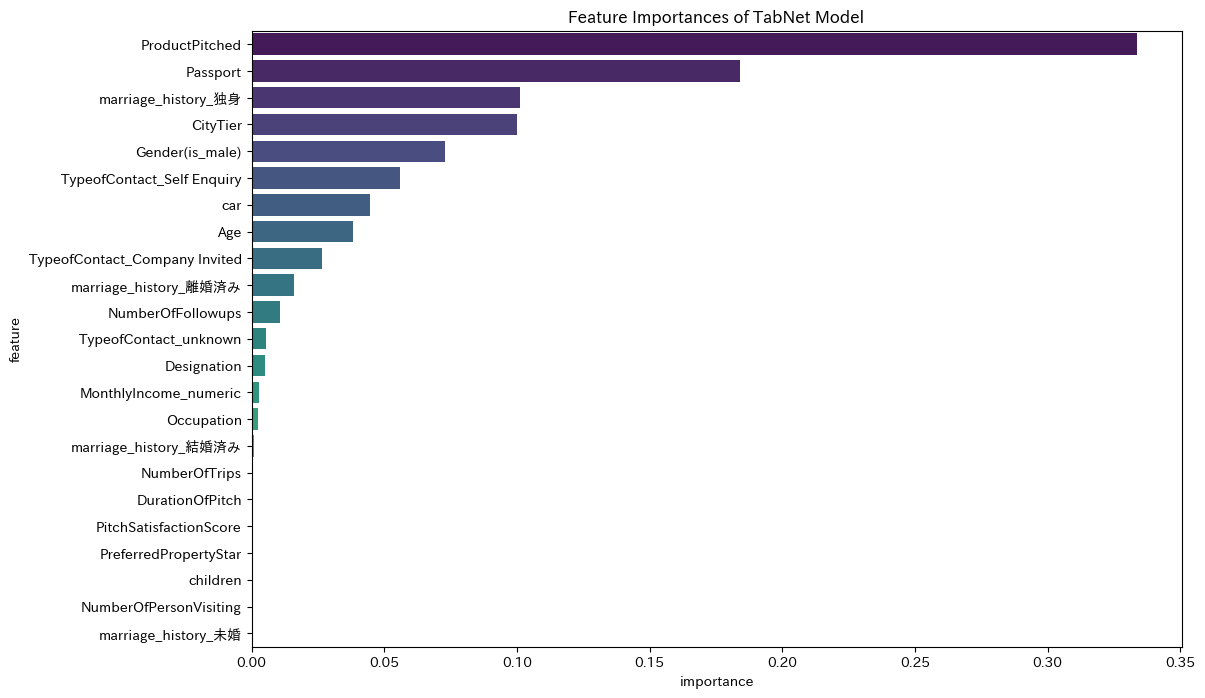

In [126]:
feature_importances_loaded.sort_values(
    by = "importance", 
    ascending = False, 
    inplace = True
)
plt.figure(figsize = (12, 8))
sns.barplot(y = feature_importances_loaded["feature"][:25], x = feature_importances_loaded["importance"][:25], palette = "viridis")
plt.title("Feature Importances of TabNet Model")
plt.savefig(data_directory_name + "/feat_imp_tb_atac_2.png", dpi = 100)
plt.show()

In [101]:
feature_importances = pd.DataFrame()
feature_importances["feature"] = train_df.drop(columns=[TARGET_COLUMN, "id"]).columns
feature_importances["importance"] = tabnet_model.feature_importances_

/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/2239368221.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = feature_importances["feature"][:25], x = feature_importances["importance"][:25], palette = "viridis")


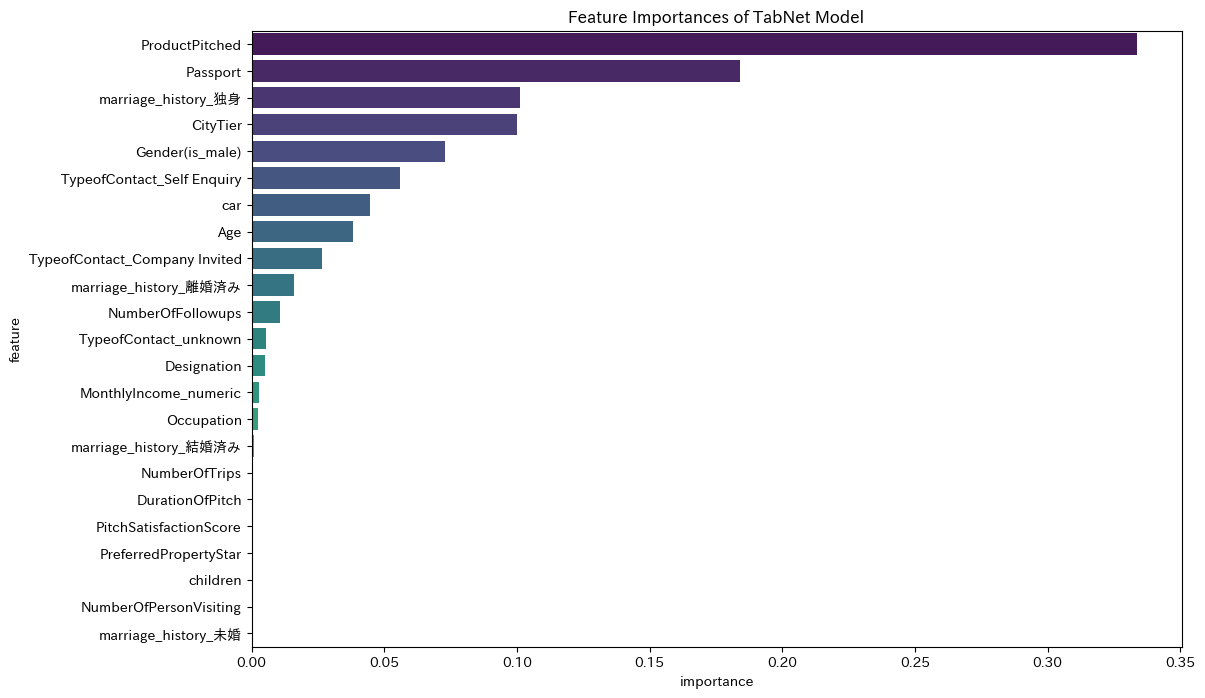

In [102]:
feature_importances.sort_values(
    by = "importance", 
    ascending = False, 
    inplace = True
)
plt.figure(figsize = (12, 8))
sns.barplot(y = feature_importances["feature"][:25], x = feature_importances["importance"][:25], palette = "viridis")
plt.title("Feature Importances of TabNet Model")
plt.savefig(data_directory_name + "/feat_imp_tb_atac_2.png", dpi = 100)
plt.show()

In [116]:
val_predicted_df = pd.DataFrame()
val_predicted_df["acutual"] = y_val
val_predicted_df["prediction"] = tabnet_model.predict_proba(X_val)[:, 1]

In [117]:
# 実際のラベルと予測確率を取得
y_true = val_predicted_df["acutual"]
y_pred = val_predicted_df["prediction"]
print(y_true)
# ROC曲線を計算
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# AUCを計算
roc_auc = auc(fpr, tpr)
print(roc_auc)

0      0.0
1      0.0
2      0.0
3      1.0
4      0.0
      ... 
693    0.0
694    1.0
695    1.0
696    0.0
697    0.0
Name: acutual, Length: 698, dtype: float32
0.8612976809022937


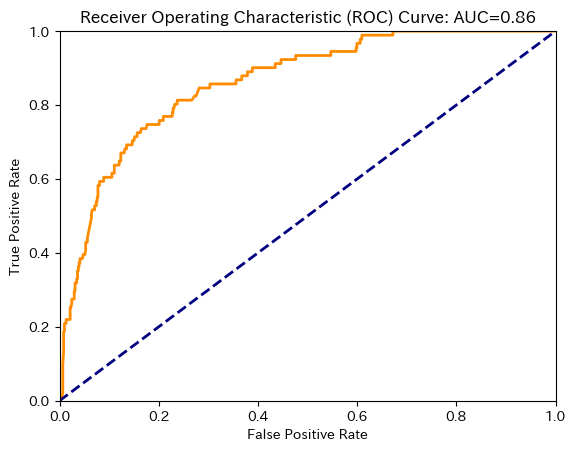

In [119]:
# 実際のラベルと予測確率を取得
y_true = val_predicted_df["acutual"]
y_pred = val_predicted_df["prediction"]

# ROC曲線を計算
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# AUCを計算
roc_auc = auc(fpr, tpr)

# ROC曲線をプロット
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve: AUC={0:0.2f}'.format(roc_auc))
plt.savefig(data_directory_name + "/val_roc_curve_tabnet.png", dpi = 100)


In [120]:
# 特徴量として使用するカラムを定義 (NUMERIC_COLUMNSに基づく)
X_test = test_df.drop(columns=["id"]).values  # "id" カラムを除外して特徴量に
y_test = tabnet_model.predict_proba(X_test)[:, 1]  # 予測確率を取得

# 結果をデータフレームに変換
submission_df = pd.DataFrame({
    "id": test_df["id"].astype(int),  # "id" カラムを使用
    "prediction": y_test
})

# CSVファイルに保存
submission_df.to_csv(data_directory_name + "/submission_2.csv", index=False, header=None)